In [1]:
%matplotlib inline
# %matplotlib qt5

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
from mpl_toolkits.axes_grid1 import make_axes_locatable

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
expt_path=os.getcwd()+'/data'
import sys
import scipy as sp
import json

import qutip as qt
import qutip.visualization as qplt

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 16})
# style.use('default')
style.use('S:\Connie\prx.mplstyle')

np.set_printoptions(threshold=sys.maxsize)

Could not import QickInstrument (will only work if running on rfsoc). If running on rfsoc, try install/update qick package
Warning failed to import AWG81180A
Warning failed to import Tek5014
Warning failed to import Tek70001
Warning failed to import M8195A


c:\ProgramData\Anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


In [3]:
sys.path.append(os.getcwd()+'/../../qutip_sims')
from QSwitch import QSwitch
from PulseSequence import PulseSequence

# Getting ideal rho

In [4]:
# 2 cardinal points on Bloch sphere for each measurement axis
psiZ = [qt.basis(2,0), qt.basis(2,1)]
psiX = [1/np.sqrt(2)*(psiZ[0]+psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-psiZ[1])]
psiY = [1/np.sqrt(2)*(psiZ[0]+1j*psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-1j*psiZ[1])]
psi_dict = dict(Z=psiZ, X=psiX, Y=psiY)

"""
Define basis in to be used when doing MLE
"""
psi00 = qt.tensor(psiZ[0], psiZ[0])
psi01 = qt.tensor(psiZ[0], psiZ[1])
psi10 = qt.tensor(psiZ[1], psiZ[0])
psi11 = qt.tensor(psiZ[1], psiZ[1])
id2q = qt.tensor(qt.qeye(2), qt.qeye(2))

In [5]:
def name_to_state_2q(init_state): # in format |QA>|QB>
    Qa, Qb, _ = init_state.split('>')
    Qa = Qa[1:]
    Qb = Qb[1:]
    psi_name_dict = {
        '0':psiZ[0],
        '1':psiZ[1],
        '0+1':(psiZ[0]+psiZ[1]).unit(),
        '0-1':(psiZ[0]-psiZ[1]).unit(), 
        '0+i':(psiZ[0]+1j*psiZ[1]).unit(), 
        '0-i':(psiZ[0]-1j*psiZ[1]).unit(), 
    }
    try:
        psiA = psi_name_dict[Qa]
    except:
        print(f'QA state {Qa} is not an allowed cardinal state')
    try:
        psiB = psi_name_dict[Qb]
    except:
        print(f'QB state {Qb} is not an allowed cardinal state')
    return qt.tensor(psiA, psiB)

    
psi_basis_3q = dict() # 27*8 elements
# psi_tensor = [psiZ[0], psiZ[0], psiZ[0], psiZ[0]]
S123 = 'ZZZ'
S1, S2, S3 = S123
psi1 = psi_dict[S1]
psi2 = psi_dict[S2]
psi3 = psi_dict[S3]

psi_basis_3q.update({S123:[]})

for state1 in (0,1):
    for state2 in (0,1):
        for state3 in (0,1):
            psi_basis_3q[S123].append(qt.tensor(psi1[state1], psi2[state2], psi3[state3]).unit())
calib_order_numeric_3q = ['000', '001', '010', '011', '100', '101', '110', '111']
psis = dict() # psis in the ZZZ basis
for i, label_numeric in enumerate(calib_order_numeric_3q):
    psis.update({label_numeric:psi_basis_3q['ZZZ'][i]})
id3q = qt.tensor(qt.qeye(2), qt.qeye(2), qt.qeye(2))

def get_qram_qSLR_state_from_rho(init_rho_IS, output_qubits, post_select=False, post_select_state=None):
    """
    init_rho_IS should be a np array
    outputs partial trace of qram output (needs output_qubits to all be in 0, 2, and/or 3 to work)
    """
    # in order |00>, |01>, |10>, |11> for switch, input
    SI_to_SLR = [psis['000'], -1j*psis['010'], psis['100'], -1j*psis['101']]

    assert np.all([q in [0, 2, 3] for q in output_qubits])
    assert np.shape(init_rho_IS) == id2q.shape
    rho_final_SLR = 0*qt.ket2dm(psis['000'])
    print(f'constructing final state on |Q{output_qubits[0]}, Q{output_qubits[1]}>')
    for i in range(len(SI_to_SLR)):
        slr_ket_i = SI_to_SLR[i]
        for j in range(len(SI_to_SLR)):
            slr_ket_j = SI_to_SLR[j]
            mat_el = init_rho_IS[i, j]
            rho_final_SLR += mat_el * slr_ket_i * slr_ket_j.dag()
    output_indices = [[0,2,3].index(q) for q in output_qubits]
    return qt.ptrace(rho_final_SLR.unit(), output_indices)

# Run experiment and analysis

In [6]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.four_qubit.fourQ_state_tomo
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.amplitude_rabi_f0g1
imported experiments.two_qubit.amprabi_opt_ctrl_state_prep
imported experiments.two_qubit.crosstalk_echo_calib
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.length_rabi_F0G1
imported exper

In [7]:
"""Reopen saved data"""
def prev_data(expt_path, filename=None, verbose=True):
    temp_data_file = expt_path
    if filename is not None: temp_data_file = os.path.join(expt_path, filename)
    if verbose: print(temp_data_file)
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        if verbose: print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [8]:
data_path = 'S:\\QRAM\\qram_4QR2\\'
expt_path = os.path.join(data_path, 'data', 'data_250119')
print('Data will be stored in', expt_path)

Data will be stored in S:\QRAM\qram_4QR2\data\data_250119


In [9]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
# config_file = 'config_q3diamond_full688_reset.yml'
config_file = 'config_q3diamond_full688and638_reset.yml'
# config_path = os.path.join(os.getcwd(), config_file)

# config_file = 'config.yml'
config_path = os.path.join('s:\\Connie\\experiments\\qram_tprocv1_expts\\configs\\', config_file)

print('Config will be', config_path)

Config will be s:\Connie\experiments\qram_tprocv1_expts\configs\config_q3diamond_full688and638_reset.yml


In [10]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

# Tomo analysis

In [11]:
from TomoAnalysis import TomoAnalysis
tomo_analysis = TomoAnalysis(nb_qubits=2)

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [12]:
# ns_address = '10.108.30.56' # Spilker Fermium
ns_address = '10.108.30.75' # Spilker Vibranium
im = InstrumentManager(ns_address=ns_address)

In [13]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())

QICK running on ZCU216, software version 0.2.272

Firmware configuration (built Sat Oct  5 10:21:47 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 32768 samples (4.762 us)
		fs=6881.280 MHz, fabric=430.080 MH

In [ ]:
# lo1 = im[yaml_cfg.aliases.readout_LO]
# lo1.open_device()
# print(lo1.get_id())

# # # TURN OFF
# # lo1.set_standby(True)
# # lo1.set_output_state(False)

# # TURN ON
# lo1.set_standby(False)
# lo1.set_output_state(True)
# lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
# lo_power = float(yaml_cfg.hw.lo.readout.power)
# lo1.set_frequency(lo_freq) # Set LO frequency
# print('set freq to', lo_freq*1e-6, 'MHz')
# lo1.set_power(lo_power) # Set LO power
# print('set power to', lo_power, 'dBm')

# Run experiment and acquire data

## QCTRL stuff

In [ ]:
from qctrl import Qctrl
qctrl = Qctrl()

In [ ]:
# ctrl_result = qctrl.get_result(action_id=1761100)
# ctrl_result = qctrl.get_result(action_id=1763052)
ctrl_result = qctrl.get_result(action_id=1804348)

In [ ]:
print("Fidelity:", 1-ctrl_result.output["cost"]["value"])

times_us = []
I_values_MHz = []
Q_values_MHz = []
for q in range(4):
    if f"$\gammaI_{q}$" not in ctrl_result.output: continue
    I_values_q = []
    Q_values_q = []
    t = 0
    for j in range(2): # I, Q
        name = f"$\gamma{'I' if j==0 else 'Q'}_{q}$"
        control = ctrl_result.output[name]
        for step, pulse in enumerate(control):
            if q==1 and j==0: times_us.append(t)
            t += pulse['duration']
            # factor of 1/2, -1, and 2pi due to how their controls are defined relative to ours
            if j==0: I_values_q.append(pulse['value'])
            else: Q_values_q.append(pulse['value'])

    I_values_MHz.append(I_values_q)
    Q_values_MHz.append(Q_values_q)

times_us = np.array(times_us)*1e-3
I_values_MHz = np.array(I_values_MHz)*1e3
Q_values_MHz = np.array(Q_values_MHz)*1e3

# plt.figure(figsize=(6,8))
plt.suptitle('I, Q Controls (qubit drives)', fontsize=14)
ymax = 1.1*max(abs(np.concatenate((I_values_MHz.flatten(), Q_values_MHz.flatten()))))

controls_index = 0
for q in range(4):
    if f"$\gammaI_{q}$" not in ctrl_result.output: continue
    # plt.subplot(int(f'41{q+1}'))
    plt.plot(1e3*times_us, I_values_MHz[controls_index], label=f'$I_{q}$')
    plt.plot(1e3*times_us, Q_values_MHz[controls_index], label=f'$Q_{q}$')
    plt.ylim(-ymax, ymax)
    plt.ylabel(f'$\gamma_{q}/2\pi$ [MHz]')
    plt.legend()
    controls_index += 1

plt.xlabel('Times [ns]')
# plt.tight_layout()
plt.show()

## Test 2Q tomo

In [33]:
tomo_qubits = [0, 2] # which qubit/resonator we want to probe

In [ ]:
tomoExpt = meas.EgGfStateTomographyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"EgGf_state_tomo_{tomo_qubits[0]}{tomo_qubits[1]}",
    config_file=config_path,
)

tomoExpt.cfg.expt = dict(
    reps=20000, # reps per measurement basis
    singleshot_reps=20000, # reps for single shot calib
    tomo_qubits=tomo_qubits,
    calib_apply_q1_pi2=False, # initialize Q1 to 0+1 for all calibrations
    # Icontrols=I_values_MHz[0],
    # Qcontrols=Q_values_MHz[0],
    # times_us=times_us,
)

# print(tomoExpt.cfg)
import Pyro4.util
try:
    tomoExpt.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
tomoExpt.save_data()

In [ ]:
apply_ps = True
ps_adjust = [-0.3, -1.0, -0.3, -0.3]
# ps_adjust = [np.inf]*4
ps_qubits = [0, 1, 2, 3]

In [ ]:
tomo = tomoExpt

# tomo = qramExpt

# data, attrs = prev_data(expt_path, '00062_qram_protocol.h5')
# pulse_dict = attrs['pulse_dict']
# assert np.all(np.array(attrs['meas_order']) == meas_order)
# assert np.all(np.array(attrs['calib_order']) == calib_order)

data = tomo.data
cfg = tomo.cfg
pulse_dict = tomo.pulse_dict
assert np.all(np.array(tomo.meas_order) == tomo_analysis.meas_order)
assert np.all(np.array(tomo.calib_order) == tomo_analysis.calib_order)

n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(data, cfg, ps_adjust=ps_adjust, ps_qubits=ps_qubits, apply_ps=apply_ps, verbose=True)

np.set_printoptions(suppress=True)

print('Tomography counts')
print(n_tomo_raw)
print('Confusion matrix counts')
print(n_calib)
print('Confusion matrix corrected tomo matrix will be')
print(tomo_analysis.correct_readout_err(n_tomo_raw, n_calib))
# print('Negative counts corrected tomo matrix will be')
# print(tomo_analysis.fix_neg_counts(correct_readout_err(n_tomo_raw, n_calib)))

## Test 2Q optimal control pulses

In [364]:
import yaml
print('Using config file', config_file)
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

Using config file config_q3diamond_full688and638_reset.yml


240920_qram_4q_2qubit_+egg
dict_keys(['times', 'I_0', 'Q_0', 'I_1', 'Q_1'])
IQ_qubits [0, 1]


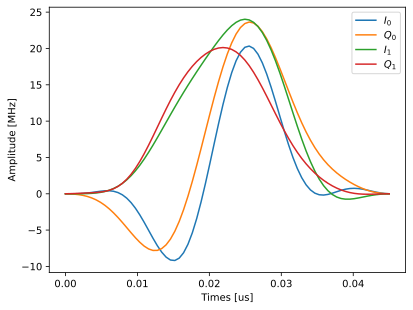

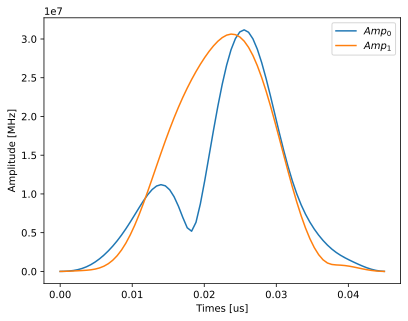

In [365]:
# pulse_filename = yaml_cfg.device.qubit.pulses.pulse_pp.filename
# pulse_filename = yaml_cfg.device.qubit.pulses.pulse_1p.filename
pulse_filename = yaml_cfg.device.qubit.pulses.pulse_p1.filename
pulse_filepath = os.path.join(os.getcwd(), pulse_filename + '.npz')
print(pulse_filename)

pulse_params_dict = dict() # open file
with np.load(pulse_filepath) as npzfile:
    for key in npzfile.keys():
        pulse_params_dict.update({key:npzfile[key]})

print(pulse_params_dict.keys())
IQ_qubits = [0, 1]
print('IQ_qubits', IQ_qubits)

times = pulse_params_dict['times']
I_0 = pulse_params_dict['I_0']
Q_0 = pulse_params_dict['Q_0']
I_1 = pulse_params_dict['I_1']
Q_1 = pulse_params_dict['Q_1']
plt.figure()
plt.plot(times*1e6, I_0*1e-6, label='$I_0$')
plt.plot(times*1e6, Q_0*1e-6, label='$Q_0$')
plt.plot(times*1e6, I_1*1e-6, label='$I_1$')
plt.plot(times*1e6, Q_1*1e-6, label='$Q_1$')
plt.legend()
plt.xlabel('Times [us]')
plt.ylabel('Amplitude [MHz]')
plt.show()

plt.figure()
plt.plot(times*1e6, np.abs(I_0+1j*Q_0), label='$Amp_0$')
plt.plot(times*1e6, np.abs(I_1+1j*Q_1), label='$Amp_1$')
plt.legend()
plt.xlabel('Times [us]')
plt.ylabel('Amplitude [MHz]')
plt.show()

I_values_MHz = np.array([I_0, I_1])*1e-6
Q_values_MHz = np.array([Q_0, Q_1])*1e-6
times_us = times*1e6

In [54]:
tomo_qubits = [0, 1] # which qubits to do tomo on

# init_state = '|0+1>|0+1>' # this is just for reference when doing the 2Q tomo comparison
# init_state = '|1>|0+1>' # this is just for reference when doing the 2Q tomo comparison
init_state = '|0+1>|1>' # this is just for reference when doing the 2Q tomo comparison

readout_cool = True

In [367]:
centers = [3000, 5200]
spans = [2000, 2000]
# spans = [500, 500]
npts = [6, 6]

# centers = [4100, 5100]
# spans = [0, 0]
# npts = [1, 1]

centers = np.array(centers)
spans = np.array(spans)
npts = np.array(npts)
print('number points', (npts[0]+1)*(npts[1]+1))

tomoExpt = meas.OptimalCtrlTomo2QExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"OptimalCtrlTomo2Q_{tomo_qubits[0]}{tomo_qubits[1]}",
    config_file=config_path,
)

tomoExpt.cfg.expt = dict(
    starts=(centers-spans/2).astype(int), # start gain for each qubit in IQ_qubits
    steps=(spans/npts).astype(int),
    expts=npts+1,
    reps=5000, # reps per measurement basis
    # reps=100, # reps per measurement basis
    singleshot_reps=15000, # reps for single shot calib
    # singleshot_reps=1000, # reps for single shot calib
    tomo_qubits=tomo_qubits,
    
    Icontrols=I_values_MHz, # 2D array with array of Icontrols for each of IQ_qubits
    Qcontrols=Q_values_MHz, # 2D array with array of Qcontrols for each of IQ_qubits
    times_us=times_us,
    IQ_qubits=IQ_qubits,
    
    readout_cool=readout_cool,
    n_init_readout=1,
    n_trig=1,
    init_read_wait_us=10,
   
    # thresholds=[530.1641328860773, 298.0622274040452, 0, 0],
    # angles=[-156.06235175077572, -177.6596617753593, 0, 0],
    # ge_avgs=[[-442.594915, -279.7363071627907, -914.3632173488371, -39.117149279069764], [-177.4867981416169, 198.44441421595226, -387.54766318502436, 200.4889138632664], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
    # counts_calib=[[15698, 2664, 1281, 357], [3353, 14690, 562, 1395], [1904, 406, 14898, 2792], [820, 1603, 3297, 14280]]
)

# print(tomoExpt.cfg)
import Pyro4.util
try:
    tomoExpt.acquire(progress=True, debug=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

number points 49
gainpts Q0 [2000 2333 2666 2999 3332 3665 3998]
gainpts Q1 [4200 4533 4866 5199 5532 5865 6198]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 76.66922230741025 	 angle (deg): 26.03327721940717 	 threshold ge: 312.0803289891335
Qubit (1)
ge fidelity (%): 53.900000000000006 	 angle (deg): -173.43104307957515 	 threshold ge: 408.0059907231424


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (2) ge
ge fidelity (%): 80.14 	 angle (deg): 155.72747849360348 	 threshold ge: 490.2627886037599


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (3) ge
ge fidelity (%): 75.26666666666667 	 angle (deg): 29.431008995938555 	 threshold ge: 76.64195865903628
thresholds=[312.0803289891335, 408.0059907231424, 490.2627886037599, 76.64195865903628],
angles=[26.03327721940717, -173.43104307957515, 155.72747849360348, 29.431008995938555],
ge_avgs=[[199.03519633969907, 85.0020259837963, 540.181451461227, -83.35677699652778], [-296.75081434461805, -95.21728838975694, -508.2667942274306, -68.54649733072917], [-123.88178407118056, -398.12985993923616, -510.5924571180556, -594.4715744791666], [179.27013018663197, 433.4731576171875, 500.20205553385415, 250.7809875]],
counts_calib=[[11409, 2199, 970, 422], [3815, 9681, 522, 982], [1715, 394, 9893, 2998], [817, 1527, 2300, 10356]]


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [368]:
pulse_dict = tomoExpt.pulse_dict
tomoExpt.save_data()

Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00220_OptimalCtrlTomo2Q_01.h5


'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00220_OptimalCtrlTomo2Q_01.h5'

In [369]:
apply_ps = True
ps_adjust = [-0.3, -1.0, -0.3, -0.3]
# ps_adjust = [np.inf]*4
ps_qubits = [0, 1, 2, 3]

init_state |0+1>|1>
Using evol mats from file S:\Connie\experiments\qramLL_4QR2\evol_mats\evol_mats_01.npz
2000 4200 fid 0.7900935947103881 purity 0.9264454457985281
2000 4533 fid 0.7252161930390134 purity 0.8231540847372207


 S:\Connie\experiments\qramLL_4QR2\TomoAnalysis.py: 757ComplexWarning: Casting complex values to real discards the imaginary part
 S:\Connie\experiments\qramLL_4QR2\TomoAnalysis.py: 762

2000 4866 fid 0.8096309724414746 purity 0.8898649511788913
2000 5199 fid 0.8350459024922657 purity 0.8867231663415802
2000 5532 fid 0.8672691344765677 purity 0.9323344636694888
2000 5865 fid 0.7098493244203479 purity 0.7273143716327338
2000 6198 fid 0.82624686324649 purity 0.9152988591225367
2333 4200 fid 0.8246409787190135 purity 0.9999999999999989
2333 4533 fid 0.8786613117637943 purity 0.9917800380852212
2333 4866 fid 0.8295685160958223 purity 0.7779749029279631
2333 5199 fid 0.8980605779608543 purity 0.9434951297632973
2333 5532 fid 0.8454612584773566 purity 0.84982735787441
2333 5865 fid 0.8277355548988974 purity 0.8739597963854973
2333 6198 fid 0.8006882533941494 purity 0.8561253487969542
2666 4200 fid 0.7518277412037819 purity 1.0000000000000002
2666 4533 fid 0.8515566056677963 purity 0.8583551170326805
2666 4866 fid 0.8813545311852964 purity 0.8821644736850136
2666 5199 fid 0.9007145082293949 purity 0.9316244804477191
2666 5532 fid 0.9042071647230624 purity 0.922449755467669
26

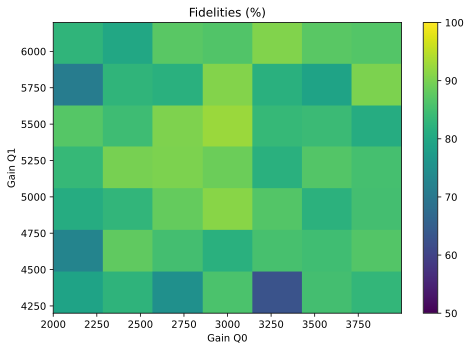

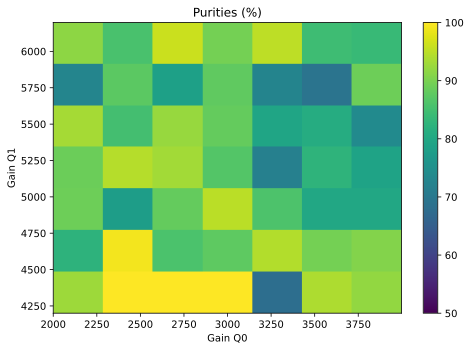

In [370]:
tomo = tomoExpt

# rho_id = qt.ket2dm((psi00 + psi01 + psi10 + psi11).unit())
print('init_state', init_state)
rho_id = qt.ket2dm(name_to_state_2q(init_state))

# filename = 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00023_OptimalCtrlTomo2Q_01.h5'
# tomo = meas.OptimalCtrlTomo2QExperiment(config_file=config_path)
# data, attrs = prev_data(filename, None)
# tomo.data = data
# tomo.cfg = AttrDict(attrs['config'])
# pulse_dict = attrs['pulse_dict']

q0, q1 = tomo_qubits
evol_mats_file_path = os.path.join(evol_mats_path, evol_mats_filename)
print(f'Using evol mats from file {evol_mats_file_path}')

evol_mats = dict()
with np.load(evol_mats_file_path) as npzfile:
    for key in npzfile.keys():
        evol_mats.update({key:npzfile[key]})


data = tomo.data
cfg = tomo.cfg

gainpts0 = tomo.data['gainpts0']
gainpts1 = tomo.data['gainpts1']
fids_grid = np.zeros(shape=(len(gainpts1), len(gainpts0)))
purities_grid = np.zeros(shape=(len(gainpts1), len(gainpts0)))

for igain0, gain0 in enumerate(gainpts0):
    for igain1, gain1 in enumerate(gainpts1):
        if apply_ps:
            n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(
                data, cfg, ps_adjust=ps_adjust, ps_qubits=ps_qubits,
                ishots_raw=data['ishots_raw'][igain0, igain1], qshots_raw=data['qshots_raw'][igain0, igain1],
                apply_ps=apply_ps, verbose=False)
        else:
            n_tomo_raw = data['counts_tomo_gains'][igain0, igain1]
            n_calib = data['counts_calib']
        
        rho_MLE_ZZ = tomo_analysis.get_rho_from_counts(
            n_tomo_raw=n_tomo_raw,
            n_calib=n_calib,
            correct_readout=True,
            correct_neg_counts=True,
            method='analytical',
            ZZ_correction=True,
            evol_mats=evol_mats,
        )
        fid_ZZ = qt.fidelity(qt.Qobj(rho_MLE_ZZ, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
        purity_ZZ = np.real(np.trace(rho_MLE_ZZ @ rho_MLE_ZZ))
        
        fids_grid[igain1, igain0] = fid_ZZ
        purities_grid[igain1, igain0] = purity_ZZ
        print(gain0, gain1, 'fid', fid_ZZ, 'purity', purity_ZZ)

x_sweep = gainpts0
y_sweep = gainpts1

plt.figure(figsize=(7,5))
plt.subplot(111, title=f"Fidelities (%)", ylabel=f"Gain Q{tomo.cfg.expt.IQ_qubits[1]}")
plt.imshow(
    np.flip(fids_grid*100, 0),
    cmap='viridis',
    extent=[x_sweep[0], x_sweep[-1], y_sweep[0], y_sweep[-1]],
    aspect='auto')
plt.colorbar()
plt.clim(vmin=50, vmax=100)
plt.xlabel(f'Gain Q{tomo.cfg.expt.IQ_qubits[0]}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,5))
plt.subplot(111, title=f"Purities (%)", ylabel=f"Gain Q{tomo.cfg.expt.IQ_qubits[1]}")
plt.imshow(
    np.flip(purities_grid*100, 0),
    cmap='viridis',
    extent=[x_sweep[0], x_sweep[-1], y_sweep[0], y_sweep[-1]],
    aspect='auto')
plt.colorbar()
plt.clim(vmin=50, vmax=100)
plt.xlabel(f'Gain Q{tomo.cfg.expt.IQ_qubits[0]}')
plt.tight_layout()
plt.show()

Pick one gain to plot tomo for

In [371]:
gain0 = 3000 # x axis
gain1 = 5532 # y axis

tomo = tomoExpt
cfg = tomo.cfg

data = tomo.data
gainpts0 = tomo.data['gainpts0']
gainpts1 = tomo.data['gainpts1']
igain0 = np.argmin(np.abs(gainpts0-gain0)) 
igain1 = np.argmin(np.abs(gainpts1-gain1)) 
print('plotting at gain Q0', gainpts0[igain0], 'Q1', gainpts1[igain1])
print('expected fid', fids_grid[igain1, igain0])
print('expected purity', purities_grid[igain1, igain0])
# tomo = qramExpt

# data, attrs = prev_data(expt_path, '00062_qram_protocol.h5')
# pulse_dict = attrs['pulse_dict']
# assert np.all(np.array(attrs['meas_order']) == meas_order)
# assert np.all(np.array(attrs['calib_order']) == calib_order)

pulse_dict = tomo.pulse_dict
assert np.all(np.array(tomo.meas_order) == tomo_analysis.meas_order)
assert np.all(np.array(tomo.calib_order) == tomo_analysis.calib_order)

if apply_ps:
    n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(
        data, cfg, ps_adjust=ps_adjust, ps_qubits=ps_qubits,
        ishots_raw=data['ishots_raw'][igain0, igain1], qshots_raw=data['qshots_raw'][igain0, igain1],
        apply_ps=apply_ps, verbose=False)
else:
    n_tomo_raw = data['counts_tomo_gains'][igain0, igain1]
    n_calib = data['counts_calib']

np.set_printoptions(suppress=True)

print('Tomography counts')
print(n_tomo_raw)
print('Confusion matrix counts')
print(n_calib)
print('Confusion matrix corrected tomo matrix will be')
print(tomo_analysis.correct_readout_err(n_tomo_raw, n_calib))
# print('Negative counts corrected tomo matrix will be')
# print(tomo_analysis.fix_neg_counts(tomo_analysis.correct_readout_err(n_tomo_raw, n_calib)))

plotting at gain Q0 2999 Q1 5532
expected fid 0.9243577344888096
expected purity 0.8820013485423933
Tomography counts
[[ 200.  836.  161.  571.]
 [ 627.  456.  336.  395.]
 [ 577.  468.  319.  404.]
 [ 429. 1115.   58.  228.]
 [ 796.  700.  122.  154.]
 [ 792.  747.  143.  159.]
 [ 310. 1176.   72.  249.]
 [ 762.  680.  137.  172.]
 [ 769.  644.  149.  166.]]
Confusion matrix counts
[[4304.  812.  154.   67.]
 [1355. 3628.   60.  173.]
 [ 376.   90. 3683. 1054.]
 [ 151.  417.  819. 3805.]]
Confusion matrix corrected tomo matrix will be
[[-153.75047 1151.69445   55.8385   714.21752]
 [ 564.15601  460.84916  343.01288  399.98195]
 [ 508.45598  503.90887  325.99543  429.63972]
 [  16.26822 1518.45078    2.36374  230.91726]
 [ 702.85297  832.61935  100.31745  132.21024]
 [ 646.30038  872.67826  126.08352  122.93783]
 [-170.35711 1661.63803   22.89941  253.81967]
 [ 673.94588  818.80759  120.05849  155.18804]
 [ 709.0675   771.88676  141.4794   145.56635]]
Negative counts corrected tomo mat

## Qram experiment

In [14]:
# tomo_qubits = [0, 3] # which qubit/resonators to do tomo on
# tomo_qubits = [0, 2] # which qubit/resonators to do tomo on
tomo_qubits = [0, 1] # which qubit/resonators to do tomo on

In [15]:
save_data = False

In [16]:
init_state = '|1>|0+1>' # Q0/Q1 (switch, input)
# init_state = 'Q3Q0_|1>|1>'
# init_state = '|1>|0>' # Q0/Q1 (switch, input)
# init_state = 'Q2Q0_|1>|0>'
# init_state = '|1>|1>' # Q0/Q1 (switch, input)
# play_pulses = [2, 1, 4, 3] # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]
# play_pulses = [2, 4] # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]
# play_pulses = [1, 3] # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]
play_pulses = [0] # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]
# play_pulses = [2, 1, 4, 3]
# play_pulses = [2]*8 # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]

# cool_qubits = [0, 1]
cool_qubits = None

readout_cool = False
full_mux_expt = True
resonator_reset = [0, 2, 3]

use_IQ_pulse = False # state transfer IQ pulses for the state prep
use_robust_pulses = True # use robust pulses for state prep + tomo

post_select = False # this is not the readout post selection

# add_phase = True # phase for swaps
add_phase = False
print('init_state', init_state)
print('post select', post_select)

init_state |1>|0+1>
post select False


In [18]:
qramExpts = []
nrepeat = 1
print('TOMO QUBITS', tomo_qubits)
print('init state', init_state)
saved_files = []

for i in tqdm(range(nrepeat)):
    qramExpt = meas.QramProtocolExperiment(
        soccfg=soc,
        path=expt_path,
        config_file=config_path,
        ns_address=ns_address,
    )

    # span = 2.161196963262976 # total time [us]
    # span = 1.1659462011134218 # total time [us]
    span = np.inf
    npts = 1
    # span = 1.8 # total time [us]
    # npts = 120
    # span = 0.8 # total time [us]
    # npts = 10
    if span < np.inf: print('time step size [cycles]:', soc.us2cycles(span/npts))

    qramExpt.cfg.expt = dict(
        # start=0, # start protocol time [us],
        # step=span/npts, # time step [us], 
        # expts=npts+1, # number of different time experiments - added 1 to include 0 step and full span

        start=span,
        step=0,
        expts=1, # number of different time experiments

        # reps=1000000, # number of reps per time step,
        reps=10000, # number of reps per time step,
        # singleshot_reps=10, # reps per state for singleshot calibration
        singleshot_reps=10000, # reps per state for singleshot calibration
        post_process='scale', # 'threshold', (uses single shot binning), 'scale' (scale by ge_avgs), or None
        tomo_2q=True, # True/False whether to do 2q state tomography on state at last time step
        tomo_qubits=tomo_qubits, # the qubits on which to do the 2q state tomo
        calib_apply_q1_pi2=False, # initialize Q1 to 0+1 for all calibrations
        init_state=init_state,
        play_pulses=play_pulses,
        cool_qubits=cool_qubits,
        
        use_IQ_pulse=use_IQ_pulse, # state transfer IQ pulses for the state prep
        use_robust_pulses=use_robust_pulses, # use robust pulses for state prep + tomo
        plot_IQ=False,
        
        add_phase=add_phase,
        
        readout_cool=readout_cool,
        n_init_readout=1,
        n_trig=1,
        init_read_wait_us=2,
        
        full_mux_expt=full_mux_expt,
        resonator_reset=resonator_reset,
        
        # meas_order=['XX'],
        
        # Icontrols=I_values_MHz, # 2D array with array of Icontrols for each of IQ_qubits
        # Qcontrols=Q_values_MHz, # 2D array with array of Qcontrols for each of IQ_qubits
        # times_us=times_us,
        # IQ_qubits=IQ_qubits,
        # IQ_gain=[3700, 3950],
        
        # thresholds=[33.169103683345895, 37.49913270024612, 0, 0],
        # angles=[-24.579056838557847, 115.19639444481155, 0, 0],
        # ge_avgs=[[34.43056101813111, -9.525004532775455, 44.589988819153874, -4.651175313807532], [30.053312459336368, -50.17723301886793, 25.548312166558233, -59.65660634352635], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
        # counts_calib=[[12553, 5207, 1604, 636], [4673, 12956, 666, 1705], [2241, 876, 12383, 4500], [918, 2095, 4712, 12275]]
 
    )

    # print(qramExpt.cfg)

    import Pyro4.util
    try:
        qramExpt.acquire(progress=True, debug=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))

    qramExpts.append(qramExpt)
    if save_data: saved_files.append(qramExpt.save_data())

TOMO QUBITS [0, 1]
init state |1>|0+1>


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 81.3992579257926 	 angle (deg): 0.0 	 threshold ge: 981.3865437121162
Qubit (1)
ge fidelity (%): 46.84999999999998 	 angle (deg): 0.0 	 threshold ge: 1133.6333772856133
thresholds=[981.3865437121162, 1133.6333772856133, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[-0.6205959316517495, 1.7629946297803085, 2.0008698128559823, -0.8476379170056966], [429.1301867371847, 779.5735119609438, 548.4438690805534, 1152.1870986981285], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6877, 2342, 589, 192], [2487, 6402, 308, 803], [750, 334, 4668, 4248], [377, 761, 2561, 6301]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 554  533 3987 4926]
ZX [ 661  417 4867 4055]
ZY [ 680  490 4360 4470]
XZ [2257 2523 2436 2784]
XX [3264 1508 2470 2758]
XY [3103 1693 2902 2302]
YZ [2587 2309 2197 2907]
YX [3935 1410 2532 2123]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:04<00:00, 64.24s/it]

YY [3550 1516 2843 2091]


In [85]:
qramExpt.save_data()

Saving S:\QRAM\qram_4QR2\data\data_241025\00119_qram_protocol.h5


'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00119_qram_protocol.h5'

### post processing average counts

In [19]:
apply_ps = False
ps_adjust = [-0.3, -1.0, -0.3, -0.3]
# ps_adjust = [np.inf]*4
ps_qubits = [0, 1, 2, 3]


postselect = False # this is not the readout post selection
postselect_state = 1 # select on Q1 being 0 (-) or 1 (+)

In [20]:
cfg = qramExpt.cfg
print('init state', qramExpt.cfg.expt.init_state)
n_tomo_raw_rounds = []
n_calib_rounds = []
n_tomo_rounds = []
for qramExpt in qramExpts:
    tomo = qramExpt
    data = tomo.data
    if postselect and qramExpt.cfg.expt.post_select:
        n_tomo_raw = np.array(data[f'counts_tomo_ps{postselect_state}'])
        n_calib = np.array(data['counts_calib'])
        print(f'Just getting states from post selection value of {postselect_state}')
    elif postselect and not qramExpt.cfg.expt.post_select:
        assert False, 'You are trying to post select but the experiment was not run with the post select flag=True!'
    elif qramExpt.cfg.expt.post_select:
        n_tomo_raw = np.array(data[f'counts_tomo_ps0'] + data[f'counts_tomo_ps1'])
        n_calib = np.array(data['counts_calib'])
    else:
        n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(data, cfg, ps_adjust=ps_adjust, ps_qubits=ps_qubits, apply_ps=apply_ps, verbose=True)
    
    n_tomo_raw_rounds.append(n_tomo_raw)
    n_calib_rounds.append(n_calib)

pulse_dict = qramExpts[-1].pulse_dict
# print(pulse_dict)

init state |1>|0+1>


In [21]:
n_tomo_raw = np.average(n_tomo_raw_rounds, axis=0)
n_tomo_raw_std = np.std(n_tomo_raw_rounds, axis=0)
n_calib = np.average(n_calib_rounds, axis=0)
n_calib_std = np.std(n_calib_rounds, axis=0)
n_tomo_avg = np.average(n_tomo_rounds, axis=0)
n_tomo_std = np.std(n_tomo_rounds, axis=0)
# n_tomo_corrected = tomo_analysis.fix_neg_counts(tomo_analysis.correct_readout_err(n_tomo_raw, n_calib))
print('num rounds', len(n_tomo_raw_rounds))

print('Measure order', tomo_analysis.meas_order)

print('Average raw tomography counts')
for r in range(n_tomo_raw.shape[0]):
    n_tomo_raw[r,:]/=np.sum(n_tomo_raw[r,:])
print(n_tomo_raw)
# print('Std raw tomography counts')
# print(n_tomo_raw_std)
print('Average confusion matrix counts')
for r in range(n_calib.shape[0]):
    n_calib[r,:]/=np.sum(n_calib[r,:])
print(n_calib)
print('Corrected counts')
print(np.around(tomo_analysis.correct_readout_err(n_tomo_raw, n_calib), decimals=3))
# print('Std confusion matrix counts')
# print(n_calib_std)
# print('Average n_tomo')
# print(n_tomo_avg)
# print('Std n_tomo')
# print(n_tomo_std)
# print('Corrected average tomo with average calib counts, corrected for neg counts')
# print(n_tomo_corrected)

# n_tomo = n_tomo_avg
# print(pulse_dict['ZX'].keys())
# print(pulse_dict['ZX']['Yhalf_q1'])
# print(pulse_dict['ZX']['Xhalf_q1'])

num rounds 1
Measure order ['ZZ' 'ZX' 'ZY' 'XZ' 'XX' 'XY' 'YZ' 'YX' 'YY']
Average raw tomography counts
[[0.0554 0.0533 0.3987 0.4926]
 [0.0661 0.0417 0.4867 0.4055]
 [0.068  0.049  0.436  0.447 ]
 [0.2257 0.2523 0.2436 0.2784]
 [0.3264 0.1508 0.247  0.2758]
 [0.3103 0.1693 0.2902 0.2302]
 [0.2587 0.2309 0.2197 0.2907]
 [0.3935 0.141  0.2532 0.2123]
 [0.355  0.1516 0.2843 0.2091]]
Average confusion matrix counts
[[0.6877 0.2342 0.0589 0.0192]
 [0.2487 0.6402 0.0308 0.0803]
 [0.075  0.0334 0.4668 0.4248]
 [0.0377 0.0761 0.2561 0.6301]]
Corrected counts


 C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py: 520RuntimeWarning: invalid value encountered in scalar divide
 C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py: 129RuntimeWarning: Degrees of freedom <= 0 for slice
 C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py: 206RuntimeWarning: invalid value encountered in divide
 C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py: 163RuntimeWarning: invalid value encountered in scalar divide
 C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py: 198

[[ 0.     0.002  0.666  0.332]
 [ 0.     0.002  0.998 -0.   ]
 [ 0.     0.013  0.86   0.128]
 [ 0.169  0.296  0.416  0.118]
 [ 0.406  0.048  0.388  0.157]
 [ 0.357  0.103  0.541 -0.   ]
 [ 0.249  0.228  0.303  0.22 ]
 [ 0.518  0.006  0.476 -0.   ]
 [ 0.447  0.042  0.51  -0.   ]]


Plot single shot blobs for various bases

In [121]:
tomo = qramExpt

In [95]:
q = 0
plot_bases = ['ZZ']

data = tomo.data
check_states = []

iprep_g = 0
if q == tomo.cfg.expt.tomo_qubits[0]: iprep_e = 2
else: iprep_e = 1
iprep_ee = 3

data['iqshots'] = []
data['iqshots'].append((data[f'calib_ishots_raw'][iprep_g, :, -1, :], data[f'calib_qshots_raw'][iprep_g, :, -1, :]))
check_states.append('g')
data['iqshots'].append((data[f'calib_ishots_raw'][iprep_e, :, -1, :], data[f'calib_qshots_raw'][iprep_e, :, -1, :]))
check_states.append('e')
data['iqshots'].append((data[f'calib_ishots_raw'][iprep_ee, :, -1, :], data[f'calib_qshots_raw'][iprep_ee, :, -1, :]))
check_states.append('ee')

for basis in plot_bases:
    ibasis = np.where(tomo_analysis.meas_order == basis)[0][0]
    data['iqshots'].append((data[f'ishots_raw'][ibasis, :, -1, :], data[f'qshots_raw'][ibasis, :, -1, :]))
    check_states.append(basis)

play_pulses_list = [] # this is just so we don't print play pulses in the multihist
for check_state in check_states:
    play_pulses_list.append([0])
g_states = [0]
e_states = [1]

meas.single_qubit.single_shot.multihist(
    title=f'Single Shot Q{q} with Multi Readout',
    data=data, check_qubit=q, check_states=check_states, play_pulses_list=play_pulses_list, g_states=g_states, e_states=e_states,
    plot=True, export=True)

g unrotated averages:
I 153.30682987080104 +/- 157.32054944247898 	 Q 217.1223333333333 +/- 141.3361102164992 	 Amp 301.119706597186 +/- 157.1549087492475
Rotated (theta=-0.6213754729628493):
I 251.04913741636943 +/- 170.87577995648476 	 Q 87.28930243530819 +/- 124.60786151875367 	 Amp 265.79144402547246 +/- 157.1549087492475
e unrotated averages:
I 470.169922118863 +/- 169.17283148206135 	 Q 443.9923636692506 +/- 145.78154327321593 	 Amp 660.9410711297123 +/- 176.68497510131715
Rotated (theta=-0.6213754729628493):
I 640.7570150550231 +/- 184.99926100713037 	 Q 87.28930243530819 +/- 125.08788389605972 	 Amp 646.6753239933203 +/- 176.68497510131715
ee unrotated averages:
I 449.7158577777779 +/- 173.84332881185708 	 Q 423.1998562790698 +/- 153.0774827193562 	 Amp 632.1569343699769 +/- 188.08056812829648
Rotated (theta=-0.6213754729628493):
I 612.0218123529866 +/- 196.16008314947985 	 Q 82.29077892202478 +/- 123.18863773445753 	 Amp 617.5293281225013 +/- 188.08056812829648
ZZ unrotated av

[[0.7739999999999998], [437.8966430523112], -35.60219209371666]

In [ ]:
# n_tomo = np.array( # |0>(|0+1>)
# [[7000,    0,    0,    0.],
#  [3792, 3073,  136,    0.],
#  [3970, 2784,    0,  247.],
#  [2472,    0, 4528,    0.],
#  [1411, 1199, 2044, 2346.],
#  [1533, 1196, 1949, 2322.],
#  [2195,    0, 4805,    0.],
#  [1624, 1141, 1970, 2265.],
#  [1549, 1185, 2072, 2193.]]
# )
 
# n_tomo = np.array( # |1>(|0+1>)
# [[ 971, 2621, 3408,    0.],
#  [1845, 2063, 1577, 1515.],
#  [1916, 1949, 1368, 1767.],
#  [2170,  999, 2005, 1825.],
#  [1757, 1430, 1434, 2378.],
#  [1457, 1758, 1643, 2142.],
#  [2217, 1055, 1985, 1743.],
#  [1738, 1478, 1332, 2453.],
#  [1841, 1476, 1305, 2378.]]
# )

# n_tomo = np.array( # (|0+1>)(|0+1>)
# [[3569, 1651, 1780,    0.],
#  [2896, 2730,  880,  495.],
#  [2897, 2727,  773,  603.],
#  [2200,  737, 3594,  470.],
#  [1630, 1303, 2016, 2051.],
#  [1626, 1360, 1906, 2108.],
#  [2408,  460, 3146,  987.],
#  [1430, 1641, 2026, 1904.],
#  [1478, 1387, 1767, 2368.]]
# )

# n_tomo = np.array( # (|0+i1>)(|0+1>)
# [[3163., 2173., 1664.,    0.],
#  [2438., 3299.,  806.,  456.],
#  [2627., 3226.,  722.,  425.],
#  [1857., 1092., 3028., 1023.],
#  [1242., 1632., 1695., 2431.],
#  [1469., 1365., 1518., 2647.],
#  [1980.,  885., 2896., 1239.],
#  [1300., 1627., 1468., 2605.],
#  [ 963., 1985., 1752., 2300.]])


## Big qram protocol loop!

In [14]:
cardinal_states = ['|0>', '|1>', '|0+1>', '|0+i>']
init_states = []
for state0 in cardinal_states:
    for state1 in cardinal_states:
        init_states.append(state0 + state1)

# init_states = ['|1>|0+1>', '|0+1>|1>', '|0+1>|0+1>', '|0>|0>', '|0>|1>']
# init_states = ['|0+1>|1>', '|1>|0+1>', '|0>|0+1>', '|0+1>|0+1>']
# init_states = ['|1>|0+1>', '|1>|0+i>', '|1>|1>']


print(init_states)
print(len(init_states))

protocol_play = [0] # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]
# init_pulse_play = [0]

tomo_qubits = [0, 1] # which qubit/resonators to do tomo on

cool_qubits = None
# cool_qubits = [0, 1]

use_IQ_pulse = False # state transfer IQ pulses for the state prep
use_robust_pulses = True # use robust pulses for state prep + tomo

readout_cool = False
full_mux_expt = False
resonator_reset = [0, 2, 3] if full_mux_expt else None

iterations = 10

save_data = True
saved_files = []

['|0>|0>', '|0>|1>', '|0>|0+1>', '|0>|0+i>', '|1>|0>', '|1>|1>', '|1>|0+1>', '|1>|0+i>', '|0+1>|0>', '|0+1>|1>', '|0+1>|0+1>', '|0+1>|0+i>', '|0+i>|0>', '|0+i>|1>', '|0+i>|0+1>', '|0+i>|0+i>']
16


In [15]:
play_pulses = protocol_play
for it in range(iterations):
    for init_state in init_states:
        print('init_state', init_state, 'play pulses', play_pulses)
        qramExpt = meas.QramProtocolExperiment(
            soccfg=soc,
            path=expt_path,
            config_file=config_path,
            ns_address=ns_address,
        )
        
        span = np.inf
        npts = 1
        if span < np.inf: print('time step size [cycles]:', soc.us2cycles(span/npts))
        
        qramExpt.cfg.expt = dict(
            start=span,
            step=0,
            expts=1, # number of different time experiments
        
            reps=50000, # number of reps per tomo/time step,
            singleshot_reps=10000, # reps per state for singleshot calibration
            post_process=None, # 'threshold', (uses single shot binning), 'scale' (scale by ge_avgs), or None
            tomo_2q=True, # flag to perform tomo on last time step
            tomo_qubits=tomo_qubits, # the qubits on which to do the 3q state tomo
            calib_apply_q1_pi2=False, # initialize Q1 to 0+1 for all calibrations
            init_state=init_state,
            play_pulses=play_pulses, # [2, 1, 4, 3]
            cool_qubits=cool_qubits,
            
            use_IQ_pulse=use_IQ_pulse, # state transfer IQ pulses for the state prep
            use_robust_pulses=use_robust_pulses, # use robust pulses for state prep + tomo
            plot_IQ=False,
            
            readout_cool=readout_cool,
            n_init_readout=1,
            n_trig=1,
            init_read_wait_us=10,
            
            full_mux_expt=full_mux_expt,
            resonator_reset=resonator_reset,
        )
        for q in range(4):
            if q not in tomo_qubits:
                qramExpt.cfg.device.readout.gain[q] = 1e-4
        qramExpt.cfg.device.readout.gain[0] = 0.10
    
        import Pyro4.util
        
        try:
            qramExpt.acquire(progress=True, debug=False)
            success = True
        except Exception:
            print("Pyro traceback:")
            print("".join(Pyro4.util.getPyroTraceback()))
        
        if save_data: saved_files.append(qramExpt.save_data())

init_state |0>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 25.805468546854687 	 angle (deg): 58.1816525784744 	 threshold ge: 35.79547369588943
Qubit (1)
ge fidelity (%): 74.70000000000003 	 angle (deg): -118.97966115433103 	 threshold ge: 94.77659921609765
thresholds=[35.79547369588943, 94.77659921609765, 0, 0],
angles=[58.1816525784744, -118.97966115433103, 0, 0],
ge_avgs=[[30.543717221418234, -0.3687667149059333, 44.09080918958032, -22.20237489146165], [-19.981830254323498, 55.72728644964395, -54.56813141403865, 118.17489434384538], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6434, 512, 2835, 219], [1323, 5633, 487, 2557], [4123, 268, 5147, 462], [1078, 3086, 931, 4905]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [32820  2342 13751  1087]
ZX [20113 14886  8272  6729]
ZY [20908 14445  8118  6529]
XZ [26669  1839 19797  1695]
XX [17307 11290 12413  8990]
XY [17907 11004 12369  8720]
YZ [26610  1861 19778  1751]
YX [17411 11239 12556  8794]
YY [16442 11749 12626  9183]
Saving S:\QRAM\qram_4QR2\data\data_250119\00000_qram_protocol.h5
init_state |0>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 24.91000000000001 	 angle (deg): 56.35285044858107 	 threshold ge: 29.599965912852383
Qubit (1)
ge fidelity (%): 67.81923692369234 	 angle (deg): -115.20629191762583 	 threshold ge: 93.40748806458309
thresholds=[29.599965912852383, 93.40748806458309, 0, 0],
angles=[56.35285044858107, -115.20629191762583, 0, 0],
ge_avgs=[[29.948923661360347, 0.6990313314037627, 43.37274413892909, -19.46941570188133], [-19.884218433367245, 55.4833229501526, -46.72026179043744, 112.49656596134284], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5877, 543, 3281, 299], [1752, 4912, 651, 2685], [3738, 219, 5572, 471], [1010, 2599, 1054, 5337]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 8682 24259  3284 13775]
ZX [19768 13182  9835  7215]
ZY [20013 13274  9330  7383]
XZ [ 6969 19009  4352 19670]
XX [14662 11097 12091 12150]
XY [15211 10809 12066 11914]
YZ [ 6560 19276  4150 20014]
YX [15862 10439 12357 11342]
YY [14936 10878 12290 11896]
Saving S:\QRAM\qram_4QR2\data\data_250119\00001_qram_protocol.h5
init_state |0>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 27.280000000000022 	 angle (deg): 53.46218217495585 	 threshold ge: 28.892210418818763
Qubit (1)
ge fidelity (%): 68.78934393439347 	 angle (deg): -117.33208035574856 	 threshold ge: 93.64302841552853
thresholds=[28.892210418818763, 93.64302841552853, 0, 0],
angles=[53.46218217495585, -117.33208035574856, 0, 0],
ge_avgs=[[29.517845586107097, 2.598477351664255, 45.86775817655572, -19.466687554269175], [-15.948005839267548, 54.605883438453716, -46.18439019328586, 113.10741277721262], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5911, 456, 3361, 272], [1642, 4742, 765, 2851], [3364, 290, 5805, 541], [871, 2554, 1079, 5496]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [18376 13657  9985  7982]
ZX [29718  2336 16266  1680]
ZY [18578 13336 10327  7759]
XZ [15300 10194 13342 11164]
XX [23119  2481 20955  3445]
XY [17498  8294 16804  7404]
YZ [15014  9973 13847 11166]
YX [22826  2466 21308  3400]
YY [16187  8747 16966  8100]
Saving S:\QRAM\qram_4QR2\data\data_250119\00002_qram_protocol.h5
init_state |0>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 24.97000000000001 	 angle (deg): 50.97908777856931 	 threshold ge: 21.34355610949646
Qubit (1)
ge fidelity (%): 69.37999999999998 	 angle (deg): -117.41646118391368 	 threshold ge: 95.37552082255566
thresholds=[21.34355610949646, 95.37552082255566, 0, 0],
angles=[50.97908777856931, -117.41646118391368, 0, 0],
ge_avgs=[[29.92850636758321, 2.7654507235890016, 45.319879015918964, -16.227133574529667], [-16.55719057985758, 53.62854762970499, -47.43264577822991, 113.15147711088504], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5199, 356, 4171, 274], [1556, 4034, 893, 3517], [2933, 151, 6398, 518], [723, 2085, 1219, 5973]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [15341 11880 12375 10404]
ZX [16385 11416 11858 10341]
ZY [25912  1802 20465  1821]
XZ [13260  8297 16018 12425]
XX [11043  9966 11871 17120]
XY [20049  1846 24487  3618]
YZ [13315  8498 15773 12414]
YX [12200  9531 12029 16240]
YY [20252  1919 24220  3609]
Saving S:\QRAM\qram_4QR2\data\data_250119\00003_qram_protocol.h5
init_state |1>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 26.40999999999999 	 angle (deg): 52.060009027995356 	 threshold ge: 33.12783370140593
Qubit (1)
ge fidelity (%): 70.8576797679768 	 angle (deg): -116.45273512424784 	 threshold ge: 97.01185684032598
thresholds=[33.12783370140593, 97.01185684032598, 0, 0],
angles=[52.060009027995356, -116.45273512424784, 0, 0],
ge_avgs=[[31.38262380607815, 4.037932995658466, 46.91291823444284, -15.882908104196817], [-21.27201407934893, 55.80823133265513, -50.75749955239064, 115.06933991861646], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6333, 444, 3006, 217], [1659, 5183, 599, 2559], [3914, 245, 5416, 425], [1352, 2920, 1020, 4708]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [19280  1252 27345  2123]
ZX [14545  6956 17646 10853]
ZY [14350  6993 17712 10945]
XZ [25098  1485 21980  1437]
XX [16362  9759 14309  9570]
XY [16251  9722 14451  9576]
YZ [26488  1617 20342  1553]
YX [17084 10782 13123  9011]
YY [18047 10480 12935  8538]
Saving S:\QRAM\qram_4QR2\data\data_250119\00004_qram_protocol.h5
init_state |1>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 26.760000000000012 	 angle (deg): 45.62322934585795 	 threshold ge: 31.517964141446868
Qubit (1)
ge fidelity (%): 69.41999999999999 	 angle (deg): -119.63383291263801 	 threshold ge: 94.6365740063085
thresholds=[31.517964141446868, 94.6365740063085, 0, 0],
angles=[45.62322934585795, -119.63383291263801, 0, 0],
ge_avgs=[[27.327070477568743, 5.9077997105644, 45.948937698986974, -13.123654052098408], [-14.311201342828078, 52.601392797558496, -48.45166380467955, 112.61693161749747], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6308, 401, 3071, 220], [1765, 4965, 677, 2593], [3823, 227, 5515, 435], [1111, 2704, 1133, 5052]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 6489 12724  6695 24092]
ZX [10984  8155 14638 16223]
ZY [11193  8237 14586 15984]
XZ [ 7946 18243  5924 17887]
XX [15600 11126 10947 12327]
XY [15011 11511 11002 12476]
YZ [ 7031 18614  5803 18552]
YX [14751 11285 11329 12635]
YY [15052 11213 11075 12660]
Saving S:\QRAM\qram_4QR2\data\data_250119\00005_qram_protocol.h5
init_state |1>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 26.360000000000028 	 angle (deg): 46.04723843824273 	 threshold ge: 28.300740239395836
Qubit (1)
ge fidelity (%): 67.36999999999998 	 angle (deg): -117.74873523582139 	 threshold ge: 98.56112559473749
thresholds=[28.300740239395836, 98.56112559473749, 0, 0],
angles=[46.04723843824273, -117.74873523582139, 0, 0],
ge_avgs=[[30.19984066570188, 5.773036251808973, 48.10479442836469, -12.798703979739509], [-17.626627182095625, 55.68252897253306, -47.313384862665316, 112.1107971515768], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5860, 360, 3550, 230], [1883, 4560, 796, 2761], [3405, 191, 5963, 441], [1418, 2336, 1257, 4989]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [11849  6469 17931 13751]
ZX [15395  2923 25815  5867]
ZY [14513  3309 25524  6654]
XZ [14514 10152 14988 10346]
XX [20938  3810 19346  5906]
XY [20511  4302 21453  3734]
YZ [15603  9500 14316 10581]
YX [21283  3977 19694  5046]
YY [20759  4348 20184  4709]
Saving S:\QRAM\qram_4QR2\data\data_250119\00006_qram_protocol.h5
init_state |1>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 28.1 	 angle (deg): 45.44965134721343 	 threshold ge: 26.266497617624424
Qubit (1)
ge fidelity (%): 70.74948194819484 	 angle (deg): -119.49306770995534 	 threshold ge: 98.35241117819638
thresholds=[26.266497617624424, 98.35241117819638, 0, 0],
angles=[45.44965134721343, -119.49306770995534, 0, 0],
ge_avgs=[[29.071649348769895, 7.615042474674386, 48.214235745296676, -11.83038487698987], [-16.942914994913533, 55.352479857578835, -50.396134913530005, 114.49754168870805], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5862, 344, 3571, 223], [1609, 4669, 753, 2969], [3236, 183, 6128, 453], [1084, 2378, 1197, 5341]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [11046  6173 18403 14378]
ZX [ 7258 10194 10002 22546]
ZY [14607  2870 26383  6140]
XZ [14517  9077 15224 11182]
XX [ 9408 14051  7474 19067]
XY [19306  4232 18214  8248]
YZ [13478 10208 15274 11040]
YX [10108 14556  7370 17966]
YY [20841  3942 19275  5942]
Saving S:\QRAM\qram_4QR2\data\data_250119\00007_qram_protocol.h5
init_state |0+1>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 29.300000000000008 	 angle (deg): 39.97708515669584 	 threshold ge: 26.94253825994261
Qubit (1)
ge fidelity (%): 72.00000000000001 	 angle (deg): -120.65771520540994 	 threshold ge: 92.99782946556351
thresholds=[26.94253825994261, 92.99782946556351, 0, 0],
angles=[39.97708515669584, -120.65771520540994, 0, 0],
ge_avgs=[[26.880827496382054, 8.042441099855282, 48.139044645441395, -9.780837771345876], [-14.072080040691757, 51.645773489318415, -51.5727261851475, 114.9103702543235], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5861, 400, 3440, 299], [1443, 4757, 703, 3097], [3077, 263, 6060, 600], [830, 2479, 1053, 5638]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [21712  1755 24160  2373]
ZX [15536  8999 14944 10521]
ZY [13991  9499 15146 11364]
XZ [28556  2175 17726  1543]
XX [17947 12908 10544  8601]
XY [17371 13437 10412  8780]
YZ [20633  1761 25171  2435]
YX [13460  8906 16063 11571]
YY [14392  8755 15721 11132]
Saving S:\QRAM\qram_4QR2\data\data_250119\00008_qram_protocol.h5
init_state |0+1>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 25.75684368436842 	 angle (deg): 40.029023151888666 	 threshold ge: 29.937195548313667
Qubit (1)
ge fidelity (%): 72.47 	 angle (deg): -121.5952605131409 	 threshold ge: 92.94647331874165
thresholds=[29.937195548313667, 92.94647331874165, 0, 0],
angles=[40.029023151888666, -121.5952605131409, 0, 0],
ge_avgs=[[26.894042764109983, 9.972588856729375, 45.83866157742402, -5.940193849493488], [-14.421235605289926, 52.27062573753814, -53.101399125127166, 115.15598929806715], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6272, 410, 3061, 257], [1474, 5002, 627, 2897], [3886, 246, 5346, 522], [995, 2727, 928, 5350]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 6697 18889  4193 20221]
ZX [14223 11505 11398 12874]
ZY [15222 10903 11959 11916]
XZ [ 8569 24405  3360 13666]
XX [18531 14066  8659  8744]
XY [18776 13835  9467  7922]
YZ [ 6415 20428  3872 19285]
YX [15206 11987 10942 11865]
YY [16062 11374 11372 11192]
Saving S:\QRAM\qram_4QR2\data\data_250119\00009_qram_protocol.h5
init_state |0+1>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 25.180000000000003 	 angle (deg): 36.50118645039167 	 threshold ge: 22.802895322455356
Qubit (1)
ge fidelity (%): 69.97 	 angle (deg): -118.8330891910728 	 threshold ge: 92.99515040904407
thresholds=[22.802895322455356, 92.99515040904407, 0, 0],
angles=[36.50118645039167, -118.8330891910728, 0, 0],
ge_avgs=[[26.66364044862518, 10.733186324167873, 46.617985890014474, -4.032892040520984], [-15.582777639877925, 53.60756901322482, -48.73006539165819, 113.81986571719227], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5452, 414, 3814, 320], [1487, 4301, 792, 3420], [3172, 207, 6082, 539], [1072, 2085, 1228, 5615]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [14676  8542 15017 11765]
ZX [19710  2829 21489  5972]
ZY [15490  7227 20049  7234]
XZ [16602 11518 11899  9981]
XX [24589  3453 17699  4259]
XY [19877  8677 13731  7715]
YZ [13259 10495 15437 10809]
YX [20211  3478 20515  5796]
YY [16755  6455 19822  6968]
Saving S:\QRAM\qram_4QR2\data\data_250119\00010_qram_protocol.h5
init_state |0+1>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 27.15000000000002 	 angle (deg): 41.01664174269537 	 threshold ge: 29.476410878809332
Qubit (1)
ge fidelity (%): 77.23942994299428 	 angle (deg): -122.02530852547017 	 threshold ge: 99.21908683916405
thresholds=[29.476410878809332, 99.21908683916405, 0, 0],
angles=[41.01664174269537, -122.02530852547017, 0, 0],
ge_avgs=[[29.282441316931987, 12.940553256150507, 49.33176280752532, -4.498282489146164], [-22.513622543234995, 56.779589704984744, -62.41334526958291, 120.56977631739574], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6192, 410, 3183, 215], [1080, 5514, 575, 2831], [3694, 206, 5702, 398], [839, 2904, 1004, 5253]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [16217 10330 13162 10291]
ZX [15123 12187  8351 14339]
ZY [25464  2792 17634  4110]
XZ [20246 12770  9711  7273]
XX [15659 16953  7540  9848]
XY [30745  2876 13610  2769]
YZ [16105 11958 13394  8543]
YX [14481 14155  8295 13069]
YY [24401  3840 17477  4282]
Saving S:\QRAM\qram_4QR2\data\data_250119\00011_qram_protocol.h5
init_state |0+i>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 26.309999999999974 	 angle (deg): 28.94649467239462 	 threshold ge: 31.824002335392663
Qubit (1)
ge fidelity (%): 79.58000000000001 	 angle (deg): -123.858195231979 	 threshold ge: 89.74002577340808
thresholds=[31.824002335392663, 89.74002577340808, 0, 0],
angles=[28.94649467239462, -123.858195231979, 0, 0],
ge_avgs=[[25.996515050651226, 11.662879377713459, 48.99121447178003, -1.0552337916063677], [-13.371574099694813, 50.68367702950153, -60.42568874872839, 120.81807131230927], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6054, 433, 3251, 262], [839, 5392, 533, 3236], [3514, 363, 5377, 746], [1114, 2745, 999, 5142]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [23948  2192 21214  2646]
ZX [15925 10306 13362 10407]
ZY [15261 10526 13511 10702]
XZ [25281  2280 19939  2500]
XX [16688 10963 12438  9911]
XY [15543 11525 12513 10419]
YZ [29853  2691 15763  1693]
YX [18979 13957  9276  7788]
YY [19189 13804  9307  7700]
Saving S:\QRAM\qram_4QR2\data\data_250119\00012_qram_protocol.h5
init_state |0+i>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 26.419999999999995 	 angle (deg): 30.424675073751462 	 threshold ge: 25.082361043313426
Qubit (1)
ge fidelity (%): 69.97935193519352 	 angle (deg): -118.68863662975171 	 threshold ge: 94.99206577900635
thresholds=[25.082361043313426, 94.99206577900635, 0, 0],
angles=[30.424675073751462, -118.68863662975171, 0, 0],
ge_avgs=[[25.974706078147612, 13.46072655571635, 48.33190065123011, 0.33089254703328513], [-16.594569298067142, 55.37445912512717, -48.691143072227874, 114.02766356052898], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5627, 420, 3663, 290], [1523, 4602, 778, 3097], [3256, 173, 6040, 531], [907, 2230, 1082, 5781]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 5980 17177  4539 22304]
ZX [13939  9606 13242 13213]
ZY [13993  9318 13887 12802]
XZ [ 6058 15410  5453 23079]
XX [11846  9698 13193 15263]
XY [12442  9212 13771 14575]
YZ [ 7235 22518  3861 16386]
YX [17636 12522 10351  9491]
YY [17565 12344 11062  9029]
Saving S:\QRAM\qram_4QR2\data\data_250119\00013_qram_protocol.h5
init_state |0+i>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 30.97 	 angle (deg): 26.344263655966902 	 threshold ge: 29.478300967249368
Qubit (1)
ge fidelity (%): 69.3293849384939 	 angle (deg): -117.80194590377266 	 threshold ge: 95.83126515003211
thresholds=[29.478300967249368, 95.83126515003211, 0, 0],
angles=[26.344263655966902, -117.80194590377266, 0, 0],
ge_avgs=[[25.336792257597683, 14.194999276410998, 52.731460274963815, 0.6293678002894356], [-15.984936988809766, 54.61143234994913, -47.2837285249237, 113.96998618514749], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5957, 436, 3376, 231], [1682, 4745, 719, 2854], [3063, 250, 6104, 583], [1246, 2418, 1080, 5256]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [15162  9803 13752 11283]
ZX [21978  3120 19828  5074]
ZY [17605  7756 18532  6107]
XZ [15946  8238 13341 12475]
XX [21207  3927 18706  6160]
XY [18656  5836 19311  6197]
YZ [18907 12392 10273  8428]
YX [27986  3512 15084  3418]
YY [21926  9465 12153  6456]
Saving S:\QRAM\qram_4QR2\data\data_250119\00014_qram_protocol.h5
init_state |0+i>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 29.70999999999998 	 angle (deg): 25.673728021411918 	 threshold ge: 35.140405391989844
Qubit (1)
ge fidelity (%): 66.28929992999302 	 angle (deg): -117.25257331485521 	 threshold ge: 92.87797282260937
thresholds=[35.140405391989844, 92.87797282260937, 0, 0],
angles=[25.673728021411918, -117.25257331485521, 0, 0],
ge_avgs=[[24.795450289435603, 15.564960347322721, 50.89573002894356, 3.018480535455861], [-15.49855070193286, 54.06310362156663, -44.91401326551373, 111.17045232960325], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6460, 523, 2759, 258], [1978, 5077, 631, 2314], [3717, 323, 5394, 566], [904, 3078, 783, 5235]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [16437 11599 11634 10330]
ZX [13096 14444  6696 15764]
ZY [24146  4017 16706  5131]
XZ [16423 10221 11141 12215]
XX [10715 16328  6036 16921]
XY [22447  5214 16226  6113]
YZ [19297 14781  8373  7549]
YX [16753 18022  6333  8892]
YY [30118  4419 12220  3243]
Saving S:\QRAM\qram_4QR2\data\data_250119\00015_qram_protocol.h5
init_state |0>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 23.990000000000002 	 angle (deg): 28.799168378504824 	 threshold ge: 27.974087932971997
Qubit (1)
ge fidelity (%): 71.2593779377938 	 angle (deg): -119.80993582513183 	 threshold ge: 96.81902321169167
thresholds=[27.974087932971997, 96.81902321169167, 0, 0],
angles=[28.799168378504824, -119.80993582513183, 0, 0],
ge_avgs=[[26.805554341534013, 16.787426700434153, 47.38979457308249, 5.471533936324168], [-19.45009302136317, 58.08987635808749, -52.69736276703967, 116.11954522889114], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5824, 449, 3478, 249], [1489, 4982, 703, 2826], [3700, 186, 5694, 420], [1031, 2656, 1012, 5301]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [30381  1949 16439  1231]
ZX [19329 13307  9778  7586]
ZY [20126 12777  9906  7191]
XZ [24429  1469 22444  1658]
XX [16078  9813 14215  9894]
XY [16744  9578 14109  9569]
YZ [24830  1459 22035  1676]
YX [17228  9425 13921  9426]
YY [16953  9611 14052  9384]
Saving S:\QRAM\qram_4QR2\data\data_250119\00016_qram_protocol.h5
init_state |0>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 28.999999999999996 	 angle (deg): 17.84542812067277 	 threshold ge: 32.95834669272875
Qubit (1)
ge fidelity (%): 76.21 	 angle (deg): -123.64577531504949 	 threshold ge: 91.61475595410542
thresholds=[32.95834669272875, 91.61475595410542, 0, 0],
angles=[17.84542812067277, -123.64577531504949, 0, 0],
ge_avgs=[[21.568039652677278, 15.611354703328509, 48.420562662807534, 6.966461505065122], [-10.784108240081384, 51.93156508646999, -55.27530333672431, 118.78026701932856], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6339, 422, 2995, 244], [1166, 5330, 557, 2947], [3553, 331, 5469, 647], [1555, 2638, 1138, 4669]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 8097 25377  2975 13551]
ZX [20179 13507  9367  6947]
ZY [20677 13083  9142  7098]
XZ [ 7581 18997  4444 18978]
XX [16114 10605 12047 11234]
XY [15224 11318 11706 11752]
YZ [ 6140 19877  4135 19848]
YX [16158 10876 11777 11189]
YY [14973 11513 11615 11899]
Saving S:\QRAM\qram_4QR2\data\data_250119\00017_qram_protocol.h5
init_state |0>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 26.042604260426028 	 angle (deg): 20.564220726393682 	 threshold ge: 27.103492983680027
Qubit (1)
ge fidelity (%): 70.69 	 angle (deg): -121.39549524213204 	 threshold ge: 93.84496329037829
thresholds=[27.103492983680027, 93.84496329037829, 0, 0],
angles=[20.564220726393682, -121.39549524213204, 0, 0],
ge_avgs=[[21.46593965267728, 17.983402098408103, 45.08276287988423, 9.123249421128799], [-13.057497070193286, 52.72050474059003, -50.730388870803665, 114.4495220549339], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5999, 425, 3315, 261], [1550, 4759, 716, 2975], [3593, 247, 5650, 510], [1246, 2402, 1200, 5152]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [18567 12680 10501  8252]
ZX [29252  2188 16893  1667]
ZY [18471 12693 10920  7916]
XZ [15566  9435 13957 11042]
XX [22826  2221 21564  3389]
XY [16227  8554 17302  7917]
YZ [14427  9968 13938 11667]
YX [21897  2408 21995  3700]
YY [17218  8175 16953  7654]
Saving S:\QRAM\qram_4QR2\data\data_250119\00018_qram_protocol.h5
init_state |0>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 24.89 	 angle (deg): 22.721243401966866 	 threshold ge: 25.464452663637644
Qubit (1)
ge fidelity (%): 73.76000000000002 	 angle (deg): -120.50635886017217 	 threshold ge: 95.84965797179834
thresholds=[25.464452663637644, 95.84965797179834, 0, 0],
angles=[22.721243401966866, -120.50635886017217, 0, 0],
ge_avgs=[[23.332473516642548, 19.356496960926197, 46.270210926193926, 9.751439290882779], [-18.377247629704986, 56.26980557477111, -54.51236594099696, 117.59949761953204], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5791, 398, 3537, 274], [1280, 4941, 692, 3087], [3485, 235, 5843, 437], [1728, 2149, 1505, 4618]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [19160 12510 10513  7817]
ZX [18861 12858  9731  8550]
ZY [29589  2063 16934  1414]
XZ [14289  9861 14349 11501]
XX [12311 11767 10361 15561]
XY [22421  2203 21993  3383]
YZ [16248  9289 14111 10352]
YX [13990 11336 10280 14394]
YY [23180  2193 21505  3122]
Saving S:\QRAM\qram_4QR2\data\data_250119\00019_qram_protocol.h5
init_state |1>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 25.396983698369812 	 angle (deg): 17.147027476334028 	 threshold ge: 34.25664777557304
Qubit (1)
ge fidelity (%): 69.567596759676 	 angle (deg): -120.11523667425249 	 threshold ge: 94.32547000905093
thresholds=[34.25664777557304, 94.32547000905093, 0, 0],
angles=[17.147027476334028, -120.11523667425249, 0, 0],
ge_avgs=[[23.527203979739507, 20.143143053545586, 47.13765448625181, 12.858401519536903], [-16.187606022380468, 57.79480368260427, -48.74416797558494, 113.92341324516786], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6325, 502, 2968, 205], [1770, 5212, 572, 2446], [4023, 289, 5200, 488], [1160, 3010, 1008, 4822]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [20501  1427 25669  2403]
ZX [14506  7117 17155 11222]
ZY [13775  7478 17269 11478]
XZ [24018  1854 22041  2087]
XX [16021 10142 14108  9729]
XY [17379  9640 13880  9101]
YZ [26785  1806 19683  1726]
YX [17656 10789 12621  8934]
YY [16409 11451 12904  9236]
Saving S:\QRAM\qram_4QR2\data\data_250119\00020_qram_protocol.h5
init_state |1>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 26.49652165216522 	 angle (deg): 14.754809690253722 	 threshold ge: 28.96672657894618
Qubit (1)
ge fidelity (%): 70.47000000000003 	 angle (deg): -120.52472919105692 	 threshold ge: 95.07849623232919
thresholds=[28.96672657894618, 95.07849623232919, 0, 0],
angles=[14.754809690253722, -120.52472919105692, 0, 0],
ge_avgs=[[22.224442764109988, 20.720896164978292, 47.37226259044862, 14.09777033285094], [-16.431811698880978, 58.15606785350966, -50.28885607324517, 115.57723680569686], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5923, 455, 3313, 309], [1500, 4908, 701, 2891], [3504, 227, 5754, 515], [1244, 2511, 1242, 5003]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 6508 12388  6488 24616]
ZX [10423  7775 15342 16460]
ZY [11273  7903 14722 16102]
XZ [ 8167 17679  6252 17902]
XX [14821 10819 11618 12742]
XY [14524 11023 11301 13152]
YZ [ 7186 17692  5940 19182]
YX [13830 11027 11703 13440]
YY [14448 11006 11501 13045]
Saving S:\QRAM\qram_4QR2\data\data_250119\00021_qram_protocol.h5
init_state |1>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 25.989999999999995 	 angle (deg): 14.441226211483919 	 threshold ge: 25.245020687935096
Qubit (1)
ge fidelity (%): 70.46 	 angle (deg): -117.99745887244762 	 threshold ge: 95.17072971973363
thresholds=[25.245020687935096, 95.17072971973363, 0, 0],
angles=[14.441226211483919, -117.99745887244762, 0, 0],
ge_avgs=[[21.094463603473226, 21.397884370477566, 45.68440535455861, 15.065397250361796], [-18.145462441505597, 55.278721525940995, -49.35288292980671, 113.97762343845372], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5702, 382, 3638, 278], [1591, 4662, 729, 3018], [3315, 195, 5957, 533], [1092, 2344, 1179, 5385]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [10780  6308 18434 14478]
ZX [14686  2946 25966  6402]
ZY [14202  3196 25572  7030]
XZ [14660  9630 15176 10534]
XX [19864  4026 19851  6259]
XY [19348  4418 21968  4266]
YZ [13917  9727 14621 11735]
YX [20485  3930 20154  5431]
YY [20083  4349 20549  5019]
Saving S:\QRAM\qram_4QR2\data\data_250119\00022_qram_protocol.h5
init_state |1>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 26.766610661066085 	 angle (deg): 11.334929964910241 	 threshold ge: 28.635657425713177
Qubit (1)
ge fidelity (%): 70.33000000000001 	 angle (deg): -120.91658056769887 	 threshold ge: 92.92442551394879
thresholds=[28.635657425713177, 92.92442551394879, 0, 0],
angles=[11.334929964910241, -120.91658056769887, 0, 0],
ge_avgs=[[19.393102026049206, 22.024673299565848, 44.87344095513748, 16.917043053545587], [-14.55136510681587, 55.35174697863682, -49.97612775178027, 114.50335932858596], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5985, 453, 3283, 279], [1591, 4924, 650, 2835], [3548, 226, 5643, 583], [1287, 2560, 1202, 4951]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [11539  7096 17158 14207]
ZX [ 7918 10622  9534 21926]
ZY [16124  3303 24234  6339]
XZ [16114  9527 14008 10351]
XX [ 9965 14872  6748 18415]
XY [20088  4892 16607  8413]
YZ [14818 10666 14035 10481]
YX [ 9873 15371  6716 18040]
YY [20805  4567 18289  6339]
Saving S:\QRAM\qram_4QR2\data\data_250119\00023_qram_protocol.h5
init_state |0+1>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 27.189999999999976 	 angle (deg): 8.531408953501218 	 threshold ge: 29.318440637993547
Qubit (1)
ge fidelity (%): 73.66000000000001 	 angle (deg): -122.22887741978661 	 threshold ge: 95.10258515712448
thresholds=[29.318440637993547, 95.10258515712448, 0, 0],
angles=[8.531408953501218, -122.22887741978661, 0, 0],
ge_avgs=[[17.77359551374819, 22.29813589001447, 44.04367257597684, 18.357322720694647], [-15.55366044760936, 53.69039253306205, -55.45348939979654, 116.97948260427265], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6163, 403, 3197, 237], [1339, 5057, 658, 2946], [3647, 228, 5609, 516], [1187, 2552, 1212, 5049]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [24558  1472 22309  1661]
ZX [15790  9713 14544  9953]
ZY [16135  9620 14475  9770]
XZ [30075  2026 16635  1264]
XX [19131 13232  9743  7894]
XY [19227 13202  9925  7646]
YZ [23186  1462 23548  1804]
YX [14834  9295 15354 10517]
YY [15520  8736 15517 10227]
Saving S:\QRAM\qram_4QR2\data\data_250119\00024_qram_protocol.h5
init_state |0+1>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 31.230000000000008 	 angle (deg): 5.732766546570235 	 threshold ge: 30.077079181947454
Qubit (1)
ge fidelity (%): 73.5873587358736 	 angle (deg): -120.66966235133948 	 threshold ge: 95.86632188217054
thresholds=[30.077079181947454, 95.86632188217054, 0, 0],
angles=[5.732766546570235, -120.66966235133948, 0, 0],
ge_avgs=[[16.948333285094066, 23.72057597684515, 47.18145709117221, 20.68544594790159], [-16.6346181688708, 53.34284276703968, -54.44586390640895, 117.10111660223806], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6240, 391, 3130, 239], [1389, 5066, 637, 2908], [3232, 278, 5939, 551], [1123, 2586, 1190, 5101]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 6381 18745  4491 20383]
ZX [14156 11112 12122 12610]
ZY [15611 10316 12849 11224]
XZ [ 8434 24350  3709 13507]
XX [18618 13620  9132  8630]
XY [18776 13224 10175  7825]
YZ [ 7316 19693  4390 18601]
YX [16273 11042 11528 11157]
YY [16888 10575 12058 10479]
Saving S:\QRAM\qram_4QR2\data\data_250119\00025_qram_protocol.h5
init_state |0+1>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 27.329999999999988 	 angle (deg): 3.801930517903218 	 threshold ge: 29.27388122038724
Qubit (1)
ge fidelity (%): 72.21000000000001 	 angle (deg): -121.9326760344599 	 threshold ge: 95.67770416909181
thresholds=[29.27388122038724, 95.67770416909181, 0, 0],
angles=[3.801930517903218, -121.9326760344599, 0, 0],
ge_avgs=[[17.84541483357453, 24.362710130246022, 43.71313306801737, 22.64370274963821], [-14.70619080366226, 53.76336059003052, -53.26926828077315, 115.63885037639876], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6083, 348, 3352, 217], [1566, 4739, 656, 3039], [3494, 213, 5810, 483], [1405, 2410, 1304, 4881]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [15679  9742 13948 10631]
ZX [21770  3037 19977  5216]
ZY [17003  8018 18589  6390]
XZ [17988 12822 10458  8732]
XX [27976  3320 15341  3363]
XY [22182  9132 12364  6322]
YZ [14328 11974 14158  9540]
YX [22803  3788 18601  4808]
YY [20344  6559 17740  5357]
Saving S:\QRAM\qram_4QR2\data\data_250119\00026_qram_protocol.h5
init_state |0+1>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 26.07999999999999 	 angle (deg): 4.979267157107627 	 threshold ge: 20.880743222854193
Qubit (1)
ge fidelity (%): 71.63000000000001 	 angle (deg): -119.40416141591332 	 threshold ge: 94.39463145965297
thresholds=[20.880743222854193, 94.39463145965297, 0, 0],
angles=[4.979267157107627, -119.40416141591332, 0, 0],
ge_avgs=[[17.127311577424027, 24.897377568740954, 41.743296599131696, 22.75273328509407], [-16.030436113936926, 53.88418292980671, -50.541863641912514, 115.12169983723297], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5405, 339, 3964, 292], [1404, 4343, 804, 3449], [2954, 195, 6306, 545], [1606, 1844, 1654, 4896]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [13121  8948 15427 12504]
ZX [11392 10770  9906 17932]
ZY [19548  2630 22152  5670]
XZ [16681 11290 12380  9649]
XX [13185 14838  9431 12546]
XY [24898  3045 18116  3941]
YZ [12416 10685 15554 11345]
YX [ 9271 13532  9292 17905]
YY [19194  3560 21387  5859]
Saving S:\QRAM\qram_4QR2\data\data_250119\00027_qram_protocol.h5
init_state |0+i>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 25.66630863086309 	 angle (deg): 3.35787139046797 	 threshold ge: 25.09860109343842
Qubit (1)
ge fidelity (%): 70.05999999999999 	 angle (deg): -117.9334561316406 	 threshold ge: 97.28071915783153
thresholds=[25.09860109343842, 97.28071915783153, 0, 0],
angles=[3.35787139046797, -117.9334561316406, 0, 0],
ge_avgs=[[16.258406801736616, 26.032802387843706, 41.228958683068015, 24.567702677279307], [-19.79259497456765, 55.259744109867746, -50.86963296032553, 113.8712699491353], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5723, 359, 3661, 257], [1625, 4607, 761, 3007], [3344, 191, 5988, 477], [1096, 2424, 1136, 5344]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [22790  1392 24125  1693]
ZX [14898  9292 15310 10500]
ZY [15104  9118 15367 10411]
XZ [24277  1420 22529  1774]
XX [16265  9574 14299  9862]
XY [16155  9705 14189  9951]
YZ [29135  1842 17772  1251]
YX [17946 12865 10769  8420]
YY [18193 12972 10629  8206]
Saving S:\QRAM\qram_4QR2\data\data_250119\00028_qram_protocol.h5
init_state |0+i>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 26.08 	 angle (deg): 0.20211805659546864 	 threshold ge: 33.34274450168755
Qubit (1)
ge fidelity (%): 67.64000000000004 	 angle (deg): -118.74738199895909 	 threshold ge: 95.07637732017628
thresholds=[33.34274450168755, 95.07637732017628, 0, 0],
angles=[0.20211805659546864, -118.74738199895909, 0, 0],
ge_avgs=[[14.804939435600579, 26.941654196816206, 40.233912952243124, 26.8519499276411], [-16.628796683621566, 55.59645149542218, -47.775011576805696, 112.3746566429298], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6469, 450, 2850, 231], [2014, 5023, 556, 2407], [4049, 273, 5227, 451], [950, 3076, 902, 5072]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 8294 19935  3988 17783]
ZX [15636 12167 10748 11449]
ZY [16065 11510 11342 11083]
XZ [ 6781 19119  4407 19693]
XX [14807 11510 10947 12736]
XY [14576 11579 11313 12532]
YZ [ 8091 26602  2968 12339]
YX [19703 14776  7958  7563]
YY [20074 14725  8329  6872]
Saving S:\QRAM\qram_4QR2\data\data_250119\00029_qram_protocol.h5
init_state |0+i>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 27.746024602460256 	 angle (deg): -1.6276851380727173 	 threshold ge: 28.96005119560877
Qubit (1)
ge fidelity (%): 73.96934293429342 	 angle (deg): -119.91508637746435 	 threshold ge: 93.91544477053498
thresholds=[28.96005119560877, 93.91544477053498, 0, 0],
angles=[-1.6276851380727173, -119.91508637746435, 0, 0],
ge_avgs=[[13.68569536903039, 26.71813458755427, 40.198252170767006, 27.471518306801737], [-18.098627914547304, 52.882743519837234, -54.905980549338764, 116.85370734486266], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6107, 431, 3176, 286], [1323, 5182, 570, 2925], [3553, 266, 5650, 531], [1061, 2663, 1095, 5181]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [14364 10811 13280 11545]
ZX [22448  3294 19072  5186]
ZY [18062  8081 17634  6223]
XZ [15586  8985 12849 12580]
XX [20397  4558 18433  6612]
XY [18796  6429 18314  6461]
YZ [18959 13103  9782  8156]
YX [28686  3677 14365  3272]
YY [21954 10317 11297  6432]
Saving S:\QRAM\qram_4QR2\data\data_250119\00030_qram_protocol.h5
init_state |0+i>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 27.530000000000005 	 angle (deg): -2.6086936325962222 	 threshold ge: 32.466398314792826
Qubit (1)
ge fidelity (%): 66.55 	 angle (deg): -115.69829623272277 	 threshold ge: 95.3639861974241
thresholds=[32.466398314792826, 95.3639861974241, 0, 0],
angles=[-2.6086936325962222, -115.69829623272277, 0, 0],
ge_avgs=[[13.009406584659914, 28.698172793053544, 40.36706751085383, 29.944636541244574], [-19.883082482197352, 57.763233957273656, -46.03842722278739, 112.11416207527975], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6310, 532, 2905, 253], [1975, 5072, 595, 2358], [3820, 274, 5432, 474], [1030, 2918, 996, 5056]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [16759 11171 11943 10127]
ZX [14251 13758  7403 14588]
ZY [24369  3492 17546  4593]
XZ [16744  9788 11784 11684]
XX [11031 15840  6413 16716]
XY [21973  4994 17003  6030]
YZ [19707 14121  8679  7493]
YX [16024 18149  6767  9060]
YY [30318  3957 12646  3079]
Saving S:\QRAM\qram_4QR2\data\data_250119\00031_qram_protocol.h5
init_state |0>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 27.29000000000001 	 angle (deg): -7.204901736875835 	 threshold ge: 31.17775056747203
Qubit (1)
ge fidelity (%): 68.21999999999997 	 angle (deg): -115.55029902368743 	 threshold ge: 96.23273531629121
thresholds=[31.17775056747203, 96.23273531629121, 0, 0],
angles=[-7.204901736875835, -115.55029902368743, 0, 0],
ge_avgs=[[11.749140593342982, 26.720170405209846, 38.328853256150495, 30.08027923299566], [-19.288975666327566, 53.36771843336725, -47.40765049847406, 112.18680343845371], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6267, 404, 3073, 256], [1872, 5042, 650, 2436], [3709, 241, 5587, 463], [1190, 2814, 1067, 4929]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [31864  2048 14981  1107]
ZX [19843 13680  9248  7229]
ZY [20095 13775  9146  6984]
XZ [24578  1750 21795  1877]
XX [15868 10552 13699  9881]
XY [15939 10590 13843  9628]
YZ [24874  1632 21892  1602]
YX [16783 10213 13585  9419]
YY [16978 10233 13538  9251]
Saving S:\QRAM\qram_4QR2\data\data_250119\00032_qram_protocol.h5
init_state |0>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 23.136102610261027 	 angle (deg): -4.844895984019339 	 threshold ge: 22.142780209192438
Qubit (1)
ge fidelity (%): 75.69999999999999 	 angle (deg): -119.36708796949966 	 threshold ge: 97.63746522682803
thresholds=[22.142780209192438, 97.63746522682803, 0, 0],
angles=[-4.844895984019339, -119.36708796949966, 0, 0],
ge_avgs=[[11.685182923299566, 28.649972648335748, 33.33397243125905, 30.484956657018817], [-22.922082502543233, 55.37384537131231, -58.69938960325534, 118.95370358087489], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5578, 363, 3779, 280], [1079, 4801, 723, 3397], [3514, 151, 5935, 400], [1211, 2166, 1500, 5123]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 6710 23051  3890 16349]
ZX [17417 12511 11697  8375]
ZY [18439 11961 11301  8299]
XZ [ 6373 16907  5502 21218]
XX [13843  9440 14075 12642]
XY [13753  9666 13882 12699]
YZ [ 6403 17102  5447 21048]
YX [14145  9443 14044 12368]
YY [14450  9590 13680 12280]
Saving S:\QRAM\qram_4QR2\data\data_250119\00033_qram_protocol.h5
init_state |0>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 26.96 	 angle (deg): -11.152294850837883 	 threshold ge: 30.933818646122745
Qubit (1)
ge fidelity (%): 72.53725372537252 	 angle (deg): -118.53450721608881 	 threshold ge: 95.10350436267957
thresholds=[30.933818646122745, 95.10350436267957, 0, 0],
angles=[-11.152294850837883, -118.53450721608881, 0, 0],
ge_avgs=[[9.827142908827787, 28.10348538350217, 35.763748191027496, 33.21663342981186], [-19.613804048830108, 55.56494970498474, -52.87151308240082, 116.7301535096643], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6191, 467, 3079, 263], [1410, 5230, 615, 2745], [3708, 259, 5567, 466], [1148, 2873, 1038, 4941]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [20458 13494  8949  7099]
ZX [31102  2260 15144  1494]
ZY [19783 13614  9562  7041]
XZ [16679 10498 12642 10181]
XX [24319  2420 20079  3182]
XY [16857  9385 16211  7547]
YZ [15842 10897 12725 10536]
YX [24053  2557 20025  3365]
YY [18329  8896 15782  6993]
Saving S:\QRAM\qram_4QR2\data\data_250119\00034_qram_protocol.h5
init_state |0>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 29.300000000000008 	 angle (deg): -12.162244957793577 	 threshold ge: 27.69197388984594
Qubit (1)
ge fidelity (%): 72.03999999999996 	 angle (deg): -119.66282473162921 	 threshold ge: 97.19384355338278
thresholds=[27.69197388984594, 97.19384355338278, 0, 0],
angles=[-12.162244957793577, -119.66282473162921, 0, 0],
ge_avgs=[[9.19676432706223, 29.61059399421129, 36.801280390738064, 35.559864037626625], [-18.654351190233978, 54.817148565615454, -53.6018664903357, 116.17914085452696], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5937, 399, 3444, 220], [1537, 4802, 650, 3011], [3214, 213, 6074, 499], [1668, 2352, 1292, 4688]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [19053 12862 10154  7931]
ZX [18817 13273  9599  8311]
ZY [29864  1862 16889  1385]
XZ [15683  9765 13664 10888]
XX [14258 11502  9908 14332]
XY [23822  1961 21160  3057]
YZ [15728  9849 13615 10808]
YX [13759 11702  9849 14690]
YY [23018  2162 21584  3236]
Saving S:\QRAM\qram_4QR2\data\data_250119\00035_qram_protocol.h5
init_state |1>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 25.830000000000002 	 angle (deg): -17.971151814425234 	 threshold ge: 33.40263129113569
Qubit (1)
ge fidelity (%): 73.42944194419447 	 angle (deg): -119.38095744416978 	 threshold ge: 94.8724952688016
thresholds=[33.40263129113569, 94.8724952688016, 0, 0],
angles=[-17.971151814425234, -119.38095744416978, 0, 0],
ge_avgs=[[8.031563965267727, 28.459581476121564, 31.86667156295224, 36.19081172214182], [-16.846098494404885, 53.35047733468972, -52.722561485249244, 117.07044994913531], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6325, 408, 3052, 215], [1437, 5312, 597, 2654], [3890, 275, 5336, 499], [1265, 2898, 1013, 4824]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [19253  1392 26752  2603]
ZX [14296  6742 17528 11434]
ZY [13453  7053 17602 11892]
XZ [24053  1635 22428  1884]
XX [15999  9555 14437 10009]
XY [16762  9323 14311  9604]
YZ [26344  1646 20310  1700]
YX [16334 10870 13091  9705]
YY [16854 10638 13084  9424]
Saving S:\QRAM\qram_4QR2\data\data_250119\00036_qram_protocol.h5
init_state |1>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 28.21648364836486 	 angle (deg): -18.605693490585306 	 threshold ge: 26.892129232902732
Qubit (1)
ge fidelity (%): 69.94946394639463 	 angle (deg): -117.92180473418266 	 threshold ge: 94.73978646108306
thresholds=[26.892129232902732, 94.73978646108306, 0, 0],
angles=[-18.605693490585306, -117.92180473418266, 0, 0],
ge_avgs=[[5.996290882778582, 28.06720926193922, 32.1634022431259, 36.876309985528216], [-15.263472410986775, 51.78226091556459, -48.22162952187182, 113.97214535096641], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5959, 357, 3442, 242], [1653, 4439, 758, 3150], [3246, 263, 5937, 554], [1036, 2459, 1186, 5319]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 5284 11766  6250 26700]
ZX [ 9994  7340 15458 17208]
ZY [11467  7274 15434 15825]
XZ [ 7347 17030  6399 19224]
XX [13771 10645 11958 13626]
XY [13751 11085 11725 13439]
YZ [ 6538 17173  6180 20109]
YX [13474 10574 12054 13898]
YY [13596 10885 11873 13646]
Saving S:\QRAM\qram_4QR2\data\data_250119\00037_qram_protocol.h5
init_state |1>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 26.210000000000015 	 angle (deg): -18.10834875678022 	 threshold ge: 26.484845180570375
Qubit (1)
ge fidelity (%): 65.19000000000003 	 angle (deg): -111.85253534397009 	 threshold ge: 95.76988999886518
thresholds=[26.484845180570375, 95.76988999886518, 0, 0],
angles=[-18.10834875678022, -111.85253534397009, 0, 0],
ge_avgs=[[6.405843921852387, 31.320242836468882, 30.56920933429812, 39.22194529667149], [-21.04280124109868, 56.98616718209563, -42.663704781281794, 110.89886563580876], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5660, 473, 3552, 315], [1879, 4570, 821, 2730], [3335, 216, 6012, 437], [1885, 2173, 1581, 4361]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [12612  6276 17790 13322]
ZX [15203  2943 25608  6246]
ZY [14535  3462 24978  7025]
XZ [13787 10543 14455 11215]
XX [21036  4064 18909  5991]
XY [19563  4735 21489  4213]
YZ [15843  9436 14013 10708]
YX [20571  4091 20124  5214]
YY [19754  4683 20471  5092]
Saving S:\QRAM\qram_4QR2\data\data_250119\00038_qram_protocol.h5
init_state |1>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 30.630000000000006 	 angle (deg): -22.034836794318807 	 threshold ge: 25.512756078145983
Qubit (1)
ge fidelity (%): 71.34000000000002 	 angle (deg): -118.64222088718476 	 threshold ge: 92.42597966348069
thresholds=[25.512756078145983, 92.42597966348069, 0, 0],
angles=[-22.034836794318807, -118.64222088718476, 0, 0],
ge_avgs=[[4.189403617945007, 30.503855137481906, 31.72855564399421, 41.649877134587555], [-18.857339857578843, 56.24261554425228, -51.62524834181078, 116.2379774771109], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5625, 500, 3520, 355], [1344, 4738, 677, 3241], [2770, 320, 6219, 691], [1307, 2215, 1143, 5335]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [10882  6303 17609 15206]
ZX [ 5944 10560  9038 24458]
ZY [14203  3123 25510  7164]
XZ [14148  9241 14776 11835]
XX [ 9107 14028  7095 19770]
XY [18646  4756 17454  9144]
YZ [12158 10744 14805 12293]
YX [ 9073 14617  7141 19169]
YY [19454  4363 19441  6742]
Saving S:\QRAM\qram_4QR2\data\data_250119\00039_qram_protocol.h5
init_state |0+1>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 29.10000000000001 	 angle (deg): -24.744216242124367 	 threshold ge: 32.440675928098756
Qubit (1)
ge fidelity (%): 68.75944794479452 	 angle (deg): -118.74066630903685 	 threshold ge: 97.49797916747661
thresholds=[32.440675928098756, 97.49797916747661, 0, 0],
angles=[-24.744216242124367, -118.74066630903685, 0, 0],
ge_avgs=[[3.026458104196816, 30.022581476121566, 28.396019681620835, 41.71500448625181], [-15.171228077314343, 55.185511637843334, -47.3591874059003, 113.87908577822989], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6396, 391, 3002, 211], [1856, 4911, 672, 2561], [3690, 202, 5669, 439], [1421, 2762, 1075, 4742]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [25298  1570 21509  1623]
ZX [16768 10183 13794  9255]
ZY [17782  9816 13631  8771]
XZ [31760  1840 15314  1086]
XX [20040 13726  9142  7092]
XY [20249 13622  9069  7060]
YZ [24480  1417 22506  1597]
YX [15944  9389 14890  9777]
YY [16433  9327 14510  9730]
Saving S:\QRAM\qram_4QR2\data\data_250119\00040_qram_protocol.h5
init_state |0+1>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 27.33000000000001 	 angle (deg): -27.16512697046325 	 threshold ge: 33.51655686548398
Qubit (1)
ge fidelity (%): 76.5 	 angle (deg): -122.85763840837075 	 threshold ge: 95.26667664991515
thresholds=[33.51655686548398, 95.26667664991515, 0, 0],
angles=[-27.16512697046325, -122.85763840837075, 0, 0],
ge_avgs=[[2.2005081765557164, 30.179960564399423, 25.75109109985528, 42.265201808972506], [-15.095237436419126, 54.803828687690746, -57.42852931841302, 120.34734103763988], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6457, 391, 2933, 219], [1227, 5464, 514, 2795], [3869, 269, 5334, 528], [1025, 3044, 854, 5077]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 5611 21210  3549 19630]
ZX [15493 11753 11231 11523]
ZY [16347 10992 11811 10850]
XZ [ 7800 26052  3151 12997]
XX [19190 14642  8268  7900]
XY [19305 14230  9054  7411]
YZ [ 7154 21117  4077 17652]
YX [15339 12726 10520 11415]
YY [17625 11459 11031  9885]
Saving S:\QRAM\qram_4QR2\data\data_250119\00041_qram_protocol.h5
init_state |0+1>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 28.696797679767975 	 angle (deg): -29.672645228684125 	 threshold ge: 34.07872811037028
Qubit (1)
ge fidelity (%): 74.65999999999998 	 angle (deg): -121.00573132718047 	 threshold ge: 95.67155858501559
thresholds=[34.07872811037028, 95.67155858501559, 0, 0],
angles=[-29.672645228684125, -121.00573132718047, 0, 0],
ge_avgs=[[2.89373010130246, 31.535858104196812, 27.441961432706222, 45.522393125904486], [-17.483993509664295, 56.37289003051882, -55.07282455747712, 118.91703800610377], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6176, 447, 3160, 217], [1345, 5369, 526, 2760], [3467, 294, 5649, 590], [1018, 2946, 1002, 5034]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [16622 11022 12388  9968]
ZX [23819  3486 17918  4777]
ZY [19732  8199 16630  5439]
XZ [20112 13050  9374  7464]
XX [28892  3975 13776  3357]
XY [22523 10220 11137  6120]
YZ [15875 12367 12992  8766]
YX [24573  4056 16842  4529]
YY [21076  7373 16389  5162]
Saving S:\QRAM\qram_4QR2\data\data_250119\00042_qram_protocol.h5
init_state |0+1>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 26.840000000000003 	 angle (deg): -29.727830105352947 	 threshold ge: 32.26039448801771
Qubit (1)
ge fidelity (%): 70.07999999999997 	 angle (deg): -117.83531499756474 	 threshold ge: 96.46434906192547
thresholds=[32.26039448801771, 96.46434906192547, 0, 0],
angles=[-29.727830105352947, -117.83531499756474, 0, 0],
ge_avgs=[[0.3220323444283648, 30.319699493487697, 23.25063039073806, 43.41270542691751], [-17.118625879959303, 54.476447202441506, -49.01798585961343, 114.8886813428281], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6337, 404, 3027, 232], [1729, 5144, 637, 2490], [3826, 256, 5477, 441], [1775, 2579, 1308, 4338]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [17002 10585 12476  9937]
ZX [13810 13321  7707 15162]
ZY [24464  3318 17713  4505]
XZ [19661 13498  9034  7807]
XX [16877 16955  7013  9155]
XY [29514  3802 13493  3191]
YZ [15838 12443 13262  8457]
YX [12709 15630  7569 14092]
YY [24849  4073 16635  4443]
Saving S:\QRAM\qram_4QR2\data\data_250119\00043_qram_protocol.h5
init_state |0+i>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 28.256497649764956 	 angle (deg): -32.52168128591679 	 threshold ge: 28.27688934049783
Qubit (1)
ge fidelity (%): 65.76657665766577 	 angle (deg): -115.8262260974448 	 threshold ge: 94.7381170080932
thresholds=[28.27688934049783, 94.7381170080932, 0, 0],
angles=[-32.52168128591679, -115.8262260974448, 0, 0],
ge_avgs=[[-0.858222937771346, 30.391638639652683, 22.164118306801736, 45.070738205499275], [-17.183375503560526, 55.62324472024415, -44.26191674465921, 111.57252661241097], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5866, 486, 3351, 297], [1889, 4631, 752, 2728], [3280, 248, 5895, 577], [672, 2695, 893, 5740]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [22991  1743 23093  2173]
ZX [14473 10093 14474 10960]
ZY [15180  9897 14402 10521]
XZ [24959  1719 21396  1926]
XX [15650 10673 13363 10314]
XY [14902 11214 13508 10376]
YZ [29278  2474 16762  1486]
YX [18028 13697  9904  8371]
YY [18825 13440  9804  7931]
Saving S:\QRAM\qram_4QR2\data\data_250119\00044_qram_protocol.h5
init_state |0+i>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 26.31 	 angle (deg): -30.747389770407874 	 threshold ge: 26.20701972303965
Qubit (1)
ge fidelity (%): 73.15934493449348 	 angle (deg): -119.06104969200992 	 threshold ge: 96.72074097635851
thresholds=[26.20701972303965, 96.72074097635851, 0, 0],
angles=[-30.747389770407874, -119.06104969200992, 0, 0],
ge_avgs=[[-2.4809231548480457, 31.601282850940667, 19.70652460202605, 44.800058610709115], [-19.84276390640895, 55.026996337741615, -54.73954634791454, 117.82456280773145], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5838, 431, 3453, 278], [1300, 4954, 678, 3068], [3427, 219, 5859, 495], [809, 2537, 977, 5677]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 5740 18539  4634 21087]
ZX [13710 10860 12436 12994]
ZY [14392 10441 12815 12352]
XZ [ 6080 16947  5099 21874]
XX [12987 10336 12344 14333]
XY [13312  9832 13154 13702]
YZ [ 7340 24461  3562 14637]
YX [18061 13359  9686  8894]
YY [18166 13532 10203  8099]
Saving S:\QRAM\qram_4QR2\data\data_250119\00045_qram_protocol.h5
init_state |0+i>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 27.479999999999983 	 angle (deg): -34.71328515704243 	 threshold ge: 26.56657933929756
Qubit (1)
ge fidelity (%): 72.14999999999999 	 angle (deg): -119.76878953532156 	 threshold ge: 96.42622035355224
thresholds=[26.56657933929756, 96.42622035355224, 0, 0],
angles=[-34.71328515704243, -119.76878953532156, 0, 0],
ge_avgs=[[-2.944263024602026, 31.08635369030391, 18.572530101302466, 45.992669971056436], [-15.784628240081382, 55.51906482197355, -50.72632231943031, 116.60783987792472], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5886, 364, 3511, 239], [1522, 4705, 661, 3112], [3307, 207, 6014, 472], [809, 2535, 953, 5703]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [14113 10052 14041 11794]
ZX [22045  2860 20041  5054]
ZY [17546  7557 18787  6110]
XZ [15284  8183 13678 12855]
XX [18393  4508 19852  7247]
XY [17186  6082 20071  6661]
YZ [18282 12326 10682  8710]
YX [27161  3397 15930  3512]
YY [20713  9743 12616  6928]
Saving S:\QRAM\qram_4QR2\data\data_250119\00046_qram_protocol.h5
init_state |0+i>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 27.699999999999985 	 angle (deg): -38.332322040519244 	 threshold ge: 33.57436761114633
Qubit (1)
ge fidelity (%): 62.47000000000005 	 angle (deg): -115.73800912305717 	 threshold ge: 94.33373124844144
thresholds=[33.57436761114633, 94.33373124844144, 0, 0],
angles=[-38.332322040519244, -115.73800912305717, 0, 0],
ge_avgs=[[-4.839907018813315, 29.079826483357454, 16.220084298118667, 45.731304486251815], [-14.065074384537132, 54.8571303560529, -39.57530042726347, 107.7736011190234], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6520, 469, 2762, 249], [2389, 4737, 653, 2221], [3958, 262, 5283, 497], [1325, 2814, 925, 4936]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [15831 11479 12231 10459]
ZX [13679 13874  7375 15072]
ZY [23912  3588 17609  4891]
XZ [17177  9556 11646 11621]
XX [ 9430 16416  6256 17898]
XY [20404  5319 17673  6604]
YZ [18922 14073  8883  8122]
YX [14618 18780  6766  9836]
YY [30072  4021 12930  2977]
Saving S:\QRAM\qram_4QR2\data\data_250119\00047_qram_protocol.h5
init_state |0>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 29.232923292329215 	 angle (deg): -40.60052808490106 	 threshold ge: 31.580029313137672
Qubit (1)
ge fidelity (%): 77.34948294829483 	 angle (deg): -121.88797016692028 	 threshold ge: 95.29831674123966
thresholds=[31.580029313137672, 95.29831674123966, 0, 0],
angles=[-40.60052808490106, -121.88797016692028, 0, 0],
ge_avgs=[[-4.7411330680173664, 29.39183567293777, 16.587847684515197, 47.67332416787265], [-17.393342136317397, 51.981926673448626, -59.697812614445574, 119.97871930824009], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6314, 369, 3112, 205], [1126, 5359, 569, 2946], [3479, 287, 5687, 547], [1566, 2599, 1059, 4776]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [31026  2172 15542  1260]
ZX [19160 14124  9181  7535]
ZY [18575 14279  9450  7696]
XZ [25251  1684 21177  1888]
XX [15976 10124 13743 10157]
XY [16140 10235 13736  9889]
YZ [24439  1843 21703  2015]
YX [17051 10019 13513  9417]
YY [15754 10255 13578 10413]
Saving S:\QRAM\qram_4QR2\data\data_250119\00048_qram_protocol.h5
init_state |0>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 26.34642564256425 	 angle (deg): -45.619059280113035 	 threshold ge: 30.878520635241202
Qubit (1)
ge fidelity (%): 70.61000000000001 	 angle (deg): -117.15700325085851 	 threshold ge: 96.2306092403419
thresholds=[30.878520635241202, 96.2306092403419, 0, 0],
angles=[-45.619059280113035, -117.15700325085851, 0, 0],
ge_avgs=[[-3.4447575976845153, 29.946945803183795, 14.601207597684517, 48.38714558610709], [-22.081968565615462, 56.24651206510681, -52.550576012207536, 115.64160301119024], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5786, 467, 3439, 308], [1538, 4835, 641, 2986], [3385, 265, 5821, 529], [713, 2812, 984, 5491]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 8724 23398  3459 14419]
ZX [18571 13161 10415  7853]
ZY [17866 13500 10127  8507]
XZ [ 6554 18707  4457 20282]
XX [16102 10035 12545 11318]
XY [14039 11192 12443 12326]
YZ [ 7359 18253  4626 19762]
YX [13778 10873 12697 12652]
YY [14334 10940 12402 12324]
Saving S:\QRAM\qram_4QR2\data\data_250119\00049_qram_protocol.h5
init_state |0>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 25.40999999999999 	 angle (deg): -46.00201934684551 	 threshold ge: 28.598512146739154
Qubit (1)
ge fidelity (%): 74.79999999999998 	 angle (deg): -118.85806171940723 	 threshold ge: 95.41210433833679
thresholds=[28.598512146739154, 95.41210433833679, 0, 0],
angles=[-46.00201934684551, -118.85806171940723, 0, 0],
ge_avgs=[[-5.132950868306802, 29.81991295224313, 12.267066787264834, 47.83942959479017], [-18.163907527975585, 52.88045853509664, -53.73810689725331, 117.43464378433367], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5762, 399, 3569, 270], [1182, 4928, 701, 3189], [3414, 220, 5874, 492], [667, 2711, 978, 5644]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [17510 13034 10764  8692]
ZX [28315  2193 17775  1717]
ZY [18041 12957 10766  8236]
XZ [13442 10244 14049 12265]
XX [21640  2482 22183  3695]
XY [15515  8584 17445  8456]
YZ [13943 10286 13834 11937]
YX [22359  2284 21956  3401]
YY [15669  8571 17278  8482]
Saving S:\QRAM\qram_4QR2\data\data_250119\00050_qram_protocol.h5
init_state |0>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 25.349999999999994 	 angle (deg): -45.43560068170364 	 threshold ge: 32.99829119592454
Qubit (1)
ge fidelity (%): 64.83999999999999 	 angle (deg): -115.51456564153382 	 threshold ge: 97.10380402940632
thresholds=[32.99829119592454, 97.10380402940632, 0, 0],
angles=[-45.43560068170364, -115.51456564153382, 0, 0],
ge_avgs=[[-7.185031620839365, 30.876606874095508, 10.0849496382055, 48.4112007959479], [-18.306164659206512, 55.82469591047813, -44.42027222787385, 110.53826105798576], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6177, 478, 3093, 252], [2156, 4709, 637, 2498], [3914, 234, 5435, 417], [1455, 2812, 1045, 4688]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [19286 14204  8984  7526]
ZX [18700 14803  8444  8053]
ZY [31652  2237 14772  1339]
XZ [16804 10527 12764  9905]
XX [13716 13362  8950 13972]
XY [24653  2529 19752  3066]
YZ [16361 11076 12374 10189]
YX [13852 13304  8984 13860]
YY [24874  2533 19672  2921]
Saving S:\QRAM\qram_4QR2\data\data_250119\00051_qram_protocol.h5
init_state |1>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 25.36000000000002 	 angle (deg): -53.95702167691172 	 threshold ge: 29.54630315846785
Qubit (1)
ge fidelity (%): 73.55000000000001 	 angle (deg): -120.4015684813653 	 threshold ge: 93.79136089715676
thresholds=[29.54630315846785, 93.79136089715676, 0, 0],
angles=[-53.95702167691172, -120.4015684813653, 0, 0],
ge_avgs=[[-6.338983357452967, 28.70477930535456, 7.997465050651229, 48.40611324167873], [-17.946747405900307, 56.09923072227874, -54.52547102746695, 118.44224543234995], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5633, 461, 3542, 364], [1168, 4844, 668, 3320], [3319, 251, 5868, 562], [1053, 2391, 1135, 5421]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [15462  1372 30046  3120]
ZX [11779  6037 19103 13081]
ZY [11273  6255 19244 13228]
XZ [20693  1720 25051  2536]
XX [13901  8771 15854 11474]
XY [14204  8758 15758 11280]
YZ [22530  1730 23469  2271]
YX [14275  9843 14792 11090]
YY [15093  9682 14553 10672]
Saving S:\QRAM\qram_4QR2\data\data_250119\00052_qram_protocol.h5
init_state |1>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 28.459999999999972 	 angle (deg): -54.06779400872837 	 threshold ge: 26.520284975314524
Qubit (1)
ge fidelity (%): 74.12000000000002 	 angle (deg): -121.304174194732 	 threshold ge: 91.56716037404726
thresholds=[26.520284975314524, 91.56716037404726, 0, 0],
angles=[-54.06779400872837, -121.304174194732, 0, 0],
ge_avgs=[[-9.887533429811867, 25.845007163531115, 6.6859681620839355, 48.71332814761216], [-12.931897558494404, 51.17686864699899, -52.79607599186165, 116.73116474059003], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5812, 419, 3494, 275], [1243, 4635, 676, 3446], [3168, 257, 5950, 625], [563, 2475, 937, 6025]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 5186 11237  6079 27498]
ZX [ 8912  7264 15013 18811]
ZY [ 9912  7412 14871 17805]
XZ [ 6777 16676  5883 20664]
XX [12515 10710 11598 15177]
XY [12330 10812 11863 14995]
YZ [ 6085 16601  5892 21422]
YX [12398 10537 12177 14888]
YY [13253 10351 11816 14580]
Saving S:\QRAM\qram_4QR2\data\data_250119\00053_qram_protocol.h5
init_state |1>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 25.430000000000003 	 angle (deg): -49.239344329311855 	 threshold ge: 28.359258705799988
Qubit (1)
ge fidelity (%): 72.9292589258926 	 angle (deg): -121.12773202636043 	 threshold ge: 92.7644670203967
thresholds=[28.359258705799988, 92.7644670203967, 0, 0],
angles=[-49.239344329311855, -121.12773202636043, 0, 0],
ge_avgs=[[-12.046580897250362, 28.888281620839365, 3.821368958031838, 47.29701960926194], [-17.5549988809766, 55.63341088504577, -54.82400555442523, 117.34739361139371], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6036, 515, 3149, 300], [1294, 5077, 623, 3006], [3765, 280, 5380, 575], [1478, 2584, 1100, 4838]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [11663  7196 16678 14463]
ZX [14630  3668 24347  7355]
ZY [15631  3931 23049  7389]
XZ [13768 11384 13499 11349]
XX [20449  4915 18110  6526]
XY [19695  5137 20317  4851]
YZ [15050 10253 13218 11479]
YX [20384  4817 18937  5862]
YY [20252  5072 19132  5544]
Saving S:\QRAM\qram_4QR2\data\data_250119\00054_qram_protocol.h5
init_state |1>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 24.450000000000017 	 angle (deg): -58.76388544865691 	 threshold ge: 29.172247353828908
Qubit (1)
ge fidelity (%): 67.86750075007501 	 angle (deg): -115.26610729581991 	 threshold ge: 95.12506853975466
thresholds=[29.172247353828908, 95.12506853975466, 0, 0],
angles=[-58.76388544865691, -115.26610729581991, 0, 0],
ge_avgs=[[-9.024802170767003, 29.22922749638205, 3.276812590448625, 49.51274319826339], [-20.37040541200407, 56.65825621566633, -47.201728769074265, 113.50737302136316], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5521, 444, 3713, 322], [1715, 4595, 734, 2956], [3284, 250, 5931, 535], [1172, 2438, 1091, 5299]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [11247  6619 17541 14593]
ZX [ 7587 10491  9485 22437]
ZY [15516  3104 25059  6321]
XZ [14647  9572 14511 11270]
XX [10610 14235  7089 18066]
XY [19428  4613 17436  8523]
YZ [14332 10662 14243 10763]
YX [ 9848 15053  6834 18265]
YY [19766  4530 19294  6410]
Saving S:\QRAM\qram_4QR2\data\data_250119\00055_qram_protocol.h5
init_state |0+1>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 30.880000000000013 	 angle (deg): -63.125929644407066 	 threshold ge: 35.796739049136136
Qubit (1)
ge fidelity (%): 71.92 	 angle (deg): -117.91913949006127 	 threshold ge: 94.76308689858065
thresholds=[35.796739049136136, 94.76308689858065, 0, 0],
angles=[-63.125929644407066, -117.91913949006127, 0, 0],
ge_avgs=[[-11.48082597684515, 24.761916425470332, 1.9857816208393633, 51.3358494934877], [-17.75530423194303, 54.27171702950153, -50.5030109664293, 116.07144319430314], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6471, 466, 2831, 232], [1541, 5392, 572, 2495], [3532, 321, 5569, 578], [1054, 2981, 991, 4974]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [25541  1973 20552  1934]
ZX [17177 10784 12818  9221]
ZY [15300 11704 12850 10146]
XZ [31770  2528 14435  1267]
XX [19627 14771  8445  7157]
XY [19463 15119  8263  7155]
YZ [23789  2072 22012  2127]
YX [15402 10312 14079 10207]
YY [15457 10273 14038 10232]
Saving S:\QRAM\qram_4QR2\data\data_250119\00056_qram_protocol.h5
init_state |0+1>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 25.439999999999984 	 angle (deg): -57.0044666035843 	 threshold ge: 32.15735821280607
Qubit (1)
ge fidelity (%): 72.90000000000003 	 angle (deg): -118.66311602775401 	 threshold ge: 96.69663814859506
thresholds=[32.15735821280607, 96.69663814859506, 0, 0],
angles=[-57.0044666035843, -118.66311602775401, 0, 0],
ge_avgs=[[-14.124256078147612, 26.051882199710565, -0.4484035455861072, 47.11444290882778], [-20.941254343845372, 55.255928891149544, -54.91124952187182, 117.39833135300101], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6417, 448, 2899, 236], [1459, 5413, 573, 2555], [4093, 230, 5258, 419], [972, 2841, 947, 5240]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 8175 19432  4447 17946]
ZX [15034 12145 11250 11571]
ZY [16178 11463 11542 10817]
XZ [ 7877 26296  3027 12800]
XX [20168 14231  8153  7448]
XY [19706 14333  8718  7243]
YZ [ 7208 21477  3981 17334]
YX [14959 13121 10619 11301]
YY [17021 11859 10984 10136]
Saving S:\QRAM\qram_4QR2\data\data_250119\00057_qram_protocol.h5
init_state |0+1>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 22.310000000000024 	 angle (deg): -65.01623236312848 	 threshold ge: 32.75213298533893
Qubit (1)
ge fidelity (%): 71.96000000000002 	 angle (deg): -119.84193449726295 	 threshold ge: 93.94872819817704
thresholds=[32.75213298533893, 93.94872819817704, 0, 0],
angles=[-65.01623236312848, -119.84193449726295, 0, 0],
ge_avgs=[[-13.933027930535454, 25.417468813314034, -4.695956729377713, 45.24109283646888], [-18.009563458799594, 56.42584677517803, -52.475575666327565, 116.50489241098678], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6034, 550, 3136, 280], [1418, 5275, 584, 2723], [4110, 264, 5160, 466], [914, 2854, 897, 5335]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [15808 10830 12474 10888]
ZX [22478  3659 18594  5269]
ZY [18258  8611 16973  6158]
XZ [19023 13923  8971  8083]
XX [29194  3853 13656  3297]
XY [22324 10591 10725  6360]
YZ [15016 12901 12984  9099]
YX [23542  4369 17177  4912]
YY [20256  7547 16537  5660]
Saving S:\QRAM\qram_4QR2\data\data_250119\00058_qram_protocol.h5
init_state |0+1>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 27.349999999999998 	 angle (deg): -66.04164987074262 	 threshold ge: 35.18735072818873
Qubit (1)
ge fidelity (%): 73.18000000000005 	 angle (deg): -119.08614063296768 	 threshold ge: 99.02874382517672
thresholds=[35.18735072818873, 99.02874382517672, 0, 0],
angles=[-66.04164987074262, -119.08614063296768, 0, 0],
ge_avgs=[[-15.199856439942113, 23.8230506512301, -4.301826121562952, 48.34839225759769], [-18.969261505595117, 57.279993814852496, -52.84582097660224, 118.17881916581892], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6536, 425, 2843, 196], [1506, 5438, 563, 2493], [4056, 191, 5365, 388], [1440, 2817, 1040, 4703]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [16119 11348 12539  9994]
ZX [13150 14276  7317 15257]
ZY [24166  3411 17871  4552]
XZ [20819 13322  8855  7004]
XX [16308 17843  6806  9043]
XY [31370  3373 12658  2599]
YZ [15612 13101 12821  8466]
YX [12641 16291  7323 13745]
YY [24749  4091 16877  4283]
Saving S:\QRAM\qram_4QR2\data\data_250119\00059_qram_protocol.h5
init_state |0+i>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 31.406277627762773 	 angle (deg): -69.8940732713491 	 threshold ge: 25.864347534055568
Qubit (1)
ge fidelity (%): 70.54937293729375 	 angle (deg): -118.49462605949665 	 threshold ge: 96.3307662192141
thresholds=[25.864347534055568, 96.3307662192141, 0, 0],
angles=[-69.8940732713491, -118.49462605949665, 0, 0],
ge_avgs=[[-16.113197250361793, 22.735793921852387, -5.702656078147612, 51.17481910274964], [-17.300406754832146, 55.64732634791455, -49.89567772126144, 115.69377737538149], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5688, 424, 3615, 273], [1505, 4496, 758, 3241], [2770, 224, 6398, 608], [1842, 1832, 1541, 4785]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [21371  1500 25101  2028]
ZX [13042  9216 15981 11761]
ZY [13449  9361 15835 11355]
XZ [23273  1448 23386  1893]
XX [14654  9678 14730 10938]
XY [14944  9654 14815 10587]
YZ [28124  1935 18563  1378]
YX [17570 12470 10906  9054]
YY [17200 12754 10903  9143]
Saving S:\QRAM\qram_4QR2\data\data_250119\00060_qram_protocol.h5
init_state |0+i>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 26.840000000000014 	 angle (deg): -69.3462833106616 	 threshold ge: 29.045782754205874
Qubit (1)
ge fidelity (%): 68.96000000000001 	 angle (deg): -114.69269762286562 	 threshold ge: 96.59937246397034
thresholds=[29.045782754205874, 96.59937246397034, 0, 0],
angles=[-69.3462833106616, -114.69269762286562, 0, 0],
ge_avgs=[[-16.684669175108535, 23.950380463096963, -7.526823661360348, 48.245249927641105], [-21.274162380467956, 57.17808657171922, -47.84651485249237, 114.96992496439469], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5866, 486, 3346, 302], [1630, 4846, 701, 2823], [3489, 182, 5902, 427], [1316, 2438, 1205, 5041]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 6619 18294  4706 20381]
ZX [13750 11103 12331 12816]
ZY [14902 10173 13274 11651]
XZ [ 7186 16457  5952 20405]
XX [13784 10282 12629 13305]
XY [14097  9739 13011 13153]
YZ [ 7609 24394  3618 14379]
YX [18712 13510  9295  8483]
YY [18117 13613 10122  8148]
Saving S:\QRAM\qram_4QR2\data\data_250119\00061_qram_protocol.h5
init_state |0+i>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 30.430000000000007 	 angle (deg): -76.69981728566044 	 threshold ge: 33.953502517033655
Qubit (1)
ge fidelity (%): 74.7593729372937 	 angle (deg): -119.48858363591205 	 threshold ge: 94.75476567362314
thresholds=[33.953502517033655, 94.75476567362314, 0, 0],
angles=[-76.69981728566044, -119.48858363591205, 0, 0],
ge_avgs=[[-16.66755463096961, 20.94674507959479, -9.722536179450072, 50.32582214182344], [-17.85213904374364, 53.5499475076297, -54.49082506612411, 118.33872341810783], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6323, 457, 2978, 242], [1281, 5288, 562, 2869], [3464, 287, 5688, 561], [1123, 2692, 1001, 5184]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [15816 10621 13139 10424]
ZX [22722  3411 18715  5152]
ZY [18272  8359 17405  5964]
XZ [16269  8885 12742 12104]
XX [19548  4926 18573  6953]
XY [18078  6904 18644  6374]
YZ [18934 13635  9382  8049]
YX [28679  3813 14149  3359]
YY [23057  9879 11032  6032]
Saving S:\QRAM\qram_4QR2\data\data_250119\00062_qram_protocol.h5
init_state |0+i>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 29.066428642864285 	 angle (deg): -75.37796034631359 	 threshold ge: 29.00772189567155
Qubit (1)
ge fidelity (%): 76.91999999999999 	 angle (deg): -123.34716333772886 	 threshold ge: 96.36206045796196
thresholds=[29.00772189567155, 96.36206045796196, 0, 0],
angles=[-75.37796034631359, -123.34716333772886, 0, 0],
ge_avgs=[[-18.548989580318377, 22.232261360347323, -11.319757163531113, 49.94201085383502], [-16.397818474059005, 57.6767372533062, -58.31361371312309, 121.37311367243133], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5879, 423, 3420, 278], [1039, 5157, 589, 3215], [3177, 249, 6038, 536], [722, 2463, 1095, 5720]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [14568  9774 14216 11442]
ZX [11975 12296  8782 16947]
ZY [21512  2987 20151  5350]
XZ [15743  7960 13911 12386]
XX [10972 13007  8369 17652]
XY [19393  4211 19599  6797]
YZ [18137 12544 10791  8528]
YX [14498 16376  8160 10966]
YY [28349  3048 15469  3134]
Saving S:\QRAM\qram_4QR2\data\data_250119\00063_qram_protocol.h5
init_state |0>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 26.38645564556455 	 angle (deg): -76.7483702760642 	 threshold ge: 30.271017360156705
Qubit (1)
ge fidelity (%): 75.97954495449545 	 angle (deg): -122.05532174052692 	 threshold ge: 101.16765837451345
thresholds=[30.271017360156705, 101.16765837451345, 0, 0],
angles=[-76.7483702760642, -122.05532174052692, 0, 0],
ge_avgs=[[-19.251168885672936, 22.886242836468888, -13.430069826338638, 47.60441519536903], [-19.79833277721261, 58.496742217700906, -58.68543237029502, 120.59560807731435], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5995, 318, 3509, 178], [1246, 5077, 660, 3017], [3513, 161, 5944, 382], [942, 2497, 1285, 5276]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [30702  1497 16942   859]
ZX [19427 12768 10261  7544]
ZY [19598 12675 10168  7559]
XZ [24203  1114 23360  1323]
XX [15828  9424 14982  9766]
XY [15207  9593 15374  9826]
YZ [24524  1050 23056  1370]
YX [15697  9446 15430  9427]
YY [17530  8847 14864  8759]
Saving S:\QRAM\qram_4QR2\data\data_250119\00064_qram_protocol.h5
init_state |0>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 29.02636263626361 	 angle (deg): -79.94235116724376 	 threshold ge: 27.615855026068743
Qubit (1)
ge fidelity (%): 77.52000000000002 	 angle (deg): -123.2686070434894 	 threshold ge: 95.59674425699663
thresholds=[27.615855026068743, 95.59674425699663, 0, 0],
angles=[-79.94235116724376, -123.2686070434894, 0, 0],
ge_avgs=[[-19.58078031837916, 20.332282344428364, -14.658352604920406, 48.085438494934884], [-16.234073082400815, 55.282346449643946, -59.583229847405896, 121.35399336724313], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5815, 367, 3560, 258], [1002, 4974, 644, 3380], [3076, 218, 6076, 630], [1207, 2254, 1336, 5203]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 7510 23444  3682 15364]
ZX [18047 12764 11087  8102]
ZY [18633 12407 10856  8104]
XZ [ 6328 17405  4900 21367]
XX [13536  9871 13672 12921]
XY [15136  9415 13486 11963]
YZ [ 6132 17764  4967 21137]
YX [13643  9853 13677 12827]
YY [13303 10363 13319 13015]
Saving S:\QRAM\qram_4QR2\data\data_250119\00065_qram_protocol.h5
init_state |0>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 26.92000000000001 	 angle (deg): -80.0025712522965 	 threshold ge: 31.884841867763043
Qubit (1)
ge fidelity (%): 76.3094179417942 	 angle (deg): -121.80316861401579 	 threshold ge: 98.09641347116795
thresholds=[31.884841867763043, 98.09641347116795, 0, 0],
angles=[-80.0025712522965, -121.80316861401579, 0, 0],
ge_avgs=[[-21.02602966714906, 21.49271534008683, -16.47128147612156, 47.33075636758321], [-20.013868158697864, 58.059019348931834, -58.79155053916582, 120.59329627670397], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6104, 398, 3245, 253], [1141, 5309, 595, 2955], [3612, 235, 5701, 452], [2006, 2311, 1309, 4374]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [20011 13197  9421  7371]
ZX [31081  1916 15742  1261]
ZY [18984 13920  9966  7130]
XZ [16599 10064 13275 10062]
XX [23544  2240 21142  3074]
XY [17674  8719 16560  7047]
YZ [15444 10525 13337 10694]
YX [24728  2081 20379  2812]
YY [18116  8545 16285  7054]
Saving S:\QRAM\qram_4QR2\data\data_250119\00066_qram_protocol.h5
init_state |0>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 27.069999999999993 	 angle (deg): -83.05075197283931 	 threshold ge: 29.436055048739917
Qubit (1)
ge fidelity (%): 73.41000000000001 	 angle (deg): -117.29344659472342 	 threshold ge: 98.21513917652044
thresholds=[29.436055048739917, 98.21513917652044, 0, 0],
angles=[-83.05075197283931, -117.29344659472342, 0, 0],
ge_avgs=[[-21.45647026049204, 20.438191244573083, -18.30627011577424, 46.28375738060781], [-20.124490824008138, 55.991006978636825, -51.989932594099685, 117.7464993896236], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5839, 387, 3540, 234], [1361, 4958, 678, 3003], [3382, 167, 6056, 395], [851, 2582, 1044, 5523]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [18438 13098 10400  8064]
ZX [18912 13286  9440  8362]
ZY [30040  1962 16619  1379]
XZ [14437 10317 13747 11499]
XX [12779 11936 10202 15083]
XY [22590  2233 21861  3316]
YZ [15231 10064 13852 10853]
YX [13604 11542 10135 14719]
YY [23375  2044 21532  3049]
Saving S:\QRAM\qram_4QR2\data\data_250119\00067_qram_protocol.h5
init_state |1>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 28.35640464046404 	 angle (deg): -84.12659169596016 	 threshold ge: 26.94888108843162
Qubit (1)
ge fidelity (%): 70.8993389338934 	 angle (deg): -118.57103474794042 	 threshold ge: 94.90986205112215
thresholds=[26.94888108843162, 94.90986205112215, 0, 0],
angles=[-84.12659169596016, -118.57103474794042, 0, 0],
ge_avgs=[[-21.960517149059335, 18.478676917510853, -19.161681982633862, 45.68593516642547], [-18.43712880976602, 54.971565249237024, -51.188982970498465, 115.11503900305189], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5774, 437, 3507, 282], [1462, 4660, 735, 3143], [3180, 219, 6010, 591], [931, 2378, 1065, 5626]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [15975  1143 30078  2804]
ZX [10707  5874 19993 13426]
ZY [10847  5808 19840 13505]
XZ [20773  1556 25550  2121]
XX [13575  8707 16299 11419]
XY [13862  8399 16433 11306]
YZ [22534  1655 23628  2183]
YX [14437  9367 15081 11115]
YY [14314  9633 14871 11182]
Saving S:\QRAM\qram_4QR2\data\data_250119\00068_qram_protocol.h5
init_state |1>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 25.46 	 angle (deg): -89.5633631446687 	 threshold ge: 27.689290505887527
Qubit (1)
ge fidelity (%): 63.08000000000003 	 angle (deg): -112.67745751848399 	 threshold ge: 97.96271724186121
thresholds=[27.689290505887527, 97.96271724186121, 0, 0],
angles=[-89.5633631446687, -112.67745751848399, 0, 0],
ge_avgs=[[-21.517411939218523, 18.65670955137482, -21.323276917510853, 44.13074348769899], [-18.3769191861648, 54.190414974567645, -40.92371755849441, 108.14989385554425], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5656, 351, 3731, 262], [2180, 4044, 908, 2868], [3317, 172, 6134, 377], [870, 2238, 1048, 5844]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 5671 11030  7074 26225]
ZX [10278  6732 16113 16877]
ZY [ 9801  7100 16155 16944]
XZ [ 6098 17029  7087 19786]
XX [12829 10246 12951 13974]
XY [13099 10139 12787 13975]
YZ [ 7332 15766  7605 19297]
YX [13657  9698 13375 13270]
YY [13525  9976 13150 13349]
Saving S:\QRAM\qram_4QR2\data\data_250119\00069_qram_protocol.h5
init_state |1>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 28.732968593718745 	 angle (deg): -90.05528237064509 	 threshold ge: 28.013680838976214
Qubit (1)
ge fidelity (%): 71.63000000000001 	 angle (deg): -119.93689886394083 	 threshold ge: 95.0767214746713
thresholds=[28.013680838976214, 95.0767214746713, 0, 0],
angles=[-90.05528237064509, -119.93689886394083, 0, 0],
ge_avgs=[[-22.207018089725036, 16.63580955137482, -22.234513241678727, 45.13233849493488], [-15.949392349949136, 54.15384571719227, -51.399846917599184, 115.71230225839268], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5857, 376, 3506, 261], [1495, 4682, 707, 3116], [3114, 247, 6089, 550], [1306, 2273, 1431, 4990]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [10486  6339 18313 14862]
ZX [13759  3042 26074  7125]
ZY [12892  3420 25748  7940]
XZ [13436 10091 14906 11567]
XX [19233  4286 19724  6757]
XY [19182  4541 21774  4503]
YZ [14052  9595 14446 11907]
YX [19752  4132 20337  5779]
YY [19036  4562 20809  5593]
Saving S:\QRAM\qram_4QR2\data\data_250119\00070_qram_protocol.h5
init_state |1>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 28.189999999999984 	 angle (deg): -90.9254764213667 	 threshold ge: 32.22829065964942
Qubit (1)
ge fidelity (%): 72.26 	 angle (deg): -115.98167225498116 	 threshold ge: 97.86641626948969
thresholds=[32.22829065964942, 97.86641626948969, 0, 0],
angles=[-90.9254764213667, -115.98167225498116, 0, 0],
ge_avgs=[[-24.227101953690305, 18.239810926193922, -24.671891606367584, 45.774119609261945], [-24.315847487283826, 56.64642282807731, -53.59582195320447, 116.72803755849442], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5932, 459, 3348, 261], [1415, 5140, 652, 2793], [3363, 250, 5947, 440], [1177, 2604, 1092, 5127]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [11868  7112 17314 13706]
ZX [ 7226 11573  8906 22295]
ZY [15341  3314 25196  6149]
XZ [15458  9842 14523 10177]
XX [10240 15290  6779 17691]
XY [20394  5103 16567  7936]
YZ [13485 11533 14065 10917]
YX [ 8921 16449  6269 18361]
YY [20528  4687 18502  6283]
Saving S:\QRAM\qram_4QR2\data\data_250119\00071_qram_protocol.h5
init_state |0+1>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 30.649999999999988 	 angle (deg): -90.91058399877275 	 threshold ge: 31.96381311817771
Qubit (1)
ge fidelity (%): 77.89999999999998 	 angle (deg): -121.2846807537933 	 threshold ge: 99.63037084643952
thresholds=[31.96381311817771, 99.63037084643952, 0, 0],
angles=[-90.91058399877275, -121.2846807537933, 0, 0],
ge_avgs=[[-25.534306295224315, 17.565818668596236, -26.004411577424023, 47.143299565846604], [-23.334540854526956, 57.60519940996948, -61.7948697456765, 120.89944451678535], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6094, 386, 3307, 213], [1089, 5436, 531, 2944], [3185, 236, 6111, 468], [719, 2816, 995, 5470]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [24208  1421 22779  1592]
ZX [14842 10372 14515 10271]
ZY [15112 10411 14600  9877]
XZ [30772  1811 16345  1072]
XX [19630 13506  9572  7292]
XY [18020 14485  9514  7981]
YZ [21810  1472 24981  1737]
YX [14499  9487 15543 10471]
YY [13911  9726 15569 10794]
Saving S:\QRAM\qram_4QR2\data\data_250119\00072_qram_protocol.h5
init_state |0+1>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 28.550000000000008 	 angle (deg): -93.41385857249976 	 threshold ge: 28.337112382809835
Qubit (1)
ge fidelity (%): 77.06 	 angle (deg): -121.54882169398776 	 threshold ge: 97.92909382478713
thresholds=[28.337112382809835, 97.92909382478713, 0, 0],
angles=[-93.41385857249976, -121.54882169398776, 0, 0],
ge_avgs=[[-25.618471201157742, 15.939858683068017, -27.276652604920404, 43.73665759768451], [-23.07057601220753, 56.57956795523906, -61.95927910478128, 119.91895324516786], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5717, 402, 3600, 281], [1000, 5194, 625, 3181], [3085, 216, 6176, 523], [781, 2489, 1043, 5687]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 4607 18764  4363 22266]
ZX [12227 10955 12871 13947]
ZY [12659 10315 13631 13395]
XZ [ 6141 24241  3552 16066]
XX [16740 13658  9977  9625]
XY [17611 13219 10606  8564]
YZ [ 4511 20313  4156 21020]
YX [13487 11385 12256 12872]
YY [13975 11004 12876 12145]
Saving S:\QRAM\qram_4QR2\data\data_250119\00073_qram_protocol.h5
init_state |0+1>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 29.156700670066993 	 angle (deg): -95.49106115371765 	 threshold ge: 32.597800867023494
Qubit (1)
ge fidelity (%): 75.40935693569357 	 angle (deg): -117.8707934303357 	 threshold ge: 97.43637269344475
thresholds=[32.597800867023494, 97.43637269344475, 0, 0],
angles=[-95.49106115371765, -117.8707934303357, 0, 0],
ge_avgs=[[-25.966958610709117, 15.092100723589002, -28.68183509406657, 43.333352460202605], [-26.197890844354017, 55.556515442522894, -59.259727731434374, 118.07650380467955], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6077, 453, 3214, 256], [1239, 5379, 517, 2865], [3341, 283, 5847, 529], [1039, 2810, 1007, 5144]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [14031 11372 12994 11603]
ZX [22318  3315 19257  5110]
ZY [16735  8888 18125  6252]
XZ [18416 13625  9651  8308]
XX [28375  3613 14612  3400]
XY [21406 10625 11379  6590]
YZ [13684 12956 13795  9565]
YX [22431  4298 18100  5171]
YY [18825  7615 17646  5914]
Saving S:\QRAM\qram_4QR2\data\data_250119\00074_qram_protocol.h5
init_state |0+1>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 27.876589658965873 	 angle (deg): -95.96262392469578 	 threshold ge: 26.05902905203925
Qubit (1)
ge fidelity (%): 74.7793869386939 	 angle (deg): -118.82076533438821 	 threshold ge: 97.24917458653542
thresholds=[26.05902905203925, 97.24917458653542, 0, 0],
angles=[-95.96262392469578, -118.82076533438821, 0, 0],
ge_avgs=[[-26.146143342981187, 13.477865267727932, -29.019409189580315, 40.98777995658466], [-23.74489011190234, 54.01632911495422, -58.65663224821974, 117.46607049847405], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5612, 391, 3719, 278], [1174, 4835, 686, 3305], [3047, 215, 6244, 494], [974, 2321, 1088, 5617]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [12650 10107 14772 12471]
ZX [10961 11955  9074 18010]
ZY [19803  3026 21601  5570]
XZ [15922 12795 11296  9987]
XX [13040 16456  8345 12159]
XY [25680  3526 16859  3935]
YZ [12806 11357 15366 10471]
YX [ 9638 14149  8694 17519]
YY [20550  3642 20334  5474]
Saving S:\QRAM\qram_4QR2\data\data_250119\00075_qram_protocol.h5
init_state |0+i>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 27.719999999999974 	 angle (deg): -97.67157544265432 	 threshold ge: 35.129826782206266
Qubit (1)
ge fidelity (%): 74.78804580458043 	 angle (deg): -119.33649798427413 	 threshold ge: 97.59079269588901
thresholds=[35.129826782206266, 97.59079269588901, 0, 0],
angles=[-97.67157544265432, -119.33649798427413, 0, 0],
ge_avgs=[[-27.405092474674387, 13.28846591895803, -31.009582344428367, 40.04782293777134], [-24.174216378433368, 55.55488964394711, -58.98298573753815, 117.4909076093591], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6423, 396, 2951, 230], [1393, 5554, 518, 2535], [3820, 254, 5469, 457], [816, 3216, 933, 5035]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [25154  1844 21207  1795]
ZX [15139 11757 13238  9866]
ZY [15801 11313 13335  9551]
XZ [27256  1885 19239  1620]
XX [16000 12369 12152  9479]
XY [16090 12450 12171  9289]
YZ [31875  2278 14714  1133]
YX [19219 15307  8545  6929]
YY [19294 15357  8243  7106]
Saving S:\QRAM\qram_4QR2\data\data_250119\00076_qram_protocol.h5
init_state |0+i>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 29.81000000000001 	 angle (deg): -101.74027885723608 	 threshold ge: 27.85242070824802
Qubit (1)
ge fidelity (%): 78.48 	 angle (deg): -121.8675353567408 	 threshold ge: 100.32442583135654
thresholds=[27.85242070824802, 100.32442583135654, 0, 0],
angles=[-101.74027885723608, -121.8675353567408, 0, 0],
ge_avgs=[[-27.848554703328514, 12.49257409551375, -33.6413976845152, 40.36646027496381], [-25.096390966429297, 56.85700858596135, -64.8569770498474, 120.81581239064089], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5730, 342, 3680, 248], [944, 5007, 620, 3429], [2927, 222, 6392, 459], [809, 2502, 1044, 5645]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 4162 18660  4243 22935]
ZX [12506 10550 13080 13864]
ZY [13222 10010 13784 12984]
XZ [ 5298 16538  5857 22307]
XX [12080  9824 13425 14671]
XY [12015  9505 14011 14469]
YZ [ 6349 24408  3593 15650]
YX [16694 13862  9940  9504]
YY [16988 13474 10713  8825]
Saving S:\QRAM\qram_4QR2\data\data_250119\00077_qram_protocol.h5
init_state |0+i>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 29.250000000000004 	 angle (deg): -104.4809945815653 	 threshold ge: 37.31410009360593
Qubit (1)
ge fidelity (%): 76.02940894089411 	 angle (deg): -117.60938049315602 	 threshold ge: 99.0291820983699
thresholds=[37.31410009360593, 99.0291820983699, 0, 0],
angles=[-104.4809945815653, -117.60938049315602, 0, 0],
ge_avgs=[[-28.284903039073804, 11.189272503617946, -35.50477076700434, 39.14468053545586], [-27.39188435401831, 54.88362229908444, -60.72380838250255, 118.61629627670396], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6493, 452, 2862, 193], [1297, 5740, 466, 2497], [3771, 261, 5528, 440], [1261, 3000, 1003, 4736]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [15795 11866 12099 10240]
ZX [24001  3589 17587  4823]
ZY [19244  9034 16623  5099]
XZ [16708 10015 11875 11402]
XX [21341  5130 17322  6207]
XY [19271  7204 17878  5647]
YZ [19325 14694  8740  7241]
YX [29806  3994 13105  3095]
YY [23016 11011 10307  5666]
Saving S:\QRAM\qram_4QR2\data\data_250119\00078_qram_protocol.h5
init_state |0+i>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 29.769999999999996 	 angle (deg): -108.05901433950518 	 threshold ge: 30.298144507983977
Qubit (1)
ge fidelity (%): 75.05 	 angle (deg): -119.48238563585109 	 threshold ge: 96.20051779472165
thresholds=[30.298144507983977, 96.20051779472165, 0, 0],
angles=[-108.05901433950518, -119.48238563585109, 0, 0],
ge_avgs=[[-27.625934515195368, 9.453570188133138, -36.5873510130246, 36.937619609261944], [-21.33492874872838, 54.18735619532045, -57.206516948118, 117.63567808748728], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5941, 403, 3398, 258], [1220, 5062, 627, 3091], [3158, 246, 6042, 554], [506, 2710, 841, 5943]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [13521 10585 13676 12218]
ZX [10886 13150  8003 17961]
ZY [20622  3260 20434  5684]
XZ [14208  8723 13593 13476]
XX [ 8146 14835  6966 20053]
XY [17736  4659 20090  7515]
YZ [16862 13445 10445  9248]
YX [12926 17671  7552 11851]
YY [26686  3854 15533  3927]
Saving S:\QRAM\qram_4QR2\data\data_250119\00079_qram_protocol.h5
init_state |0>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 27.645915591559117 	 angle (deg): -107.34214650928011 	 threshold ge: 34.93107604826196
Qubit (1)
ge fidelity (%): 74.41000000000001 	 angle (deg): -117.46233432930855 	 threshold ge: 98.30898694775365
thresholds=[34.93107604826196, 98.30898694775365, 0, 0],
angles=[-107.34214650928011, -117.46233432930855, 0, 0],
ge_avgs=[[-28.49149667149059, 10.221786324167871, -36.63315803183791, 36.294086903039066], [-27.247011576805694, 54.829698168870806, -59.91465232960326, 117.68450278738555], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6266, 437, 3046, 251], [1363, 5515, 512, 2610], [3659, 281, 5624, 436], [718, 3123, 826, 5333]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [31972  2204 14772  1052]
ZX [18606 15469  8624  7301]
ZY [18401 15519  8583  7497]
XZ [24318  1896 21837  1949]
XX [14887 11810 13284 10019]
XY [15848 11390 13135  9627]
YZ [24944  1940 21232  1884]
YX [14908 11714 13252 10126]
YY [15060 11611 13338  9991]
Saving S:\QRAM\qram_4QR2\data\data_250119\00080_qram_protocol.h5
init_state |0>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 30.223022302230195 	 angle (deg): -110.28667033192217 	 threshold ge: 28.038938014387966
Qubit (1)
ge fidelity (%): 76.5093489348935 	 angle (deg): -118.5018483608021 	 threshold ge: 97.33400456272929
thresholds=[28.038938014387966, 97.33400456272929, 0, 0],
angles=[-110.28667033192217, -118.5018483608021, 0, 0],
ge_avgs=[[-29.264010347322717, 8.01337141823444, -39.41943921852388, 35.48670426917511], [-24.69362557477111, 55.86086567650051, -59.19835875890133, 119.40579001017292], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5679, 435, 3609, 277], [1031, 5159, 620, 3190], [2886, 229, 6310, 575], [776, 2448, 1146, 5630]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 5591 24844  3262 16303]
ZX [17212 13622 10648  8518]
ZY [17445 13679 10112  8764]
XZ [ 4502 18963  4251 22284]
XX [12708 10587 13246 13459]
XY [12957 10760 13058 13225]
YZ [ 4602 18779  4381 22238]
YX [12739 10785 13016 13460]
YY [12368 10814 13032 13786]
Saving S:\QRAM\qram_4QR2\data\data_250119\00081_qram_protocol.h5
init_state |0>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 31.430000000000007 	 angle (deg): -112.47833123960436 	 threshold ge: 31.098147134922044
Qubit (1)
ge fidelity (%): 78.42000000000002 	 angle (deg): -121.58952735382493 	 threshold ge: 100.90861249588389
thresholds=[31.098147134922044, 100.90861249588389, 0, 0],
angles=[-112.47833123960436, -121.58952735382493, 0, 0],
ge_avgs=[[-29.2439991316932, 6.66328972503618, -41.20996179450073, 35.58260882778581], [-25.265616622583927, 57.36241755849441, -64.79170535096644, 121.63747912512717], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5981, 395, 3385, 239], [975, 5440, 554, 3031], [2989, 283, 6164, 564], [593, 2614, 942, 5851]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [17585 14061  9890  8464]
ZX [29992  2074 16573  1361]
ZY [18544 13702 10059  7695]
XZ [14450 10516 13857 11177]
XX [22413  2356 21841  3390]
XY [15368  9243 17220  8169]
YZ [14401 10651 13561 11387]
YX [22576  2282 21810  3332]
YY [15662  9190 17304  7844]
Saving S:\QRAM\qram_4QR2\data\data_250119\00082_qram_protocol.h5
init_state |0>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 30.276486648664836 	 angle (deg): -114.28860631477873 	 threshold ge: 29.468145698625733
Qubit (1)
ge fidelity (%): 79.26999999999995 	 angle (deg): -121.79871499122596 	 threshold ge: 97.12287702290338
thresholds=[29.468145698625733, 97.12287702290338, 0, 0],
angles=[-114.28860631477873, -121.79871499122596, 0, 0],
ge_avgs=[[-29.701740231548477, 5.679294573082489, -41.83210788712012, 32.559331620839366], [-23.92801102746694, 55.57158758901323, -65.48952555442523, 122.60680526958289], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5854, 457, 3421, 268], [837, 5299, 523, 3341], [3015, 284, 6119, 582], [668, 2624, 1012, 5696]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [17683 13944  9908  8465]
ZX [16354 14636  9407  9603]
ZY [28840  2413 17077  1670]
XZ [13405 10729 13696 12170]
XX [11777 12505  9796 15922]
XY [21383  2523 22105  3989]
YZ [13158 10644 13891 12307]
YX [11749 12472  9879 15900]
YY [21746  2584 21901  3769]
Saving S:\QRAM\qram_4QR2\data\data_250119\00083_qram_protocol.h5
init_state |1>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 30.309999999999988 	 angle (deg): -116.72460141412229 	 threshold ge: 30.731894361610216
Qubit (1)
ge fidelity (%): 76.20000000000002 	 angle (deg): -119.0240248441212 	 threshold ge: 97.40282622412664
thresholds=[30.731894361610216, 97.40282622412664, 0, 0],
angles=[-116.72460141412229, -119.0240248441212, 0, 0],
ge_avgs=[[-29.05320636758321, 4.73771505065123, -42.340355716353116, 31.128035817655572], [-23.87166455747711, 54.4709298474059, -59.73490858596135, 119.10600297049848], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5990, 412, 3318, 280], [1134, 5289, 558, 3019], [3120, 262, 6038, 580], [891, 2646, 1050, 5413]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [15449  1265 30490  2796]
ZX [10297  6748 19045 13910]
ZY [10650  6683 19141 13526]
XZ [20925  1743 25070  2262]
XX [13097  9673 15539 11691]
XY [13145  9431 15780 11644]
YZ [23020  1773 23155  2052]
YX [13648 10739 14451 11162]
YY [13688 10776 14463 11073]
Saving S:\QRAM\qram_4QR2\data\data_250119\00084_qram_protocol.h5
init_state |1>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 28.999999999999982 	 angle (deg): -118.775558341348 	 threshold ge: 33.65162824974939
Qubit (1)
ge fidelity (%): 76.54935393539357 	 angle (deg): -121.49549738211476 	 threshold ge: 95.35954887578684
thresholds=[33.65162824974939, 95.35954887578684, 0, 0],
angles=[-118.775558341348, -121.49549738211476, 0, 0],
ge_avgs=[[-28.15945520984081, 2.8111369753979742, -41.995860347322726, 28.004916280752532], [-20.29605664292981, 53.75275163784333, -60.88130512716175, 119.99354197355034], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6342, 450, 2955, 253], [1105, 5474, 545, 2876], [3604, 298, 5504, 594], [703, 2953, 855, 5489]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 4037 14242  4939 26782]
ZX [ 9191  9196 14016 17597]
ZY [ 9328  9443 13868 17361]
XZ [ 5333 20575  4689 19403]
XX [12971 13036 10111 13882]
XY [12575 13144 10155 14126]
YZ [ 5645 20095  4789 19471]
YX [13103 12619 10291 13987]
YY [12830 12854 10513 13803]
Saving S:\QRAM\qram_4QR2\data\data_250119\00085_qram_protocol.h5
init_state |1>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 30.560000000000016 	 angle (deg): -121.04260450809053 	 threshold ge: 34.102472544047885
Qubit (1)
ge fidelity (%): 70.4892829282928 	 angle (deg): -113.53310695044767 	 threshold ge: 95.03832098875519
thresholds=[34.102472544047885, 95.03832098875519, 0, 0],
angles=[-121.04260450809053, -113.53310695044767, 0, 0],
ge_avgs=[[-30.052398480463097, 2.8398735166425473, -45.504148625180896, 28.51264341534009], [-24.537739877924718, 55.467431515768055, -50.34476268565615, 114.72585967446591], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6131, 524, 3063, 282], [1616, 5289, 560, 2535], [3329, 285, 5818, 568], [803, 2952, 944, 5301]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [10020  8100 16580 15300]
ZX [15333  3866 24137  6664]
ZY [13590  4474 24154  7782]
XZ [13063 12518 13448 10971]
XX [20430  5215 17902  6453]
XY [20232  5552 19905  4311]
YZ [13865 11538 12832 11765]
YX [20579  5307 18375  5739]
YY [20405  5591 18531  5473]
Saving S:\QRAM\qram_4QR2\data\data_250119\00086_qram_protocol.h5
init_state |1>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 29.326630663066304 	 angle (deg): -122.52896954423547 	 threshold ge: 32.654191769949165
Qubit (1)
ge fidelity (%): 78.04 	 angle (deg): -120.6054165622854 	 threshold ge: 101.11328841203428
thresholds=[32.654191769949165, 101.11328841203428, 0, 0],
angles=[-122.52896954423547, -120.6054165622854, 0, 0],
ge_avgs=[[-30.72410926193922, 1.8840831403762663, -46.3538498552822, 26.390509261939222], [-26.37611896236012, 56.54893029501527, -64.98356634791453, 121.81647560528992], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6031, 428, 3332, 209], [1070, 5519, 492, 2919], [3358, 191, 6005, 446], [764, 2725, 1071, 5440]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 9833  7728 17568 14871]
ZX [ 6161 11669  9098 23072]
ZY [14454  3298 25872  6376]
XZ [14697 10494 13994 10815]
XX [ 9312 15652  6685 18351]
XY [19760  5112 16843  8285]
YZ [13486 11473 14190 10851]
YX [ 8669 16568  6478 18285]
YY [20152  4686 18846  6316]
Saving S:\QRAM\qram_4QR2\data\data_250119\00087_qram_protocol.h5
init_state |0+1>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 28.649999999999988 	 angle (deg): -125.37335365917887 	 threshold ge: 31.553826716706453
Qubit (1)
ge fidelity (%): 76.55 	 angle (deg): -119.56266589319007 	 threshold ge: 95.69635018611578
thresholds=[31.553826716706453, 95.69635018611578, 0, 0],
angles=[-125.37335365917887, -119.56266589319007, 0, 0],
ge_avgs=[[-30.69412112879884, 0.6145566570188133, -46.94751193921852, 23.507839869753983], [-24.957991373346896, 57.981840040691765, -60.372584333672435, 120.41748950152595], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5857, 541, 3292, 310], [968, 5447, 539, 3046], [3246, 295, 5878, 581], [662, 2845, 865, 5628]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [23384  1860 22687  2069]
ZX [13641 10688 14329 11342]
ZY [13596 11110 14044 11250]
XZ [29446  2484 16562  1508]
XX [17801 14442  9573  8184]
XY [17539 14535  9543  8383]
YZ [21112  1865 24653  2370]
YX [13017  9910 15506 11567]
YY [12470 10027 15308 12195]
Saving S:\QRAM\qram_4QR2\data\data_250119\00088_qram_protocol.h5
init_state |0+1>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 26.669999999999987 	 angle (deg): -125.47321624213713 	 threshold ge: 29.416756351281435
Qubit (1)
ge fidelity (%): 76.99000000000001 	 angle (deg): -122.72223495023944 	 threshold ge: 99.31258186405739
thresholds=[29.416756351281435, 99.31258186405739, 0, 0],
angles=[-125.47321624213713, -122.72223495023944, 0, 0],
ge_avgs=[[-30.007943415340087, -0.13283227206946463, -45.73306924746744, 21.93479428364689], [-20.062353468972532, 55.22278931841302, -61.974614323499495, 120.45214974567651], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5930, 341, 3504, 225], [1049, 5071, 689, 3191], [3384, 231, 5842, 543], [596, 2667, 998, 5739]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 4691 19178  4416 21715]
ZX [12522 11014 12741 13723]
ZY [13117 10664 13064 13155]
XZ [ 6394 24816  3632 15158]
XX [16680 14488  9421  9411]
XY [17816 13600 10073  8511]
YZ [ 5588 19953  4527 19932]
YX [13545 11878 11909 12668]
YY [14128 11231 12673 11968]
Saving S:\QRAM\qram_4QR2\data\data_250119\00089_qram_protocol.h5
init_state |0+1>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 26.845937593759366 	 angle (deg): -127.11157395729597 	 threshold ge: 33.45838699129041
Qubit (1)
ge fidelity (%): 75.57999999999994 	 angle (deg): -118.79028577421651 	 threshold ge: 97.28964260852565
thresholds=[33.45838699129041, 97.28964260852565, 0, 0],
angles=[-127.11157395729597, -118.79028577421651, 0, 0],
ge_avgs=[[-30.893745803183794, -1.0092738060781477, -47.103784949348764, 20.415243053545588], [-24.944513204476095, 57.824516480162764, -58.80227438453713, 119.43629702950153], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6079, 514, 3168, 239], [1162, 5483, 529, 2826], [3636, 280, 5584, 500], [900, 2898, 1013, 5189]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [14259 11625 12787 11329]
ZX [22424  3692 18662  5222]
ZY [16736  9214 17718  6332]
XZ [18139 14633  9032  8196]
XX [28419  4158 13938  3485]
XY [21741 11015 10802  6442]
YZ [13785 13442 13411  9362]
YX [22748  4506 17673  5073]
YY [19346  7767 17192  5695]
Saving S:\QRAM\qram_4QR2\data\data_250119\00090_qram_protocol.h5
init_state |0+1>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 27.949999999999996 	 angle (deg): -130.73538894816957 	 threshold ge: 23.88306907995735
Qubit (1)
ge fidelity (%): 77.95938793879387 	 angle (deg): -121.8828251306407 	 threshold ge: 99.33716359452167
thresholds=[23.88306907995735, 99.33716359452167, 0, 0],
angles=[-130.73538894816957, -121.8828251306407, 0, 0],
ge_avgs=[[-30.154781186685963, -2.1895577424023154, -48.63750332850941, 19.271762083936327], [-23.53475627670397, 57.69208762970499, -63.8438962360122, 122.49471985757884], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5247, 369, 4094, 290], [814, 4713, 731, 3742], [2666, 199, 6585, 550], [774, 2122, 1249, 5855]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [12083  9044 15709 13164]
ZX [ 9392 11403  9435 19770]
ZY [18344  2804 22692  6160]
XZ [15655 11870 12163 10312]
XX [11396 16028  9249 13327]
XY [24243  3144 18610  4003]
YZ [11039 11214 16280 11467]
YX [ 9268 13272  9600 17860]
YY [19194  3472 21577  5757]
Saving S:\QRAM\qram_4QR2\data\data_250119\00091_qram_protocol.h5
init_state |0+i>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 27.34000000000001 	 angle (deg): -132.87481741483631 	 threshold ge: 30.61510820872246
Qubit (1)
ge fidelity (%): 74.95000000000005 	 angle (deg): -118.87064615607726 	 threshold ge: 99.65172258568248
thresholds=[30.61510820872246, 99.65172258568248, 0, 0],
angles=[-132.87481741483631, -118.87064615607726, 0, 0],
ge_avgs=[[-30.519375904486253, -3.1528903762662805, -49.248811722141824, 17.020156367583215], [-25.916108809766023, 57.55907033570702, -60.52897338758901, 120.33616069175991], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5792, 440, 3486, 282], [1135, 5176, 659, 3030], [3289, 230, 6009, 472], [1416, 2443, 1325, 4816]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [22549  1566 24007  1878]
ZX [14232 10168 14874 10726]
ZY [14028 10308 15072 10592]
XZ [24770  1467 22057  1706]
XX [14635 11126 13596 10643]
XY [14484 11199 13686 10631]
YZ [29718  1958 17099  1225]
YX [17718 13969  9915  8398]
YY [16766 14450 10117  8667]
Saving S:\QRAM\qram_4QR2\data\data_250119\00092_qram_protocol.h5
init_state |0+i>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 30.700000000000028 	 angle (deg): -136.3752302363875 	 threshold ge: 32.73355980535055
Qubit (1)
ge fidelity (%): 72.83 	 angle (deg): -116.37029183922026 	 threshold ge: 99.22274903581425
thresholds=[32.73355980535055, 99.22274903581425, 0, 0],
angles=[-136.3752302363875, -116.37029183922026, 0, 0],
ge_avgs=[[-29.634777930535456, -4.082525325615051, -51.34022170767005, 16.60518986975398], [-25.648412777212616, 56.71010848423194, -55.98733009155645, 117.9071136113937], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6025, 402, 3297, 276], [1381, 5148, 668, 2803], [3121, 286, 6076, 517], [681, 2737, 946, 5636]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 5799 19447  4359 20395]
ZX [13391 11820 11848 12941]
ZY [13626 11413 12560 12401]
XZ [ 5648 17985  5135 21232]
XX [12071 11375 11911 14643]
XY [12218 11015 12599 14168]
YZ [ 6097 26266  2973 14664]
YX [17631 14917  8680  8772]
YY [18407 14204  9465  7924]
Saving S:\QRAM\qram_4QR2\data\data_250119\00093_qram_protocol.h5
init_state |0+i>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 27.196804680468006 	 angle (deg): -131.99193442119764 	 threshold ge: 31.956582830206173
Qubit (1)
ge fidelity (%): 77.66999999999999 	 angle (deg): -119.51251695637991 	 threshold ge: 97.91169769760945
thresholds=[31.956582830206173, 97.91169769760945, 0, 0],
angles=[-131.99193442119764, -119.51251695637991, 0, 0],
ge_avgs=[[-30.937556801736616, -6.606645441389291, -48.774567004341534, 13.20897026049204], [-24.943264862665306, 56.92080842319431, -62.027651108850456, 122.4338410986775], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6183, 478, 3097, 242], [1020, 5593, 514, 2873], [3721, 235, 5547, 497], [684, 3019, 890, 5407]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [15097 11400 12591 10912]
ZX [22611  3643 18641  5105]
ZY [17640  8846 17554  5960]
XZ [15888  9391 12223 12498]
XX [19313  5252 18164  7271]
XY [17835  7007 18628  6530]
YZ [18441 14332  9341  7886]
YX [28595  4112 13894  3399]
YY [22139 10879 10727  6255]
Saving S:\QRAM\qram_4QR2\data\data_250119\00094_qram_protocol.h5
init_state |0+i>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 31.567061706170605 	 angle (deg): -138.75662094899135 	 threshold ge: 36.27859970198131
Qubit (1)
ge fidelity (%): 77.05 	 angle (deg): -118.2583719898732 	 threshold ge: 97.65500464255017
thresholds=[36.27859970198131, 97.65500464255017, 0, 0],
angles=[-138.75662094899135, -118.2583719898732, 0, 0],
ge_avgs=[[-29.191278364688856, -7.602618017366136, -53.05880846599132, 13.32376534008683], [-25.665622258392673, 55.94462472024414, -60.86027265513734, 121.42210581892168], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6413, 472, 2854, 261], [1087, 5711, 484, 2718], [3384, 347, 5652, 617], [749, 3179, 890, 5182]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [14847 12205 12021 10927]
ZX [12794 14664  6881 15661]
ZY [22753  4065 17919  5263]
XZ [15681 10245 11568 12506]
XX [ 8992 17038  5979 17991]
XY [20436  5513 17222  6829]
YZ [18194 15065  8652  8089]
YX [13411 20078  6397 10114]
YY [29252  4509 12885  3354]
Saving S:\QRAM\qram_4QR2\data\data_250119\00095_qram_protocol.h5
init_state |0>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 30.94999999999999 	 angle (deg): -142.11020401301428 	 threshold ge: 28.728390499777532
Qubit (1)
ge fidelity (%): 75.64 	 angle (deg): -119.2973359543276 	 threshold ge: 99.47777580451302
thresholds=[28.728390499777532, 99.47777580451302, 0, 0],
angles=[-142.11020401301428, -119.2973359543276, 0, 0],
ge_avgs=[[-28.74347091172214, -8.328583791606366, -52.3783522431259, 10.06391013024602], [-23.516839165818926, 55.928499308240085, -59.8146780671414, 120.61753505595117], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5797, 405, 3548, 250], [1145, 5047, 638, 3170], [2922, 221, 6357, 500], [733, 2407, 1127, 5733]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [29137  1825 17745  1293]
ZX [16812 13767 10550  8871]
ZY [17131 13682 10461  8726]
XZ [21791  1557 24672  1980]
XX [13646  9832 15271 11251]
XY [12956 10224 15202 11618]
YZ [21892  1554 24567  1987]
YX [13516 10107 15141 11236]
YY [13877 10075 15157 10891]
Saving S:\QRAM\qram_4QR2\data\data_250119\00096_qram_protocol.h5
init_state |0>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 27.626626662666265 	 angle (deg): -142.55468378163133 	 threshold ge: 32.82524201460481
Qubit (1)
ge fidelity (%): 69.72999999999999 	 angle (deg): -114.68570293443126 	 threshold ge: 97.47553188437922
thresholds=[32.82524201460481, 97.47553188437922, 0, 0],
angles=[-142.55468378163133, -114.68570293443126, 0, 0],
ge_avgs=[[-30.56898465991317, -9.534177424023154, -52.44201910274963, 7.216449059334298], [-25.45698244150559, 58.825881342828076, -52.028804252288914, 116.63515849440489], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5925, 551, 3228, 296], [1544, 5172, 649, 2635], [3456, 278, 5750, 516], [603, 2947, 871, 5579]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 5579 27494  2661 14266]
ZX [17966 14947  9355  7732]
ZY [18246 14820  9215  7719]
XZ [ 4943 20777  3856 20424]
XX [13678 12014 11939 12369]
XY [14218 11862 11763 12157]
YZ [ 4426 21076  3706 20792]
YX [13672 11821 11984 12523]
YY [13129 12248 11727 12896]
Saving S:\QRAM\qram_4QR2\data\data_250119\00097_qram_protocol.h5
init_state |0>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 26.560000000000006 	 angle (deg): -146.87636515523 	 threshold ge: 43.068338950926204
Qubit (1)
ge fidelity (%): 70.56705670567058 	 angle (deg): -116.1165941127106 	 threshold ge: 96.97374197922362
thresholds=[43.068338950926204, 96.97374197922362, 0, 0],
angles=[-146.87636515523, -116.1165941127106, 0, 0],
ge_avgs=[[-29.783329377713457, -9.764838350217076, -52.4442476845152, 5.020952243125905], [-22.178782054933876, 58.598723702950146, -50.95038398779248, 117.28584205493387], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6647, 595, 2518, 240], [1679, 5854, 444, 2023], [4203, 389, 4924, 484], [1303, 3446, 848, 4403]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [19987 17135  6865  6013]
ZX [34505  2812 11543  1140]
ZY [19822 17113  7114  5951]
XZ [16212 13792 10416  9580]
XX [26483  3388 16957  3172]
XY [18271 11592 13444  6693]
YZ [16033 13929 10272  9766]
YX [26547  3332 17124  2997]
YY [19548 11120 13231  6101]
Saving S:\QRAM\qram_4QR2\data\data_250119\00098_qram_protocol.h5
init_state |0>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 31.57385077015404 	 angle (deg): -149.76374346066677 	 threshold ge: 35.133575497199914
Qubit (1)
ge fidelity (%): 78.81949594959491 	 angle (deg): -122.5511765846722 	 threshold ge: 100.61219859858801
thresholds=[35.133575497199914, 100.61219859858801, 0, 0],
angles=[-149.76374346066677, -122.5511765846722, 0, 0],
ge_avgs=[[-27.285654124457306, -11.1432994934877, -53.9303024602026, 4.386836468885673], [-18.948328524923703, 56.54360604272635, -61.8716986775178, 123.78718351983724], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6397, 374, 3051, 178], [1034, 5636, 539, 2791], [3356, 295, 5872, 477], [532, 2943, 900, 5625]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [18341 14777  9106  7776]
ZX [18190 15271  8475  8064]
ZY [30896  2224 15567  1313]
XZ [14452 11577 12743 11228]
XX [12666 13209  9379 14746]
XY [23804  2492 20494  3210]
YZ [14096 11603 13033 11268]
YX [12062 13860  8981 15097]
YY [23158  2646 20680  3516]
Saving S:\QRAM\qram_4QR2\data\data_250119\00099_qram_protocol.h5
init_state |1>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 30.636615661566154 	 angle (deg): -150.47218789930565 	 threshold ge: 31.079335021579652
Qubit (1)
ge fidelity (%): 77.7 	 angle (deg): -119.02165762864524 	 threshold ge: 99.97806432412037
thresholds=[31.079335021579652, 99.97806432412037, 0, 0],
angles=[-150.47218789930565, -119.02165762864524, 0, 0],
ge_avgs=[[-28.80753704775687, -12.615190448625182, -54.8882984804631, 2.1573113603473226], [-24.44834996948118, 58.43912370295015, -60.719318738555444, 123.81539149542216], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5823, 454, 3460, 263], [1008, 5285, 522, 3185], [2960, 255, 6194, 591], [816, 2643, 1006, 5535]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [15468  1223 30677  2632]
ZX [10287  6644 19437 13632]
ZY [10640  6557 19550 13253]
XZ [20545  1714 25551  2190]
XX [13133  9571 15789 11507]
XY [12955  9386 15901 11758]
YZ [22816  1675 23606  1903]
YX [13872 10674 14602 10852]
YY [13973 10490 14685 10852]
Saving S:\QRAM\qram_4QR2\data\data_250119\00100_qram_protocol.h5
init_state |1>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 29.759999999999977 	 angle (deg): -154.7043904510012 	 threshold ge: 33.56584269081878
Qubit (1)
ge fidelity (%): 78.49999999999999 	 angle (deg): -121.23086877491443 	 threshold ge: 95.42854654117454
thresholds=[33.56584269081878, 95.42854654117454, 0, 0],
angles=[-154.7043904510012, -121.23086877491443, 0, 0],
ge_avgs=[[-27.105619102749635, -12.236614978292332, -53.35080557163531, 0.1669674384949348], [-20.83748315361139, 56.035912065106814, -61.81248276703967, 123.61148706002035], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6017, 472, 3232, 279], [889, 5428, 535, 3148], [3197, 317, 5801, 685], [763, 2768, 977, 5492]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 4181 13733  5325 26761]
ZX [ 9733  8688 14235 17344]
ZY [ 8764  9039 14246 17951]
XZ [ 5336 19897  5155 19612]
XX [12628 12462 10629 14281]
XY [12794 12563 10587 14056]
YZ [ 5414 19411  5343 19832]
YX [12556 12309 10930 14205]
YY [12711 12404 10841 14044]
Saving S:\QRAM\qram_4QR2\data\data_250119\00101_qram_protocol.h5
init_state |1>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 30.29684668466847 	 angle (deg): -154.74273827648167 	 threshold ge: 34.45240957611682
Qubit (1)
ge fidelity (%): 78.85946094609466 	 angle (deg): -121.45005927166254 	 threshold ge: 101.2028193733791
thresholds=[34.45240957611682, 101.2028193733791, 0, 0],
angles=[-154.74273827648167, -121.45005927166254, 0, 0],
ge_avgs=[[-27.183370405209846, -14.387287916063675, -53.65810108538351, -1.8968922575976845], [-21.839246693794504, 57.42712958290946, -62.72651220752797, 124.27981072227874], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6295, 389, 3125, 191], [972, 5521, 567, 2940], [3432, 223, 5908, 437], [875, 2857, 1033, 5235]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [11048  7691 17210 14051]
ZX [15286  3433 25207  6074]
ZY [15234  3848 24133  6785]
XZ [13588 11743 13977 10692]
XX [21034  4736 18306  5924]
XY [20208  5077 20784  3931]
YZ [15266 10653 13539 10542]
YX [21316  4521 19018  5145]
YY [21634  4716 19005  4645]
Saving S:\QRAM\qram_4QR2\data\data_250119\00102_qram_protocol.h5
init_state |1>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 32.06679067906788 	 angle (deg): -155.33924188166458 	 threshold ge: 32.248730092724614
Qubit (1)
ge fidelity (%): 74.18929792979299 	 angle (deg): -116.89272880398876 	 threshold ge: 97.14373178246592
thresholds=[32.248730092724614, 97.14373178246592, 0, 0],
angles=[-155.33924188166458, -116.89272880398876, 0, 0],
ge_avgs=[[-25.789608393632417, -15.841166425470332, -54.113539652677275, -2.837109189580319], [-21.871628830111902, 56.77746897253306, -54.17777662258393, 120.47639884028483], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6144, 503, 3089, 264], [1233, 5271, 604, 2892], [3162, 283, 5967, 588], [736, 2743, 921, 5600]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 9648  7627 17212 15513]
ZX [ 5558 12026  8433 23983]
ZY [14051  3643 25295  7011]
XZ [13644 10716 14202 11438]
XX [ 8907 15954  6133 19006]
XY [19649  5049 16771  8531]
YZ [13364 11654 13838 11144]
YX [ 7711 17290  5879 19120]
YY [19964  4966 18437  6633]
Saving S:\QRAM\qram_4QR2\data\data_250119\00103_qram_protocol.h5
init_state |0+1>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 27.25689968996898 	 angle (deg): -157.72494292016373 	 threshold ge: 34.93170412766179
Qubit (1)
ge fidelity (%): 75.87935293529353 	 angle (deg): -118.1134472539952 	 threshold ge: 97.87850678909064
thresholds=[34.93170412766179, 97.87850678909064, 0, 0],
angles=[-157.72494292016373, -118.1134472539952, 0, 0],
ge_avgs=[[-25.9763999276411, -16.048418306801736, -50.82832793053545, -5.868536324167873], [-22.06640482197355, 56.489999084435404, -56.96671298067141, 121.81556299084434], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6278, 452, 3025, 245], [1207, 5578, 511, 2704], [3750, 267, 5498, 485], [811, 2935, 931, 5323]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [24152  1931 21825  2092]
ZX [14954 11356 13431 10259]
ZY [14767 11564 13317 10352]
XZ [30856  2599 15243  1302]
XX [18846 15113  8664  7377]
XY [17998 15567  8861  7574]
YZ [22912  1918 23012  2158]
YX [14297 10689 14429 10585]
YY [15005 10247 14461 10287]
Saving S:\QRAM\qram_4QR2\data\data_250119\00104_qram_protocol.h5
init_state |0+1>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 31.5363496349635 	 angle (deg): -161.34930540804928 	 threshold ge: 32.867433609623376
Qubit (1)
ge fidelity (%): 68.97924892489247 	 angle (deg): -113.35289918195237 	 threshold ge: 93.73658679587484
thresholds=[32.867433609623376, 93.73658679587484, 0, 0],
angles=[-161.34930540804928, -113.35289918195237, 0, 0],
ge_avgs=[[-24.170613531114324, -17.43747214182344, -53.28528885672937, -7.610614978292332], [-20.118588240081383, 55.37057253306205, -45.89706569684638, 115.07573135300102], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6110, 537, 3072, 281], [1661, 5041, 646, 2652], [3167, 333, 5783, 717], [697, 2824, 1001, 5478]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 4023 20777  3525 21675]
ZX [12870 12332 11202 13596]
ZY [12954 12059 11967 13020]
XZ [ 5567 26825  2816 14792]
XX [17080 15454  8326  9140]
XY [17397 15058  9207  8338]
YZ [ 4096 22169  3260 20475]
YX [13745 12963 10582 12710]
YY [14282 12402 11267 12049]
Saving S:\QRAM\qram_4QR2\data\data_250119\00105_qram_protocol.h5
init_state |0+1>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 29.43 	 angle (deg): -160.44836705427016 	 threshold ge: 30.15876174818466
Qubit (1)
ge fidelity (%): 71.48999999999998 	 angle (deg): -115.46040370902396 	 threshold ge: 99.44364187196211
thresholds=[30.15876174818466, 99.44364187196211, 0, 0],
angles=[-160.44836705427016, -115.46040370902396, 0, 0],
ge_avgs=[[-25.620596816208394, -19.17626186685962, -53.222473733719255, -9.373922648335746], [-22.49820266531027, 58.41059849440488, -51.32975737538149, 118.96487161749745], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5806, 483, 3439, 272], [1435, 4995, 673, 2897], [3113, 241, 6145, 501], [644, 2755, 921, 5680]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [14115 10488 13755 11642]
ZX [21575  3294 19815  5316]
ZY [16563  8378 18741  6318]
XZ [17621 13253 10315  8811]
XX [27094  3628 15665  3613]
XY [20932 10136 12194  6738]
YZ [12627 12976 14406  9991]
YX [21827  4037 18942  5194]
YY [19449  6995 17869  5687]
Saving S:\QRAM\qram_4QR2\data\data_250119\00106_qram_protocol.h5
init_state |0+1>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 30.949999999999996 	 angle (deg): -166.07676075328112 	 threshold ge: 32.04497313722055
Qubit (1)
ge fidelity (%): 71.49 	 angle (deg): -113.27891205192438 	 threshold ge: 97.01661438995767
thresholds=[32.04497313722055, 97.01661438995767, 0, 0],
angles=[-166.07676075328112, -113.27891205192438, 0, 0],
ge_avgs=[[-23.165900723589, -18.933839363241677, -52.1647467438495, -11.744866931982633], [-21.80809621566633, 55.89203586978636, -48.359746266531026, 117.60679214649033], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6006, 460, 3275, 259], [1474, 4973, 677, 2876], [3104, 275, 6044, 577], [1133, 2537, 1066, 5264]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [12977 11137 13514 12372]
ZX [11510 13439  7866 17185]
ZY [21041  3587 19781  5591]
XZ [17242 14056  9893  8809]
XX [13014 18200  7373 11413]
XY [27397  3862 14979  3762]
YZ [12638 13039 13958 10365]
YX [10210 15913  7861 16016]
YY [21555  4335 18487  5623]
Saving S:\QRAM\qram_4QR2\data\data_250119\00107_qram_protocol.h5
init_state |0+i>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 29.600000000000005 	 angle (deg): -169.57567045457694 	 threshold ge: 30.60158444021164
Qubit (1)
ge fidelity (%): 76.10943394339431 	 angle (deg): -117.73610181204883 	 threshold ge: 102.16743000103611
thresholds=[30.60158444021164, 102.16743000103611, 0, 0],
angles=[-169.57567045457694, -117.73610181204883, 0, 0],
ge_avgs=[[-23.263559406657016, -19.226778798842254, -52.17293465991317, -13.908225253256152], [-22.90225584944049, 57.65326687690742, -57.60144445574771, 123.64441841302137], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5786, 379, 3596, 239], [1091, 5079, 694, 3136], [3028, 205, 6274, 493], [671, 2491, 1115, 5723]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [22303  1403 24510  1784]
ZX [13305 10053 15378 11264]
ZY [13632  9952 15443 10973]
XZ [23740  1398 23144  1718]
XX [14461 10745 14192 10602]
XY [14321 10718 14310 10651]
YZ [29678  1756 17348  1218]
YX [18113 13251 10284  8352]
YY [17514 13501 10422  8563]
Saving S:\QRAM\qram_4QR2\data\data_250119\00108_qram_protocol.h5
init_state |0+i>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 27.419999999999987 	 angle (deg): -168.39435730858335 	 threshold ge: 33.00905643553182
Qubit (1)
ge fidelity (%): 73.67 	 angle (deg): -115.1394981272601 	 threshold ge: 103.23553660346144
thresholds=[33.00905643553182, 103.23553660346144, 0, 0],
angles=[-168.39435730858335, -115.1394981272601, 0, 0],
ge_avgs=[[-24.22698958031838, -21.403118523878437, -51.23337438494935, -15.856732054992762], [-24.00572602238047, 59.30428600203458, -53.24616689725331, 121.61408720244151], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5971, 393, 3393, 243], [1381, 5208, 619, 2792], [3431, 215, 5960, 394], [1188, 2606, 1198, 5008]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 5613 19609  4459 20319]
ZX [13366 11822 11942 12870]
ZY [14253 11211 12596 11940]
XZ [ 5375 18154  5106 21365]
XX [12416 11414 12299 13871]
XY [12696 10834 12923 13547]
YZ [ 6001 26509  3223 14267]
YX [18299 14531  8909  8261]
YY [18839 13888  9677  7596]
Saving S:\QRAM\qram_4QR2\data\data_250119\00109_qram_protocol.h5
init_state |0+i>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 30.129999999999978 	 angle (deg): -170.83510825839127 	 threshold ge: 29.058630977245997
Qubit (1)
ge fidelity (%): 74.97926492649263 	 angle (deg): -116.4572187873045 	 threshold ge: 96.00636302685598
thresholds=[29.058630977245997, 96.00636302685598, 0, 0],
angles=[-170.83510825839127, -116.4572187873045, 0, 0],
ge_avgs=[[-22.6672005788712, -22.1193486975398, -52.04763104196816, -17.379230752532564], [-22.98847930824008, 58.02518478128179, -54.96000136317395, 122.2702228280773], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5605, 460, 3591, 344], [1096, 4984, 616, 3304], [2796, 276, 6210, 718], [1010, 2466, 1049, 5475]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [13251 10229 14025 12495]
ZX [20007  3459 20525  6009]
ZY [15240  8347 19166  7247]
XZ [13249  8835 13502 14414]
XX [17295  4809 19885  8011]
XY [15459  6578 20616  7347]
YZ [16152 13904 10478  9466]
YX [26545  3816 15780  3859]
YY [20391  9968 12250  7391]
Saving S:\QRAM\qram_4QR2\data\data_250119\00110_qram_protocol.h5
init_state |0+i>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 31.026351635163508 	 angle (deg): -175.97254930563133 	 threshold ge: 34.846946580423435
Qubit (1)
ge fidelity (%): 77.85 	 angle (deg): -119.96747098139242 	 threshold ge: 98.8120290934173
thresholds=[34.846946580423435, 98.8120290934173, 0, 0],
angles=[-175.97254930563133, -119.96747098139242, 0, 0],
ge_avgs=[[-20.622153256150504, -21.94324507959479, -51.3983988422576, -19.776342691751086], [-19.31811151576806, 57.15024679552391, -57.81804408952186, 123.92160374364191], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6189, 409, 3188, 214], [1085, 5466, 518, 2931], [3227, 272, 5965, 536], [597, 2893, 880, 5630]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [14147 11337 13042 11474]
ZX [11220 13997  7650 17133]
ZY [22039  3483 19164  5314]
XZ [14200  9617 12793 13390]
XX [ 9117 15453  6825 18605]
XY [19283  4902 18765  7050]
YZ [17509 14337  9479  8675]
YX [12888 19086  6999 11027]
YY [28347  3954 14364  3335]
Saving S:\QRAM\qram_4QR2\data\data_250119\00111_qram_protocol.h5
init_state |0>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 29.90000000000001 	 angle (deg): -174.46483186004428 	 threshold ge: 31.279104495773993
Qubit (1)
ge fidelity (%): 75.33000000000001 	 angle (deg): -116.77997033161577 	 threshold ge: 100.6090514460023
thresholds=[31.279104495773993, 100.6090514460023, 0, 0],
angles=[-174.46483186004428, -116.77997033161577, 0, 0],
ge_avgs=[[-20.46091063675832, -23.67379630969609, -49.948039363241676, -20.81624066570188], [-24.14444415055951, 57.84715285859613, -56.86312016276703, 122.67542496439472], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5930, 449, 3368, 253], [1155, 5258, 623, 2964], [3160, 245, 6098, 497], [748, 2743, 931, 5578]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [29879  2006 16914  1201]
ZX [17189 14448  9875  8488]
ZY [17749 14246  9889  8116]
XZ [22899  1601 23679  1821]
XX [13484 10436 14756 11324]
XY [13985 10484 14571 10960]
YZ [22908  1598 23681  1813]
YX [14187 10453 14529 10831]
YY [14167 10681 14522 10630]
Saving S:\QRAM\qram_4QR2\data\data_250119\00112_qram_protocol.h5
init_state |0>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 24.30999999999999 	 angle (deg): -173.20733194689188 	 threshold ge: 34.654742372733494
Qubit (1)
ge fidelity (%): 77.74941294129414 	 angle (deg): -117.85663906781276 	 threshold ge: 100.07556780899012
thresholds=[34.654742372733494, 100.07556780899012, 0, 0],
angles=[-173.20733194689188, -117.85663906781276, 0, 0],
ge_avgs=[[-19.74609109985528, -24.765340738060786, -44.337545875542695, -21.83617887120116], [-22.948263682604274, 57.29845871820956, -58.15806669379451, 123.92007534079349], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6336, 438, 3028, 198], [1136, 5683, 456, 2725], [4135, 231, 5186, 448], [903, 3092, 971, 5034]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 6496 27775  2566 13163]
ZX [18609 15392  8921  7078]
ZY [18634 15419  8531  7416]
XZ [ 4747 21645  3659 19949]
XX [14770 12193 11395 11642]
XY [14745 12315 11240 11700]
YZ [ 5005 21957  3604 19434]
YX [14105 12569 11283 12043]
YY [14174 12694 11116 12016]
Saving S:\QRAM\qram_4QR2\data\data_250119\00113_qram_protocol.h5
init_state |0>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 28.837088708870912 	 angle (deg): 179.97690371792007 	 threshold ge: 39.176070749856265
Qubit (1)
ge fidelity (%): 76.62 	 angle (deg): -117.96004159087381 	 threshold ge: 102.3801032284771
thresholds=[39.176070749856265, 102.3801032284771, 0, 0],
angles=[179.97690371792007, -117.96004159087381, 0, 0],
ge_avgs=[[-19.722384587554266, -24.13405709117221, -48.27166997105645, -24.14556548480463], [-24.04255072227874, 57.953472146490334, -58.64511416073246, 123.14106299084435], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6523, 414, 2868, 195], [1244, 5797, 488, 2471], [3818, 250, 5559, 373], [978, 3207, 1012, 4803]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [18728 16075  8219  6978]
ZX [32942  2202 13727  1129]
ZY [19817 15206  8506  6471]
XZ [15308 12390 12153 10149]
XX [25628  2603 18931  2838]
XY [17676 10379 15108  6837]
YZ [15246 12352 11913 10489]
YX [25425  2612 19123  2840]
YY [17832 10282 15123  6763]
Saving S:\QRAM\qram_4QR2\data\data_250119\00114_qram_protocol.h5
init_state |0>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 29.090000000000003 	 angle (deg): 178.75975409827984 	 threshold ge: 30.994375787513263
Qubit (1)
ge fidelity (%): 79.1894199419942 	 angle (deg): -120.98361954373163 	 threshold ge: 99.96930748551647
thresholds=[30.994375787513263, 99.96930748551647, 0, 0],
angles=[178.75975409827984, -120.98361954373163, 0, 0],
ge_avgs=[[-18.601137916063674, -24.512320984081043, -46.65721215629523, -25.119728147612157], [-22.77698533062055, 57.691629196337736, -63.03281707019329, 124.73199104781281], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5872, 378, 3504, 246], [889, 5276, 569, 3266], [3136, 217, 6165, 482], [666, 2659, 1001, 5674]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [17881 13868  9973  8278]
ZX [17251 14385  9440  8924]
ZY [29426  2170 16907  1497]
XZ [13192 10617 13789 12402]
XX [11392 12672  9711 16225]
XY [21399  2400 22466  3735]
YZ [13381 10691 13908 12020]
YX [11208 12787  9845 16160]
YY [21798  2378 22167  3657]
Saving S:\QRAM\qram_4QR2\data\data_250119\00115_qram_protocol.h5
init_state |1>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 30.440000000000023 	 angle (deg): 179.26007633613105 	 threshold ge: 31.499401625714796
Qubit (1)
ge fidelity (%): 79.58936893689372 	 angle (deg): -119.34998791348536 	 threshold ge: 99.62930180807774
thresholds=[31.499401625714796, 99.62930180807774, 0, 0],
angles=[179.26007633613105, -119.34998791348536, 0, 0],
ge_avgs=[[-16.920551302460204, -26.723667149059334, -47.915132923299566, -27.123956657018816], [-23.306252533062057, 57.445120244150566, -61.44636834181079, 125.27128280773144], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5937, 453, 3379, 231], [891, 5581, 467, 3061], [3099, 259, 6089, 553], [619, 2781, 997, 5603]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [15596  1306 30118  2980]
ZX [10437  6869 19152 13542]
ZY [10528  6854 19255 13363]
XZ [20895  1775 25183  2147]
XX [13383  9770 15402 11445]
XY [12835  9717 15670 11778]
YZ [23099  1593 23348  1960]
YX [13915 11183 14097 10805]
YY [14075 11020 14148 10757]
Saving S:\QRAM\qram_4QR2\data\data_250119\00116_qram_protocol.h5
init_state |1>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 31.099999999999966 	 angle (deg): 174.4616951502198 	 threshold ge: 37.59260496423579
Qubit (1)
ge fidelity (%): 78.34 	 angle (deg): -118.99802617466787 	 threshold ge: 104.0496418300439
thresholds=[37.59260496423579, 104.0496418300439, 0, 0],
angles=[174.4616951502198, -118.99802617466787, 0, 0],
ge_avgs=[[-17.09624428364689, -26.68088060781476, -47.93555238784371, -29.671178219971054], [-25.543304191251273, 57.59156089521872, -62.33541489318414, 123.97167855544251], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6385, 374, 3068, 173], [1112, 5730, 519, 2639], [3415, 236, 5894, 455], [518, 3184, 800, 5498]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 4355 15042  5254 25349]
ZX [ 9697  9727 13950 16626]
ZY [ 9047 10019 13983 16951]
XZ [ 5864 21226  5154 17756]
XX [13728 13142 10313 12817]
XY [14093 13105 10308 12494]
YZ [ 6248 20411  5392 17949]
YX [14202 12353 10785 12660]
YY [14010 12769 10688 12533]
Saving S:\QRAM\qram_4QR2\data\data_250119\00117_qram_protocol.h5
init_state |1>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 29.586122612261217 	 angle (deg): 173.66629569661237 	 threshold ge: 33.48245183098658
Qubit (1)
ge fidelity (%): 76.18935193519353 	 angle (deg): -119.68062921621517 	 threshold ge: 98.71535351667863
thresholds=[33.48245183098658, 98.71535351667863, 0, 0],
angles=[173.66629569661237, -119.68062921621517, 0, 0],
ge_avgs=[[-14.695368017366139, -26.514246526772798, -43.29297836468886, -29.68848082489146], [-20.55970616480163, 57.1072197965412, -57.86420777212614, 122.56038107833164], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6218, 451, 3082, 249], [1184, 5330, 512, 2974], [3473, 246, 5756, 525], [677, 2911, 840, 5572]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 9708  7781 16961 15550]
ZX [13801  3836 25258  7105]
ZY [13660  4215 24352  7773]
XZ [12470 12159 13721 11650]
XX [19708  5152 18461  6679]
XY [19844  5332 20419  4405]
YZ [14093 11310 13104 11493]
YX [20471  4809 19089  5631]
YY [19855  5255 19571  5319]
Saving S:\QRAM\qram_4QR2\data\data_250119\00118_qram_protocol.h5
init_state |1>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 29.302930293029295 	 angle (deg): 170.38362472547408 	 threshold ge: 34.23657938263672
Qubit (1)
ge fidelity (%): 73.83000000000001 	 angle (deg): -116.03441923298087 	 threshold ge: 101.07074779221713
thresholds=[34.23657938263672, 101.07074779221713, 0, 0],
angles=[170.38362472547408, -116.03441923298087, 0, 0],
ge_avgs=[[-15.758562156295223, -27.543045875542692, -44.75316338639653, -32.45563979739508], [-24.699734750762968, 58.58915450661241, -54.85955212614446, 120.33177908443541], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6005, 416, 3306, 273], [1336, 5187, 620, 2857], [3287, 229, 5980, 504], [642, 2914, 928, 5516]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 9462  7737 17221 15580]
ZX [ 5347 12175  8745 23733]
ZY [14249  3596 25593  6562]
XZ [14176 10721 14112 10991]
XX [ 8426 16377  6088 19109]
XY [19666  5178 16621  8535]
YZ [12859 11987 14005 11149]
YX [ 8162 17278  5963 18597]
YY [20531  5038 18096  6335]
Saving S:\QRAM\qram_4QR2\data\data_250119\00119_qram_protocol.h5
init_state |0+1>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 28.830000000000005 	 angle (deg): 171.58006929430172 	 threshold ge: 28.181308610992204
Qubit (1)
ge fidelity (%): 75.77816181618162 	 angle (deg): -116.27656753218255 	 threshold ge: 102.29162297204797
thresholds=[28.181308610992204, 102.29162297204797, 0, 0],
angles=[171.58006929430172, -116.27656753218255, 0, 0],
ge_avgs=[[-14.432260492040523, -29.38419008683068, -42.320693198263385, -33.512308755426915], [-25.928190986775178, 58.965510640895225, -56.838388219735506, 121.57199019328586], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5672, 351, 3693, 284], [1154, 4937, 636, 3273], [2966, 198, 6385, 451], [513, 2552, 933, 6002]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [22097  1349 24764  1790]
ZX [13628  9769 15478 11125]
ZY [12790 10309 15351 11550]
XZ [28595  1803 18370  1232]
XX [16932 13578 10670  8820]
XY [16764 13825 10545  8866]
YZ [19944  1424 26688  1944]
YX [12312  9414 16569 11705]
YY [12345  9357 16611 11687]
Saving S:\QRAM\qram_4QR2\data\data_250119\00120_qram_protocol.h5
init_state |0+1>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 32.57000000000002 	 angle (deg): 167.05736525427452 	 threshold ge: 36.71768614055813
Qubit (1)
ge fidelity (%): 77.80825582558259 	 angle (deg): -121.90398834850468 	 threshold ge: 102.8910208981251
thresholds=[36.71768614055813, 102.8910208981251, 0, 0],
angles=[167.05736525427452, -121.90398834850468, 0, 0],
ge_avgs=[[-12.366348914616498, -28.232783429811867, -42.914502170767, -35.25317235890014], [-21.152417355035606, 57.935956927772125, -61.82417416073245, 123.26772935910479], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6531, 340, 2956, 173], [1158, 5511, 558, 2773], [3420, 228, 5868, 484], [1124, 2876, 1065, 4935]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 4995 21496  3808 19701]
ZX [13273 12956 11301 12470]
ZY [14588 12098 11698 11616]
XZ [ 6672 27329  3014 12985]
XX [18236 15784  7911  8069]
XY [18419 15334  8831  7416]
YZ [ 5113 23083  3517 18287]
YX [14914 13465 10330 11291]
YY [15783 12362 11344 10511]
Saving S:\QRAM\qram_4QR2\data\data_250119\00121_qram_protocol.h5
init_state |0+1>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 28.240000000000006 	 angle (deg): 163.5736201455037 	 threshold ge: 31.70433508795594
Qubit (1)
ge fidelity (%): 76.43938393839385 	 angle (deg): -119.1836343455097 	 threshold ge: 97.74305440641285
thresholds=[31.70433508795594, 97.74305440641285, 0, 0],
angles=[163.5736201455037, -119.1836343455097, 0, 0],
ge_avgs=[[-12.344137264833575, -27.668719464544136, -38.995159334298116, -35.52587706222865], [-22.23427509664293, 55.550451475076294, -59.14310789420143, 121.63534907426245], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5871, 401, 3448, 280], [1083, 5115, 607, 3195], [3225, 241, 5996, 538], [538, 2732, 829, 5901]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [12846 10930 13689 12535]
ZX [20676  3313 20325  5686]
ZY [15238  8800 18781  7181]
XZ [16928 13798 10115  9159]
XX [26926  3870 15555  3649]
XY [20451 10362 12178  7009]
YZ [12326 13002 14124 10548]
YX [21006  4369 19068  5557]
YY [18006  7317 18472  6205]
Saving S:\QRAM\qram_4QR2\data\data_250119\00122_qram_protocol.h5
init_state |0+1>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 27.839999999999986 	 angle (deg): 166.22696424651338 	 threshold ge: 27.79942621132676
Qubit (1)
ge fidelity (%): 75.96999999999998 	 angle (deg): -119.881494620486 	 threshold ge: 98.53170890381016
thresholds=[27.79942621132676, 98.53170890381016, 0, 0],
angles=[166.22696424651338, -119.881494620486, 0, 0],
ge_avgs=[[-10.546895875542692, -29.545120839363243, -37.756978798842255, -36.21498176555716], [-22.703757985757886, 57.80272931841302, -59.19681145473042, 121.31355361139369], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5651, 405, 3654, 290], [1124, 4944, 605, 3327], [3089, 210, 6188, 513], [417, 2582, 852, 6149]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [12326 10763 14071 12840]
ZX [ 9767 12980  8140 19113]
ZY [19710  3134 21222  5934]
XZ [16365 13003 10930  9702]
XX [11960 17344  8147 12549]
XY [26147  3563 16484  3806]
YZ [11722 12552 14911 10815]
YX [ 9253 14994  8543 17210]
YY [20218  4042 19961  5779]
Saving S:\QRAM\qram_4QR2\data\data_250119\00123_qram_protocol.h5
init_state |0+i>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 29.520000000000007 	 angle (deg): 159.78431892027984 	 threshold ge: 37.332476608229456
Qubit (1)
ge fidelity (%): 78.13 	 angle (deg): -120.82348096035223 	 threshold ge: 99.84331116501166
thresholds=[37.332476608229456, 99.84331116501166, 0, 0],
angles=[159.78431892027984, -120.82348096035223, 0, 0],
ge_avgs=[[-10.952941172214182, -29.258272937771352, -38.954356222865414, -39.569489580318375], [-24.38795359104781, 57.48884533062054, -63.348648443540185, 122.78516221770093], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6228, 424, 3105, 243], [1019, 5778, 503, 2700], [3444, 262, 5782, 512], [919, 2960, 949, 5172]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [24695  1802 21597  1906]
ZX [14829 11655 13213 10303]
ZY [15782 11359 13124  9735]
XZ [25887  1898 20296  1919]
XX [15203 12556 12210 10031]
XY [15656 12824 12069  9451]
YZ [31442  2378 14953  1227]
YX [17901 15936  8576  7587]
YY [18239 15674  8618  7469]
Saving S:\QRAM\qram_4QR2\data\data_250119\00124_qram_protocol.h5
init_state |0+i>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 31.436982698269816 	 angle (deg): 158.83882421431542 	 threshold ge: 37.3460538202755
Qubit (1)
ge fidelity (%): 80.05999999999996 	 angle (deg): -122.25367154089939 	 threshold ge: 100.0941879860734
thresholds=[37.3460538202755, 100.0941879860734, 0, 0],
angles=[158.83882421431542, -122.25367154089939, 0, 0],
ge_avgs=[[-9.289587264833576, -29.85899768451519, -38.22739963820549, -41.06068270622287], [-24.365181119023397, 58.73183792472024, -65.95056207527975, 124.63132008138352], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6371, 444, 2955, 230], [888, 5870, 441, 2801], [3399, 283, 5742, 576], [599, 3185, 763, 5453]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 4173 22404  3387 20036]
ZX [13629 13015 10810 12546]
ZY [13780 12597 11472 12151]
XZ [ 4625 20076  4258 21041]
XX [12134 12724 10914 14228]
XY [12490 12107 11764 13639]
YZ [ 6027 27899  2706 13368]
YX [18153 15949  7835  8063]
YY [18931 15210  8558  7301]
Saving S:\QRAM\qram_4QR2\data\data_250119\00125_qram_protocol.h5
init_state |0+i>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 27.469999999999995 	 angle (deg): 158.76493090771044 	 threshold ge: 35.44874910057183
Qubit (1)
ge fidelity (%): 75.02942494249427 	 angle (deg): -119.14866805015329 	 threshold ge: 100.8185298825539
thresholds=[35.44874910057183, 100.8185298825539, 0, 0],
angles=[158.76493090771044, -119.14866805015329, 0, 0],
ge_avgs=[[-9.451776410998553, -29.855644283646885, -34.79630803183791, -39.703990955137485], [-23.024407609359105, 58.033487202441506, -57.85310004069175, 120.48340805696846], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6185, 416, 3183, 216], [1297, 5335, 578, 2790], [3641, 234, 5680, 445], [801, 3064, 900, 5235]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [13822 12032 12604 11542]
ZX [22492  3573 18815  5120]
ZY [16535  9222 18121  6122]
XZ [14865  9885 12640 12610]
XX [20151  4912 18328  6609]
XY [17532  7066 19072  6330]
YZ [18279 14501  9117  8103]
YX [28909  3984 13915  3192]
YY [21128 11506 10857  6509]
Saving S:\QRAM\qram_4QR2\data\data_250119\00126_qram_protocol.h5
init_state |0+i>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 28.190000000000015 	 angle (deg): 155.83104447523596 	 threshold ge: 33.19047680654228
Qubit (1)
ge fidelity (%): 81.15943394339433 	 angle (deg): -122.68789642370764 	 threshold ge: 102.34356081349262
thresholds=[33.19047680654228, 102.34356081349262, 0, 0],
angles=[155.83104447523596, -122.68789642370764, 0, 0],
ge_avgs=[[-7.55918039073806, -30.29559124457308, -33.591626700434155, -41.97808661360348], [-24.536918290946083, 58.90776268565615, -67.17364469989828, 125.35215995930824], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6003, 393, 3385, 219], [802, 5614, 477, 3107], [3344, 240, 5955, 461], [682, 2847, 1024, 5447]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [13785 11146 13540 11529]
ZX [11418 13725  7840 17017]
ZY [21886  3078 19963  5073]
XZ [14637  9292 13070 13001]
XX [ 8718 15206  6882 19194]
XY [19696  4399 19264  6641]
YZ [18405 13554  9694  8347]
YX [14315 18102  7391 10192]
YY [28683  3290 14813  3214]
Saving S:\QRAM\qram_4QR2\data\data_250119\00127_qram_protocol.h5
init_state |0>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 29.56999999999999 	 angle (deg): 152.59188173525126 	 threshold ge: 29.75925778680795
Qubit (1)
ge fidelity (%): 71.69716971697171 	 angle (deg): -115.97954377893676 	 threshold ge: 97.66543044019154
thresholds=[29.75925778680795, 97.66543044019154, 0, 0],
angles=[152.59188173525126, -115.97954377893676, 0, 0],
ge_avgs=[[-5.419488929088279, -30.06830586107091, -31.617161577424024, -43.6525992040521], [-23.104572370295017, 57.27015517802645, -52.5116889318413, 117.61835430315361], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5672, 455, 3571, 302], [1393, 4821, 687, 3099], [2965, 228, 6219, 588], [530, 2645, 841, 5984]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [27985  2205 18255  1555]
ZX [16637 13888 10362  9113]
ZY [16581 13867 10403  9149]
XZ [21296  1736 24681  2287]
XX [13007 10341 15035 11617]
XY [13576 10026 15039 11359]
YZ [21222  1791 24763  2224]
YX [13551 10179 14880 11390]
YY [13235 10439 14915 11411]
Saving S:\QRAM\qram_4QR2\data\data_250119\00128_qram_protocol.h5
init_state |0>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 30.950000000000006 	 angle (deg): 152.25056630869392 	 threshold ge: 33.34417841923309
Qubit (1)
ge fidelity (%): 74.74999999999999 	 angle (deg): -116.14230169089869 	 threshold ge: 100.61838308835726
thresholds=[33.34417841923309, 100.61838308835726, 0, 0],
angles=[152.25056630869392, -116.14230169089869, 0, 0],
ge_avgs=[[-4.272649131693198, -31.539266787264832, -31.240168740955134, -45.72722489146165], [-26.757309013224823, 58.09955369277722, -57.38311825025432, 120.49795863682604], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6085, 434, 3258, 223], [1310, 5341, 569, 2780], [3225, 222, 6071, 482], [744, 2864, 903, 5489]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 6816 26422  2995 13767]
ZX [19223 14017  9539  7221]
ZY [18353 14564  9338  7745]
XZ [ 4397 20836  3728 21039]
XX [13671 11717 12201 12411]
XY [13627 11908 11904 12561]
YZ [ 4486 21004  3579 20931]
YX [14363 11385 12282 11970]
YY [13250 12104 12044 12602]
Saving S:\QRAM\qram_4QR2\data\data_250119\00129_qram_protocol.h5
init_state |0>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 30.577019701970194 	 angle (deg): 148.17287699006928 	 threshold ge: 36.978726056820165
Qubit (1)
ge fidelity (%): 77.38000000000001 	 angle (deg): -117.69534558603323 	 threshold ge: 99.29774478953874
thresholds=[36.978726056820165, 99.29774478953874, 0, 0],
angles=[148.17287699006928, -117.69534558603323, 0, 0],
ge_avgs=[[-3.647610419681621, -30.430807380607817, -28.650836758321272, -45.949855716353106], [-25.003453346897253, 56.56257861648016, -59.425573977619536, 122.13999989827062], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6393, 460, 2929, 218], [1096, 5695, 494, 2715], [3533, 262, 5658, 547], [735, 3113, 934, 5218]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [18166 15757  8473  7604]
ZX [30946  2507 15064  1483]
ZY [18911 15114  8896  7079]
XZ [14511 12013 12441 11035]
XX [24275  2731 19797  3197]
XY [16229 10226 15999  7546]
YZ [14428 12242 12215 11115]
YX [23586  2893 19960  3561]
YY [16643 10344 15431  7582]
Saving S:\QRAM\qram_4QR2\data\data_250119\00130_qram_protocol.h5
init_state |0>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 30.36999999999999 	 angle (deg): 146.35888593131668 	 threshold ge: 32.504198617470536
Qubit (1)
ge fidelity (%): 78.1094279427943 	 angle (deg): -119.47911149229293 	 threshold ge: 102.6052843963618
thresholds=[32.504198617470536, 102.6052843963618, 0, 0],
angles=[146.35888593131668, -119.47911149229293, 0, 0],
ge_avgs=[[-3.082912662807525, -31.335521635311142, -28.06758502170767, -47.96115303907381], [-25.57672687690743, 58.142893997965416, -62.36892242115971, 123.22823267548321], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5925, 353, 3454, 268], [1008, 5379, 562, 3051], [3057, 225, 6181, 537], [510, 2732, 899, 5859]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [18099 13953 10070  7878]
ZX [18511 13808  9288  8393]
ZY [30500  1819 16537  1144]
XZ [13561 10566 13952 11921]
XX [11955 12487  9795 15763]
XY [22511  2162 22081  3246]
YZ [13405 11007 13587 12001]
YX [11937 12731  9626 15706]
YY [22871  2145 21856  3128]
Saving S:\QRAM\qram_4QR2\data\data_250119\00131_qram_protocol.h5
init_state |1>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 27.18000000000001 	 angle (deg): 147.63892891426013 	 threshold ge: 30.852744927821277
Qubit (1)
ge fidelity (%): 74.68 	 angle (deg): -116.01778862850023 	 threshold ge: 99.71335270516708
thresholds=[30.852744927821277, 99.71335270516708, 0, 0],
angles=[147.63892891426013, -116.01778862850023, 0, 0],
ge_avgs=[[-1.68362510853835, -31.44505347322721, -23.868832199710567, -45.503078943560055], [-25.896823947100714, 57.4369028484232, -56.47942685656154, 120.09115302136317], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5894, 427, 3397, 282], [1328, 5242, 528, 2902], [3408, 206, 5939, 447], [602, 2747, 924, 5727]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [15656  1264 30474  2606]
ZX [10483  6770 19168 13579]
ZY [10644  6747 19194 13415]
XZ [21298  1554 25220  1928]
XX [12467  9819 15796 11918]
XY [12777  9495 16092 11636]
YZ [22873  1675 23504  1948]
YX [14579 10547 14249 10625]
YY [13672 10894 14359 11075]
Saving S:\QRAM\qram_4QR2\data\data_250119\00132_qram_protocol.h5
init_state |1>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 30.289999999999996 	 angle (deg): 138.4978162166721 	 threshold ge: 39.25596464614944
Qubit (1)
ge fidelity (%): 78.17 	 angle (deg): -121.86186969835222 	 threshold ge: 97.00537160091352
thresholds=[39.25596464614944, 97.00537160091352, 0, 0],
angles=[138.4978162166721, -121.86186969835222, 0, 0],
ge_avgs=[[-0.3903403762662808, -28.4879994934877, -22.829423082489146, -48.3419476121563], [-19.405081871820954, 55.978681342828075, -60.923035849440495, 122.7791149338759], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6572, 454, 2765, 209], [1089, 5866, 437, 2608], [3655, 356, 5381, 608], [805, 3194, 790, 5211]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 4001 15623  4552 25824]
ZX [ 9909  9842 13142 17107]
ZY [ 9831 10405 13226 16538]
XZ [ 6513 20751  4820 17916]
XX [13770 13340  9731 13159]
XY [13742 13664  9712 12882]
YZ [ 6444 20473  5057 18026]
YX [13524 13072 10262 13142]
YY [13710 13430 10191 12669]
Saving S:\QRAM\qram_4QR2\data\data_250119\00133_qram_protocol.h5
init_state |1>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 28.959999999999976 	 angle (deg): 140.81442024427471 	 threshold ge: 31.955338371568416
Qubit (1)
ge fidelity (%): 72.2 	 angle (deg): -116.00420255034278 	 threshold ge: 95.34311605359096
thresholds=[31.955338371568416, 95.34311605359096, 0, 0],
angles=[140.81442024427471, -116.00420255034278, 0, 0],
ge_avgs=[[0.42162395079594805, -30.018698552821995, -21.317837771345875, -47.73986193921852], [-20.26792897253306, 56.82041674465921, -50.05058581892167, 117.87254657171923], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5932, 496, 3220, 352], [1322, 5187, 623, 2868], [3262, 281, 5900, 557], [729, 2819, 817, 5635]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 9075  7623 16876 16426]
ZX [13776  3631 25122  7471]
ZY [12425  4264 24677  8634]
XZ [12318 11845 13904 11933]
XX [19202  5035 18648  7115]
XY [18877  5388 20963  4772]
YZ [13206 11368 12991 12435]
YX [19150  5130 19293  6427]
YY [19006  5391 19615  5988]
Saving S:\QRAM\qram_4QR2\data\data_250119\00134_qram_protocol.h5
init_state |1>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 31.760000000000005 	 angle (deg): 139.75586898817963 	 threshold ge: 27.61321467312345
Qubit (1)
ge fidelity (%): 79.56939893989399 	 angle (deg): -120.49752724495907 	 threshold ge: 99.34025074036813
thresholds=[27.61321467312345, 99.34025074036813, 0, 0],
angles=[139.75586898817963, -120.49752724495907, 0, 0],
ge_avgs=[[2.603317076700434, -30.671999493487696, -21.155307670043413, -50.78098256150507], [-22.4987698474059, 56.92963324516786, -62.35357379450661, 124.59634183112918], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5687, 385, 3670, 258], [837, 5106, 563, 3494], [2702, 227, 6430, 641], [612, 2470, 920, 5998]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 9062  6517 18315 16106]
ZX [ 4459 10488  8749 26304]
ZY [12249  3113 27194  7444]
XZ [13072  9498 15231 12199]
XX [ 7334 14559  6507 21600]
XY [17542  4629 18355  9474]
YZ [11465 10724 15213 12598]
YX [ 7395 15188  6736 20681]
YY [18329  4294 20265  7112]
Saving S:\QRAM\qram_4QR2\data\data_250119\00135_qram_protocol.h5
init_state |0+1>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 29.970000000000013 	 angle (deg): 136.9113945536648 	 threshold ge: 34.02226375913605
Qubit (1)
ge fidelity (%): 78.80999999999997 	 angle (deg): -118.70682025686119 	 threshold ge: 99.58889578571986
thresholds=[34.02226375913605, 99.58889578571986, 0, 0],
angles=[136.9113945536648, -118.70682025686119, 0, 0],
ge_avgs=[[2.8481955861070904, -31.10749573082489, -18.969847105643993, -51.51632185238785], [-24.475946164801627, 57.08143098677518, -61.03550929806715, 123.8399724720244], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6072, 394, 3269, 265], [956, 5549, 505, 2990], [3251, 228, 5980, 541], [656, 2944, 834, 5566]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [23109  1754 23226  1911]
ZX [14656 10885 13997 10462]
ZY [13960 11224 13893 10923]
XZ [30368  2266 16145  1221]
XX [17776 15094  9270  7860]
XY [17678 15293  9040  7989]
YZ [21974  1640 24470  1916]
YX [13507 10428 14769 11296]
YY [14378  9916 14794 10912]
Saving S:\QRAM\qram_4QR2\data\data_250119\00136_qram_protocol.h5
init_state |0+1>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 30.72999999999999 	 angle (deg): 133.11374726178505 	 threshold ge: 30.949314943169725
Qubit (1)
ge fidelity (%): 76.32999999999997 	 angle (deg): -119.65315761871433 	 threshold ge: 97.73640773953751
thresholds=[30.949314943169725, 97.73640773953751, 0, 0],
angles=[133.11374726178505, -119.65315761871433, 0, 0],
ge_avgs=[[3.889914544138929, -30.222011360347317, -16.960036251808972, -52.49204196816208], [-21.854977822990843, 58.41232339776196, -58.33272006103764, 122.48627477110885], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5739, 449, 3506, 306], [1009, 5134, 625, 3232], [2846, 282, 6217, 655], [454, 2693, 875, 5978]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 3637 19632  3836 22895]
ZX [12064 11395 12254 14287]
ZY [13534 10645 13002 12819]
XZ [ 5833 25072  3228 15867]
XX [15466 15120  9314 10100]
XY [17038 13794 10288  8880]
YZ [ 3751 20804  3519 21926]
YX [12493 12334 11621 13552]
YY [13797 11254 12289 12660]
Saving S:\QRAM\qram_4QR2\data\data_250119\00137_qram_protocol.h5
init_state |0+1>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 29.846260626062588 	 angle (deg): 133.1388853304876 	 threshold ge: 28.72562994785841
Qubit (1)
ge fidelity (%): 78.46999999999997 	 angle (deg): -121.81251341464886 	 threshold ge: 99.38196971406532
thresholds=[28.72562994785841, 99.38196971406532, 0, 0],
angles=[133.1388853304876, -121.81251341464886, 0, 0],
ge_avgs=[[5.201270767004341, -31.053842547033284, -14.401523661360349, -51.973369609261944], [-19.345492166836216, 60.28120016276705, -58.86590236012208, 123.99002433367244], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5640, 437, 3671, 252], [919, 5160, 577, 3344], [2880, 241, 6312, 567], [933, 2388, 1130, 5549]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [13041 10056 14457 12446]
ZX [19575  3106 21321  5998]
ZY [15162  7858 19975  7005]
XZ [16258 12798 11189  9755]
XX [25978  3424 16741  3857]
XY [19753  9553 13382  7312]
YZ [12542 11706 15071 10681]
YX [20507  3737 20360  5396]
YY [17172  6910 19609  6309]
Saving S:\QRAM\qram_4QR2\data\data_250119\00138_qram_protocol.h5
init_state |0+1>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 29.442944294429417 	 angle (deg): 129.4568401014139 	 threshold ge: 35.09576949906146
Qubit (1)
ge fidelity (%): 77.18999999999998 	 angle (deg): -120.47013105413005 	 threshold ge: 98.54886361508953
thresholds=[35.09576949906146, 98.54886361508953, 0, 0],
angles=[129.4568401014139, -120.47013105413005, 0, 0],
ge_avgs=[[6.0194175108538355, -30.253246454413894, -12.50751505065123, -52.762738133140374], [-19.568732126144457, 58.00756288911495, -57.478400732451675, 122.4421972736521], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6189, 412, 3174, 225], [1097, 5429, 548, 2926], [3371, 297, 5770, 562], [731, 2979, 782, 5508]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [13794 11809 12724 11673]
ZX [11447 14306  7404 16843]
ZY [21672  3735 18922  5671]
XZ [17545 14397  9698  8360]
XX [12749 19263  6993 10995]
XY [28015  4116 14237  3632]
YZ [13322 13432 13667  9579]
YX [ 9572 16851  7309 16268]
YY [22361  4438 17857  5344]
Saving S:\QRAM\qram_4QR2\data\data_250119\00139_qram_protocol.h5
init_state |0+i>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 28.749999999999993 	 angle (deg): 127.2132303924151 	 threshold ge: 38.276256348414506
Qubit (1)
ge fidelity (%): 71.93934093409341 	 angle (deg): -119.15666031824014 	 threshold ge: 97.52078789010406
thresholds=[38.276256348414506, 97.52078789010406, 0, 0],
angles=[127.2132303924151, -119.15666031824014, 0, 0],
ge_avgs=[[6.425709913169319, -28.993685745296673, -10.170951591895802, -50.8484987698987], [-18.251548443540184, 58.74565102746694, -51.661157375381485, 118.63143184130215], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6481, 488, 2797, 234], [1555, 5515, 544, 2386], [3812, 292, 5408, 488], [668, 3156, 835, 5341]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [24669  2023 21271  2037]
ZX [14879 12090 12931 10100]
ZY [14946 12070 12777 10207]
XZ [26665  2020 19579  1736]
XX [15908 12689 11780  9623]
XY [16035 12664 11955  9346]
YZ [31907  2347 14613  1133]
YX [18790 15706  8496  7008]
YY [18317 16158  8257  7268]
Saving S:\QRAM\qram_4QR2\data\data_250119\00140_qram_protocol.h5
init_state |0+i>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 30.54 	 angle (deg): 126.3863467959313 	 threshold ge: 32.60612371269622
Qubit (1)
ge fidelity (%): 78.43 	 angle (deg): -121.42693039190765 	 threshold ge: 100.56128237222362
thresholds=[32.60612371269622, 100.56128237222362, 0, 0],
angles=[126.3863467959313, -121.42693039190765, 0, 0],
ge_avgs=[[8.807139363241678, -29.915671418234442, -8.868979160636759, -53.90294044862517], [-21.440862115971516, 60.43018522889115, -61.0335347100712, 125.2248924923703], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5977, 439, 3325, 259], [901, 5381, 564, 3154], [3179, 236, 6086, 499], [487, 2740, 887, 5886]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 4125 20248  3935 21692]
ZX [12570 11780 12070 13580]
ZY [13309 11212 12667 12812]
XZ [ 4898 18112  4575 22415]
XX [11394 11474 12075 15057]
XY [12117 10861 12789 14233]
YZ [ 6000 25829  3215 14956]
YX [17363 14773  9023  8841]
YY [17404 14445  9995  8156]
Saving S:\QRAM\qram_4QR2\data\data_250119\00141_qram_protocol.h5
init_state |0+i>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 28.26999999999998 	 angle (deg): 126.08575506143372 	 threshold ge: 34.113480898754034
Qubit (1)
ge fidelity (%): 78.98999999999998 	 angle (deg): -122.01390552235337 	 threshold ge: 99.32115569408003
thresholds=[34.113480898754034, 99.32115569408003, 0, 0],
angles=[126.08575506143372, -122.01390552235337, 0, 0],
ge_avgs=[[10.211322937771346, -30.26893465991317, -6.411113169319827, -53.07589290882778], [-19.59162671414039, 61.06923879959309, -59.39912280773143, 124.74015857578841], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6141, 425, 3206, 228], [962, 5654, 498, 2886], [3473, 272, 5787, 468], [846, 2948, 988, 5218]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [13732 11724 12937 11607]
ZX [22312  3498 18996  5194]
ZY [16919  8778 18313  5990]
XZ [14855  9725 12616 12804]
XX [19708  5033 18576  6683]
XY [17386  7054 19031  6529]
YZ [18203 14186  9400  8211]
YX [28853  3799 14074  3274]
YY [21599 10912 11102  6387]
Saving S:\QRAM\qram_4QR2\data\data_250119\00142_qram_protocol.h5
init_state |0+i>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 29.872987298729853 	 angle (deg): 124.39615764951157 	 threshold ge: 30.98965873224158
Qubit (1)
ge fidelity (%): 77.78999999999998 	 angle (deg): -121.83380345338348 	 threshold ge: 98.83593818187754
thresholds=[30.98965873224158, 98.83593818187754, 0, 0],
angles=[124.39615764951157, -121.83380345338348, 0, 0],
ge_avgs=[[11.461131041968162, -29.40358567293777, -5.304782416787265, -53.89310759768451], [-19.21168113936928, 62.105257700915566, -57.785107934893176, 124.23594866734487], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5906, 427, 3390, 277], [971, 5255, 557, 3217], [3113, 232, 6123, 532], [604, 2668, 977, 5751]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [13083 11102 13717 12098]
ZX [10278 13638  7977 18107]
ZY [21103  3418 19918  5561]
XZ [14201  9144 13322 13333]
XX [ 7525 15306  6949 20220]
XY [18572  4769 19409  7250]
YZ [17786 13519 10066  8629]
YX [12652 18270  7615 11463]
YY [27112  3926 15355  3607]
Saving S:\QRAM\qram_4QR2\data\data_250119\00143_qram_protocol.h5
init_state |0>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 28.659999999999986 	 angle (deg): 118.73053801993784 	 threshold ge: 36.04273671325916
Qubit (1)
ge fidelity (%): 79.53999999999999 	 angle (deg): -122.68744094711305 	 threshold ge: 99.92223418123109
thresholds=[36.04273671325916, 99.92223418123109, 0, 0],
angles=[118.73053801993784, -122.68744094711305, 0, 0],
ge_avgs=[[10.346649565846597, -29.133165195369035, -2.967147105643994, -53.42057185238785], [-19.733842726347916, 58.66000327568668, -62.69582931841302, 125.61245182095627], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6214, 412, 3153, 221], [925, 5614, 501, 2960], [3527, 252, 5757, 464], [648, 2967, 898, 5487]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [31081  2072 15697  1150]
ZX [18348 15159  8969  7524]
ZY [17987 15417  8868  7728]
XZ [24483  1546 22291  1680]
XX [14414 11597 13623 10366]
XY [15075 11085 13766 10074]
YZ [24329  1695 22205  1771]
YX [14315 11567 13699 10419]
YY [15022 11455 13367 10156]
Saving S:\QRAM\qram_4QR2\data\data_250119\00144_qram_protocol.h5
init_state |0>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 30.256697669766965 	 angle (deg): 116.5093035730827 	 threshold ge: 33.74349459260057
Qubit (1)
ge fidelity (%): 78.66999999999999 	 angle (deg): -122.65240172783244 	 threshold ge: 100.52280324846032
thresholds=[33.74349459260057, 100.52280324846032, 0, 0],
angles=[116.5093035730827, -122.65240172783244, 0, 0],
ge_avgs=[[12.436643270622287, -27.405609840810417, -0.9209118668596237, -54.185829956584655], [-19.40670897253306, 59.65943778229909, -61.415857985757874, 125.21514170905391], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6144, 384, 3254, 218], [981, 5378, 552, 3089], [3274, 231, 6021, 474], [661, 2818, 952, 5569]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 5155 26904  2929 15012]
ZX [18318 14119 10056  7507]
ZY [18053 14300  9788  7859]
XZ [ 4806 20213  4047 20934]
XX [13299 11373 12670 12658]
XY [13481 11594 12445 12480]
YZ [ 4939 20282  4126 20653]
YX [13540 11537 12614 12309]
YY [13402 11567 12595 12436]
Saving S:\QRAM\qram_4QR2\data\data_250119\00145_qram_protocol.h5
init_state |0>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 31.640000000000008 	 angle (deg): 115.55861787538485 	 threshold ge: 31.67695573735554
Qubit (1)
ge fidelity (%): 79.67000000000002 	 angle (deg): -120.83950288303427 	 threshold ge: 98.31860086005616
thresholds=[31.67695573735554, 98.31860086005616, 0, 0],
angles=[115.55861787538485, -120.83950288303427, 0, 0],
ge_avgs=[[13.82276519536903, -27.45677033285094, 0.372929015918958, -55.58085412445731], [-20.600611454730416, 59.874528606307216, -60.2936480162767, 126.35595973550356], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5914, 424, 3399, 263], [843, 5454, 510, 3193], [2957, 243, 6249, 551], [711, 2656, 988, 5645]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [16639 14813  9699  8849]
ZX [28972  2499 16841  1688]
ZY [17328 14574  9997  8101]
XZ [13034 11055 13561 12350]
XX [22423  2424 21647  3506]
XY [14607  9372 17482  8539]
YZ [13143 10910 13588 12359]
YX [21587  2669 21925  3819]
YY [15255  9256 17059  8430]
Saving S:\QRAM\qram_4QR2\data\data_250119\00146_qram_protocol.h5
init_state |0>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 31.696835683568352 	 angle (deg): 111.56784569292677 	 threshold ge: 35.70026974036493
Qubit (1)
ge fidelity (%): 78.24944494449451 	 angle (deg): -121.45224597993474 	 threshold ge: 101.19979705231795
thresholds=[35.70026974036493, 101.19979705231795, 0, 0],
angles=[111.56784569292677, -121.45224597993474, 0, 0],
ge_avgs=[[14.554400940665701, -26.62786591895803, 3.233112807525326, -55.269126049204054], [-19.986867873855545, 59.84637800610376, -59.8541692370295, 125.02577894201423], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6272, 395, 3127, 206], [1062, 5493, 519, 2926], [3250, 282, 5965, 503], [922, 2821, 1086, 5171]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [18453 14722  9150  7675]
ZX [17805 15115  8570  8510]
ZY [30925  2089 15687  1299]
XZ [13893 11711 12973 11423]
XX [12254 13611  9108 15027]
XY [22993  2583 21059  3365]
YZ [13923 11625 12991 11461]
YX [12726 13413  9140 14721]
YY [23601  2364 20882  3153]
Saving S:\QRAM\qram_4QR2\data\data_250119\00147_qram_protocol.h5
init_state |1>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 31.839999999999996 	 angle (deg): 111.38781393281857 	 threshold ge: 29.562559289280074
Qubit (1)
ge fidelity (%): 78.38 	 angle (deg): -121.16046931500989 	 threshold ge: 101.01282641863088
thresholds=[29.562559289280074, 101.01282641863088, 0, 0],
angles=[111.38781393281857, -121.16046931500989, 0, 0],
ge_avgs=[[16.73831468885673, -26.043836685962376, 5.546409334298119, -54.620102243125906], [-18.743727751780263, 59.153775768056974, -58.85334958290945, 125.48587391658188], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5858, 356, 3558, 228], [991, 5175, 594, 3240], [2838, 219, 6430, 513], [587, 2502, 973, 5938]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [14652   945 31926  2477]
ZX [ 9816  6063 20303 13818]
ZY [ 9490  6127 20525 13858]
XZ [19525  1337 27190  1948]
XX [12557  9186 16663 11594]
XY [12413  9140 16877 11570]
YZ [21911  1366 24966  1757]
YX [13466 10167 15203 11164]
YY [13194 10156 15422 11228]
Saving S:\QRAM\qram_4QR2\data\data_250119\00148_qram_protocol.h5
init_state |1>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 29.01999999999999 	 angle (deg): 107.6955207170057 	 threshold ge: 28.31893304771998
Qubit (1)
ge fidelity (%): 78.35000000000002 	 angle (deg): -121.88616561187872 	 threshold ge: 97.12363404955882
thresholds=[28.31893304771998, 97.12363404955882, 0, 0],
angles=[107.6955207170057, -121.88616561187872, 0, 0],
ge_avgs=[[16.736402894356004, -25.76679088277858, 7.878017366136034, -53.531274891461656], [-17.43718524923703, 58.276616439471, -58.750908219735514, 124.68562449643947], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5573, 349, 3788, 290], [913, 5044, 622, 3421], [2818, 234, 6354, 594], [728, 2349, 1038, 5885]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 3085 11844  5380 29691]
ZX [ 7165  7429 15528 19878]
ZY [ 7287  7732 15321 19660]
XZ [ 3704 18411  5133 22752]
XX [11429 11028 11930 15613]
XY [11282 11302 12023 15393]
YZ [ 3772 18168  5223 22837]
YX [11159 10887 12052 15902]
YY [11352 11080 12168 15400]
Saving S:\QRAM\qram_4QR2\data\data_250119\00149_qram_protocol.h5
init_state |1>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 31.610000000000007 	 angle (deg): 104.67253907222106 	 threshold ge: 33.25154096998443
Qubit (1)
ge fidelity (%): 76.47 	 angle (deg): -120.15984014625036 	 threshold ge: 99.68703891743124
thresholds=[33.25154096998443, 99.68703891743124, 0, 0],
angles=[104.67253907222106, -120.15984014625036, 0, 0],
ge_avgs=[[17.732361649782924, -25.053561866859624, 9.810601447178001, -55.308586034732265], [-20.325238494404882, 60.63139324516786, -57.60295650050864, 124.78431399796543], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5917, 455, 3332, 296], [1021, 5366, 592, 3021], [2950, 271, 6202, 577], [719, 2697, 1037, 5547]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 9598  7465 17506 15431]
ZX [13563  3391 26155  6891]
ZY [13215  3818 25477  7490]
XZ [12376 11452 14695 11477]
XX [19492  4707 19064  6737]
XY [18840  5102 21505  4553]
YZ [13753 10661 13892 11694]
YX [19609  4578 20124  5689]
YY [19399  4904 20210  5487]
Saving S:\QRAM\qram_4QR2\data\data_250119\00150_qram_protocol.h5
init_state |1>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 30.740000000000016 	 angle (deg): 102.89778591105403 	 threshold ge: 31.80995412170367
Qubit (1)
ge fidelity (%): 79.49 	 angle (deg): -121.8436111047967 	 threshold ge: 101.47164577224721
thresholds=[31.80995412170367, 101.47164577224721, 0, 0],
angles=[102.89778591105403, -121.8436111047967, 0, 0],
ge_avgs=[[17.4880010853835, -24.86440868306802, 10.722548625180897, -54.40917170767004], [-18.566705025432352, 60.202695035605295, -59.85665727365209, 126.68352921668364], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5832, 365, 3585, 218], [882, 5304, 597, 3217], [2927, 201, 6376, 496], [899, 2559, 1103, 5439]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 9662  7054 18165 15119]
ZX [ 5437 11079  9216 24268]
ZY [13354  3181 26753  6712]
XZ [12941  9975 15311 11773]
XX [ 8449 14952  6823 19776]
XY [18756  4692 17963  8589]
YZ [11905 11307 14807 11981]
YX [ 7286 16502  6619 19593]
YY [19466  4276 19789  6469]
Saving S:\QRAM\qram_4QR2\data\data_250119\00151_qram_protocol.h5
init_state |0+1>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 29.39999999999999 	 angle (deg): 101.50060341685813 	 threshold ge: 35.07269260188565
Qubit (1)
ge fidelity (%): 77.79 	 angle (deg): -122.60986497078348 	 threshold ge: 99.8281308258328
thresholds=[35.07269260188565, 99.8281308258328, 0, 0],
angles=[101.50060341685813, -122.60986497078348, 0, 0],
ge_avgs=[[19.353671273516646, -23.268038060781475, 13.514886975397973, -51.965032778581765], [-15.256657680569685, 60.31456002034588, -56.87447397761952, 125.36584667344862], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6218, 392, 3197, 193], [1073, 5552, 569, 2806], [3425, 262, 5819, 494], [774, 2900, 1031, 5295]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [24089  1692 22350  1869]
ZX [14295 11085 14045 10575]
ZY [14317 11001 14098 10584]
XZ [30780  1827 16311  1082]
XX [18015 14717  9383  7885]
XY [17718 14993  9375  7914]
YZ [22459  1659 23952  1930]
YX [13712 10309 15052 10927]
YY [13845 10189 15095 10871]
Saving S:\QRAM\qram_4QR2\data\data_250119\00152_qram_protocol.h5
init_state |0+1>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 29.73000000000001 	 angle (deg): 102.03861889633859 	 threshold ge: 37.76610056094782
Qubit (1)
ge fidelity (%): 71.99934693469349 	 angle (deg): -118.94801913307316 	 threshold ge: 99.26609290300969
thresholds=[37.76610056094782, 99.26609290300969, 0, 0],
angles=[102.03861889633859, -118.94801913307316, 0, 0],
ge_avgs=[[20.731877496382058, -23.892026049204052, 14.52520969609262, -52.99562988422576], [-16.886767426246184, 62.34103241098677, -49.237990518819934, 120.82926172939979], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6397, 487, 2896, 220], [1522, 5458, 580, 2440], [3596, 328, 5541, 535], [675, 3270, 814, 5241]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 5019 22394  3273 19314]
ZX [14011 13182 10667 12140]
ZY [15011 12388 11292 11309]
XZ [ 5071 29299  2480 13150]
XX [18179 16348  7538  7935]
XY [18542 15860  8400  7198]
YZ [ 4718 23976  3012 18294]
YX [14783 14071  9905 11241]
YY [15491 13377 10538 10594]
Saving S:\QRAM\qram_4QR2\data\data_250119\00153_qram_protocol.h5
init_state |0+1>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 28.09 	 angle (deg): 100.47578872920856 	 threshold ge: 30.411307554189648
Qubit (1)
ge fidelity (%): 78.48000000000002 	 angle (deg): -122.54701446755813 	 threshold ge: 102.77554667110634
thresholds=[30.411307554189648, 102.77554667110634, 0, 0],
angles=[100.47578872920856, -122.54701446755813, 0, 0],
ge_avgs=[[21.463667076700435, -23.164849855282203, 16.385648842257595, -50.62814558610709], [-18.378765859613427, 63.055833997965415, -59.41449489318413, 127.3525385757884], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5811, 373, 3594, 222], [965, 5226, 598, 3211], [3222, 169, 6216, 393], [710, 2588, 1172, 5530]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [13772 10368 14293 11567]
ZX [20862  3048 20678  5412]
ZY [15813  8155 19821  6211]
XZ [17923 12908 10479  8690]
XX [27178  3387 15828  3607]
XY [20898  9877 12559  6666]
YZ [12840 12452 14786  9922]
YX [21459  3800 19606  5135]
YY [17711  7138 19130  6021]
Saving S:\QRAM\qram_4QR2\data\data_250119\00154_qram_protocol.h5
init_state |0+1>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 29.06634563456346 	 angle (deg): 95.65835638131917 	 threshold ge: 32.03813795951217
Qubit (1)
ge fidelity (%): 79.09955795579558 	 angle (deg): -119.77686498435928 	 threshold ge: 102.1736528987334
thresholds=[32.03813795951217, 102.1736528987334, 0, 0],
angles=[95.65835638131917, -119.77686498435928, 0, 0],
ge_avgs=[[21.656875832127348, -21.30673060781476, 18.862311143270624, -49.51207445730825], [-17.597583967446592, 60.56192728382503, -54.981500447609356, 125.8990856765005], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6073, 307, 3437, 183], [1048, 5405, 566, 2981], [3327, 162, 6108, 403], [811, 2607, 1049, 5533]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [13722 10726 13819 11733]
ZX [11397 13092  8395 17116]
ZY [21322  3085 20434  5159]
XZ [17066 13693 10309  8932]
XX [12100 18381  7832 11687]
XY [27323  3387 15832  3458]
YZ [12919 12621 14466  9994]
YX [ 9941 15752  8202 16105]
YY [21780  3818 19389  5013]
Saving S:\QRAM\qram_4QR2\data\data_250119\00155_qram_protocol.h5
init_state |0+i>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 30.509999999999998 	 angle (deg): 92.33430178538971 	 threshold ge: 36.07805980655834
Qubit (1)
ge fidelity (%): 79.7894409440944 	 angle (deg): -122.09795239193097 	 threshold ge: 99.40619942511518
thresholds=[36.07805980655834, 99.40619942511518, 0, 0],
angles=[92.33430178538971, -122.09795239193097, 0, 0],
ge_avgs=[[21.84498892908828, -20.9656006512301, 20.602733140376266, -51.44007887120115], [-15.77421403865717, 60.99036262461851, -57.559492126144455, 127.6070919837233], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6244, 382, 3153, 221], [953, 5745, 470, 2832], [3269, 309, 5853, 569], [699, 2931, 904, 5466]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [23697  1817 22457  2029]
ZX [14283 11372 13701 10644]
ZY [14328 11433 13799 10440]
XZ [25790  1766 20715  1729]
XX [15650 12001 12625  9724]
XY [15601 11946 12777  9676]
YZ [31549  2071 15323  1057]
YX [17564 15677  8769  7990]
YY [18488 15200  8901  7411]
Saving S:\QRAM\qram_4QR2\data\data_250119\00156_qram_protocol.h5
init_state |0+i>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 30.666414641464122 	 angle (deg): 91.12547704640377 	 threshold ge: 30.867211313474087
Qubit (1)
ge fidelity (%): 77.38942694269429 	 angle (deg): -119.99999306360058 	 threshold ge: 101.10419901544097
thresholds=[30.867211313474087, 101.10419901544097, 0, 0],
angles=[91.12547704640377, -119.99999306360058, 0, 0],
ge_avgs=[[22.81216027496382, -19.161587120115776, 22.22081910274964, -49.26170832127351], [-18.314658596134286, 61.22239452695829, -55.65358809766023, 125.89533560528993], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5876, 375, 3501, 248], [1058, 5212, 584, 3146], [3015, 190, 6321, 474], [639, 2588, 1009, 5764]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 4267 19415  4200 22118]
ZX [12202 11471 12594 13733]
ZY [13098 10690 13221 12991]
XZ [ 5044 17096  5304 22556]
XX [10912 10798 12782 15508]
XY [12223 10078 13496 14203]
YZ [ 6173 25015  3533 15279]
YX [16881 14147  9450  9522]
YY [17761 13588 10274  8377]
Saving S:\QRAM\qram_4QR2\data\data_250119\00157_qram_protocol.h5
init_state |0+i>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 30.76659365936593 	 angle (deg): 90.76156616521536 	 threshold ge: 30.84836204298952
Qubit (1)
ge fidelity (%): 80.11941494149416 	 angle (deg): -124.14468060119587 	 threshold ge: 97.19741236782889
thresholds=[30.84836204298952, 97.19741236782889, 0, 0],
angles=[90.76156616521536, -124.14468060119587, 0, 0],
ge_avgs=[[24.369851808972506, -18.013535311143272, 23.954804630969612, -49.23741606367583], [-12.135510966429297, 58.827878107833165, -59.01347582909462, 127.95017161749746], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5942, 382, 3420, 256], [853, 5358, 498, 3291], [2967, 293, 6062, 678], [621, 2612, 911, 5856]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [13128 11080 13543 12249]
ZX [20374  3564 20030  6032]
ZY [14833  8812 19088  7267]
XZ [13956  8915 13333 13796]
XX [17778  4817 19572  7833]
XY [15807  6627 20153  7413]
YZ [17250 13420 10190  9140]
YX [26806  3799 15580  3815]
YY [20491 10381 12166  6962]
Saving S:\QRAM\qram_4QR2\data\data_250119\00158_qram_protocol.h5
init_state |0+i>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 29.94999999999997 	 angle (deg): 85.85354455391288 	 threshold ge: 31.510977840555256
Qubit (1)
ge fidelity (%): 77.03 	 angle (deg): -119.34666010799944 	 threshold ge: 100.34655627823935
thresholds=[31.510977840555256, 100.34655627823935, 0, 0],
angles=[85.85354455391288, -119.34666010799944, 0, 0],
ge_avgs=[[24.298970911722144, -17.80204428364689, 26.45568581765557, -47.55151628075253], [-18.506096683621568, 60.37267711088505, -55.29063175991862, 125.79704783316377], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[5822, 439, 3507, 232], [1065, 5075, 576, 3284], [3030, 248, 6179, 543], [723, 2569, 1111, 5597]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [13193 10714 13965 12128]
ZX [10704 12996  8200 18100]
ZY [20313  3121 20907  5659]
XZ [13549  8924 13587 13940]
XX [ 7845 14663  7216 20276]
XY [17725  4657 20100  7518]
YZ [17203 13524 10453  8820]
YX [12660 17831  7636 11873]
YY [26705  3738 15814  3743]
Saving S:\QRAM\qram_4QR2\data\data_250119\00159_qram_protocol.h5


In [16]:
print(saved_files)

['S:\\QRAM\\qram_4QR2\\data\\data_250119\\00000_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00001_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00002_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00003_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00004_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00005_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00006_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00007_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00008_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00009_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00010_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00011_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00012_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00013_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00014_qram_protocol.h5', 'S:\\QRAM

In [19]:
saved_files = ['S:\\QRAM\\qram_4QR2\\data\\data_250119\\00000_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00001_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00002_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00003_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00004_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00005_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00006_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00007_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00008_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00009_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00010_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00011_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00012_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00013_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00014_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00015_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00016_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00017_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00018_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00019_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00020_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00021_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00022_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00023_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00024_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00025_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00026_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00027_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00028_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00029_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00030_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00031_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00032_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00033_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00034_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00035_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00036_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00037_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00038_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00039_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00040_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00041_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00042_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00043_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00044_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00045_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00046_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00047_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00048_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00049_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00050_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00051_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00052_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00053_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00054_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00055_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00056_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00057_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00058_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00059_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00060_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00061_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00062_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00063_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00064_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00065_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00066_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00067_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00068_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00069_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00070_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00071_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00072_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00073_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00074_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00075_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00076_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00077_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00078_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00079_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00080_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00081_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00082_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00083_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00084_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00085_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00086_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00087_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00088_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00089_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00090_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00091_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00092_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00093_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00094_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00095_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00096_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00097_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00098_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00099_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00100_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00101_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00102_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00103_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00104_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00105_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00106_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00107_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00108_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00109_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00110_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00111_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00112_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00113_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00114_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00115_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00116_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00117_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00118_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00119_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00120_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00121_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00122_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00123_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00124_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00125_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00126_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00127_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00128_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00129_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00130_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00131_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00132_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00133_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00134_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00135_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00136_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00137_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00138_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00139_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00140_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00141_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00142_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00143_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00144_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00145_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00146_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00147_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00148_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00149_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00150_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00151_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00152_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00153_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00154_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00155_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00156_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00157_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00158_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00159_qram_protocol.h5']

# select_saved_files = []
# for i in range(len(saved_files)):
#     if i % 16 == 0:
#         select_saved_files.append(saved_files[i])
# saved_files = select_saved_files


### Loop analysis

In [17]:
apply_ps = False
ps_adjust = [-0.3, -1.0, -0.3, -0.3]
# ps_adjust = [np.inf]*4
ps_qubits = [0, 1, 2, 3]

use_ZZ_mat = True
# use_ZZ_mat = False

In [23]:
all_n_tomo_corrected_dict = dict()
n_tomo_corrected_dict = dict()

for i_saved_file, saved_file in enumerate(tqdm(saved_files)):
    # print(saved_file)
    data, attrs = prev_data(saved_file, verbose=False)
    pulse_dict = attrs['pulse_dict']
    cfg = AttrDict(attrs['config'])
    init_state = cfg.expt.init_state
    play_pulses = cfg.expt.play_pulses
    # print('init state Q0 (switch) Q1 (input):', init_state)
    
    n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(data, cfg, ps_adjust=ps_adjust, ps_qubits=ps_qubits, apply_ps=apply_ps, verbose=False)
    n_tomo_corrected = tomo_analysis.correct_readout_err(n_tomo_raw, n_calib)
    
    if init_state not in all_n_tomo_corrected_dict.keys():
        all_n_tomo_corrected_dict.update({init_state:[]})
    
    all_n_tomo_corrected_dict[init_state].append(n_tomo_corrected)

init_states = np.copy(list(all_n_tomo_corrected_dict.keys()))
for init_state in init_states:
    all_n_tomo_corrected_dict[init_state] = np.array(all_n_tomo_corrected_dict[init_state])
    n_tomo_corrected_dict[init_state] = np.average(all_n_tomo_corrected_dict[init_state], axis=0)

100%|██████████| 160/160 [02:35<00:00,  1.03it/s]2316176076.py: 13


#### Plot std of data

init_state |0>|0>
[[9.94315419e-01 1.24726381e-03 4.14758709e-03 2.89730326e-04]
 [4.94581789e-01 4.94905555e-01 4.71662790e-03 5.79602876e-03]
 [5.00337550e-01 4.92886941e-01 3.85926328e-03 2.91624582e-03]
 [5.09135683e-01 8.66521812e-04 4.88437268e-01 1.56052736e-03]
 [2.45949307e-01 2.57114436e-01 2.83185923e-01 2.13750333e-01]
 [2.60571471e-01 2.56536525e-01 2.76849096e-01 2.06042907e-01]
 [5.15735108e-01 1.03635156e-03 4.81662007e-01 1.56653369e-03]
 [2.69274743e-01 2.58218607e-01 2.70262431e-01 2.02244220e-01]
 [2.71366479e-01 2.62073589e-01 2.66956372e-01 1.99603560e-01]]


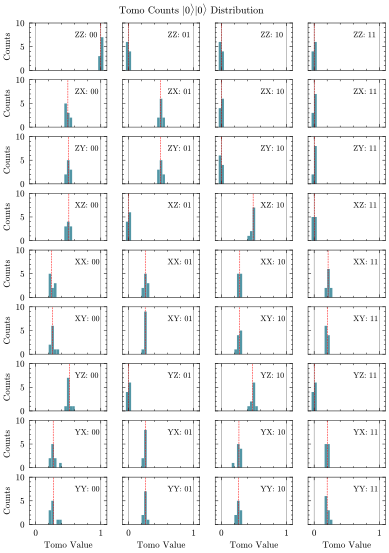

In [48]:
for i, init_state in enumerate(n_tomo_corrected_dict.keys()):
    if i > 0: break
    init_state_title = ''
    for c in init_state:
        if c != '>': init_state_title += c
        else: init_state_title += '\\rangle'
    print('init_state', init_state)
    print(n_tomo_corrected_dict[init_state])
    tomo_analysis.show_n_tomo_distributions(
        n_tomo_list=all_n_tomo_corrected_dict[init_state],
        title_label=f"${init_state_title}$",
    )

init state (Q0 (switch) Q1 (input)): |0>|0>
Fidelity (with ZZ correction): 0.984621962599281
Purity (with ZZ correction): 0.9721833169734174
Target purity: 1.0
[[ 9.84620876e-01-1.16394072e-18j  4.67102715e-03-8.48125640e-03j
   1.38146160e-02-2.47242767e-02j -1.28200834e-02+1.37477792e-02j]
 [ 4.67102715e-03+8.48125640e-03j  6.78981646e-03-1.08807226e-18j
  -6.34814630e-03+2.38634773e-03j -2.04506238e-04+1.69183837e-04j]
 [ 1.38146160e-02+2.47242767e-02j -6.34814630e-03-2.38634773e-03j
   8.22347144e-03-1.20316339e-18j -4.23704167e-04-3.32247877e-04j]
 [-1.28200834e-02-1.37477792e-02j -2.04506238e-04-1.69183837e-04j
  -4.23704167e-04+3.32247877e-04j  3.65836431e-04-1.56496400e-21j]]


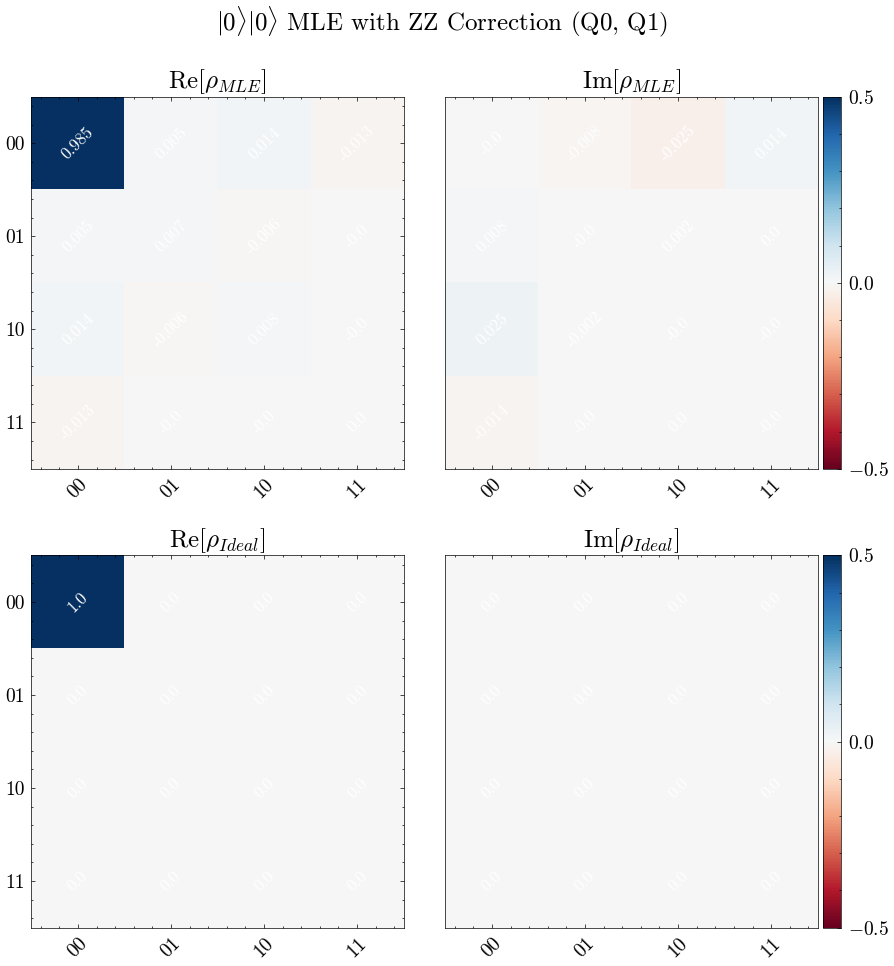


init state (Q0 (switch) Q1 (input)): |0>|1>
Fidelity (with ZZ correction): 0.9457312337197409
Purity (with ZZ correction): 0.9014153755528203
Target purity: 1.0
[[0.03156461-6.48725228e-18j 0.01210168-9.69957036e-03j
  0.00237011-3.93710795e-03j 0.01062627-2.29512499e-02j]
 [0.01210168+9.69957036e-03j 0.94573123+1.36479589e-16j
  0.04043702-1.07174707e-02j 0.00321661-1.10418727e-02j]
 [0.00237011+3.93710795e-03j 0.04043702+1.07174707e-02j
  0.00233947+1.68529714e-19j 0.00339588-7.06678948e-04j]
 [0.01062627+2.29512499e-02j 0.00321661+1.10418727e-02j
  0.00339588+7.06678948e-04j 0.02036469-4.19550715e-18j]]


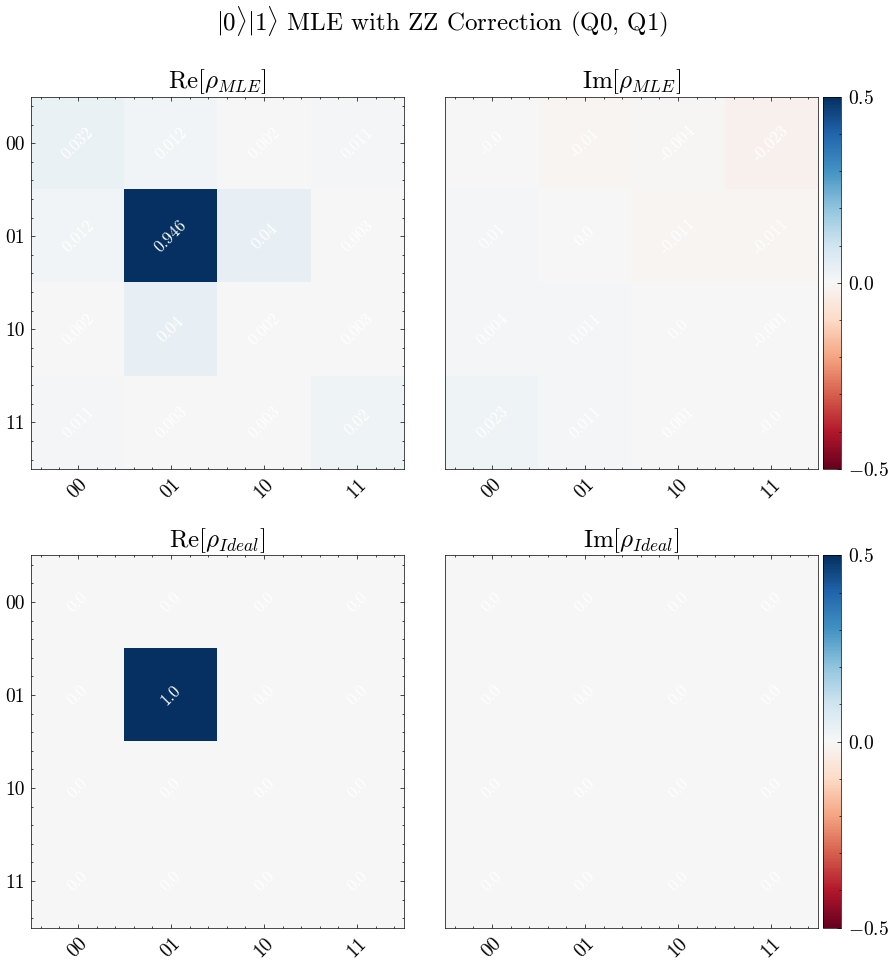


init state (Q0 (switch) Q1 (input)): |0>|0+1>
Fidelity (with ZZ correction): 0.975269919553897
Purity (with ZZ correction): 0.9552555179107355
Target purity: 0.9999999999999996
[[ 0.49334732+8.17226858e-20j  0.48214044-6.96155944e-03j
   0.01677744-1.57790348e-02j  0.01490382-4.60102365e-03j]
 [ 0.48214044+6.96155944e-03j  0.49291029+9.83959448e-20j
   0.01664905-2.80017427e-02j  0.00494986-1.99664715e-03j]
 [ 0.01677744+1.57790348e-02j  0.01664905+2.80017427e-02j
   0.00867326-3.62806034e-19j -0.00071663-5.41475976e-03j]
 [ 0.01490382+4.60102365e-03j  0.00494986+1.99664715e-03j
  -0.00071663+5.41475976e-03j  0.00506913-2.48253882e-19j]]


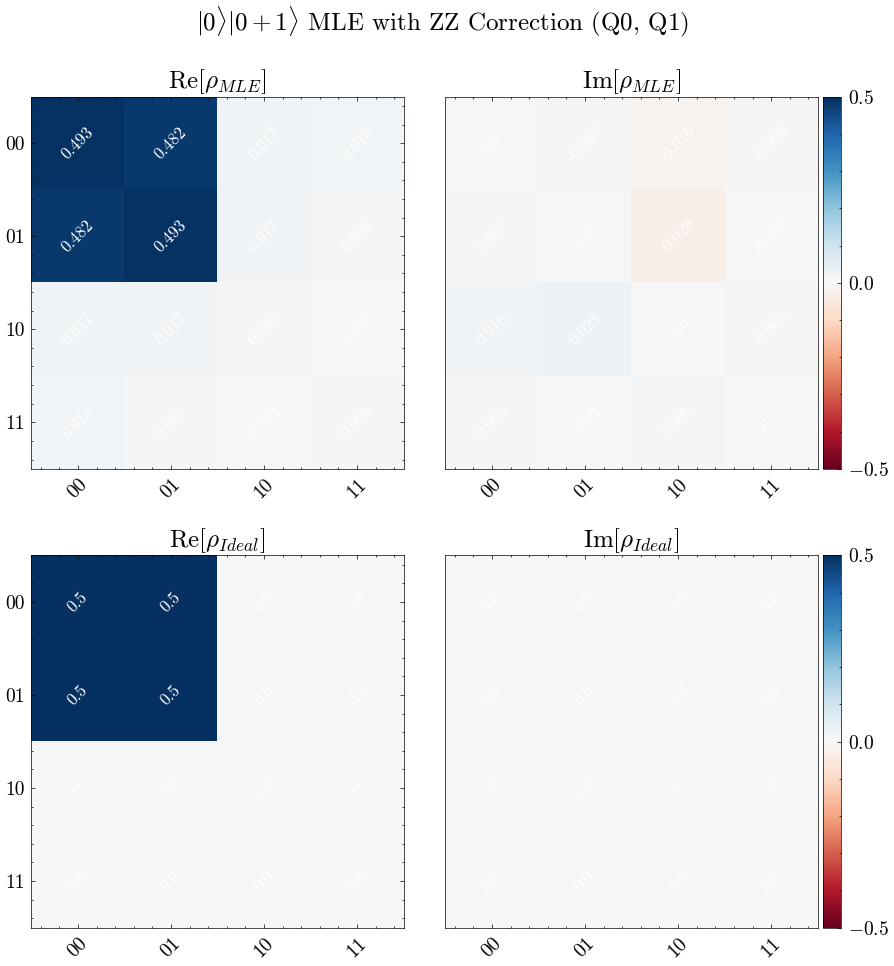


init state (Q0 (switch) Q1 (input)): |0>|0+i>
Fidelity (with ZZ correction): 0.969478053852359
Purity (with ZZ correction): 0.9476090406229472
Target purity: 0.9999999999999996
[[ 0.48981666-2.22493655e-17j -0.01224679-4.78574108e-01j
   0.00166595-2.66947558e-02j -0.0076507 -3.14125554e-02j]
 [-0.01224679+4.78574108e-01j  0.49199121-2.23228901e-17j
   0.03739245-3.06388318e-03j  0.01696978-7.44666084e-03j]
 [ 0.00166595+2.66947558e-02j  0.03739245+3.06388318e-03j
   0.00800071-4.31609133e-18j -0.00470055-3.97482138e-03j]
 [-0.0076507 +3.14125554e-02j  0.01696978+7.44666084e-03j
  -0.00470055+3.97482138e-03j  0.01019143-6.44055747e-18j]]


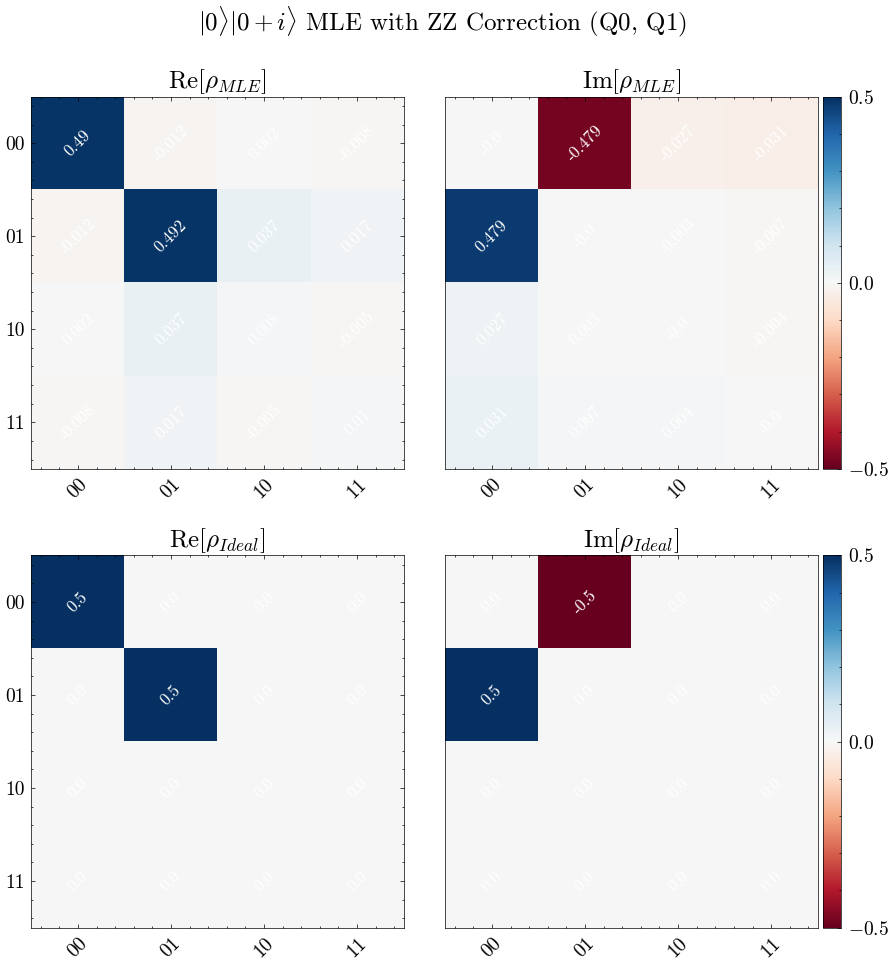


init state (Q0 (switch) Q1 (input)): |1>|0>
Fidelity (with ZZ correction): 0.970468251568702
Purity (with ZZ correction): 0.9888575364320118
Target purity: 1.0
[[ 0.02013386-3.54047042e-19j  0.00328519+3.33230019e-03j
  -0.13024093-9.21088071e-03j -0.01057351+5.14552795e-03j]
 [ 0.00328519-3.33230019e-03j  0.00161865-2.28278963e-20j
  -0.02955226+2.45030465e-02j -0.00097627+1.90144807e-03j]
 [-0.13024093+9.21088071e-03j -0.02955226-2.45030465e-02j
   0.97046824-9.53822213e-18j  0.06158712-2.84818838e-02j]
 [-0.01057351-5.14552795e-03j -0.00097627-1.90144807e-03j
   0.06158712+2.84818838e-02j  0.00777925-2.66460516e-19j]]


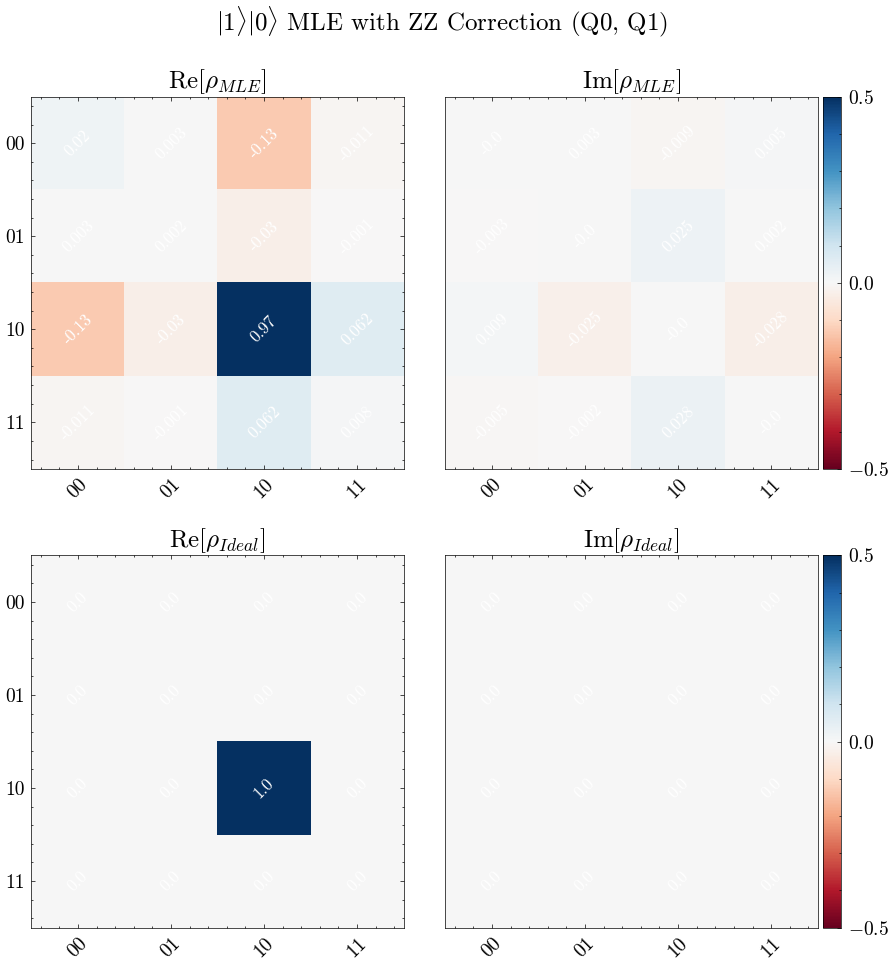


init state (Q0 (switch) Q1 (input)): |1>|1>
Fidelity (with ZZ correction): 0.9226376730675417
Purity (with ZZ correction): 0.8884635410598415
Target purity: 1.0
[[ 5.95177037e-03-3.99329726e-19j -7.89950074e-04-1.84322789e-03j
  -8.80294357e-03+5.50027026e-03j  4.57193949e-02-5.67029151e-02j]
 [-7.89950074e-04+1.84322789e-03j  2.96435372e-02-9.65810144e-19j
   2.02475676e-02-1.93804448e-02j  3.18180593e-02-4.82381118e-04j]
 [-8.80294357e-03-5.50027026e-03j  2.02475676e-02+1.93804448e-02j
   4.17670216e-02-1.73353511e-18j -9.32543907e-02+3.68848576e-02j]
 [ 4.57193949e-02+5.67029151e-02j  3.18180593e-02+4.82381118e-04j
  -9.32543907e-02-3.68848576e-02j  9.22637671e-01-6.28386260e-17j]]


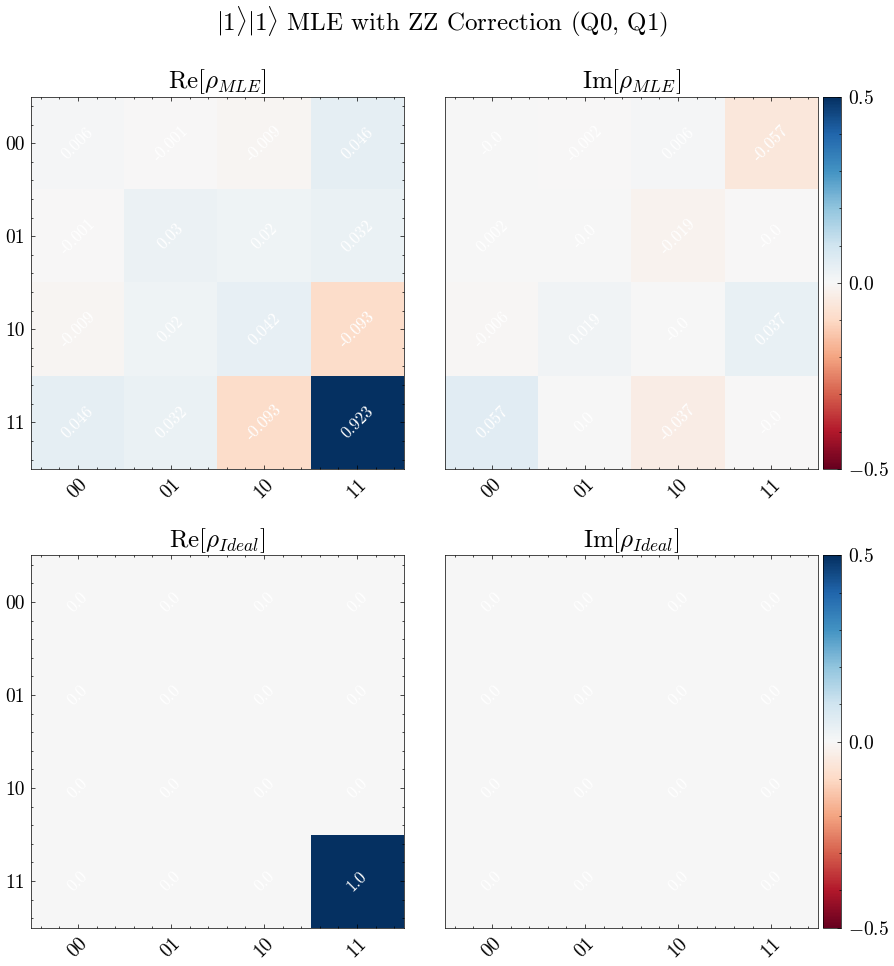


init state (Q0 (switch) Q1 (input)): |1>|0+1>
Fidelity (with ZZ correction): 0.8939595955343851
Purity (with ZZ correction): 0.8705798971905113
Target purity: 0.9999999999999996
[[ 0.01430387+8.44191712e-19j -0.00550598-3.18161325e-03j
  -0.07538988+2.02308867e-02j -0.04657148+3.87089347e-02j]
 [-0.00550598+3.18161325e-03j  0.01052345-1.87993246e-20j
   0.03364951-8.19192225e-03j  0.03154457+1.22703102e-02j]
 [-0.07538988-2.02308867e-02j  0.03364951+8.19192225e-03j
   0.47158878+3.89881286e-17j  0.40637324-1.40893723e-01j]
 [-0.04657148-3.87089347e-02j  0.03154457-1.22703102e-02j
   0.40637324+1.40893723e-01j  0.50358391+4.17105478e-17j]]


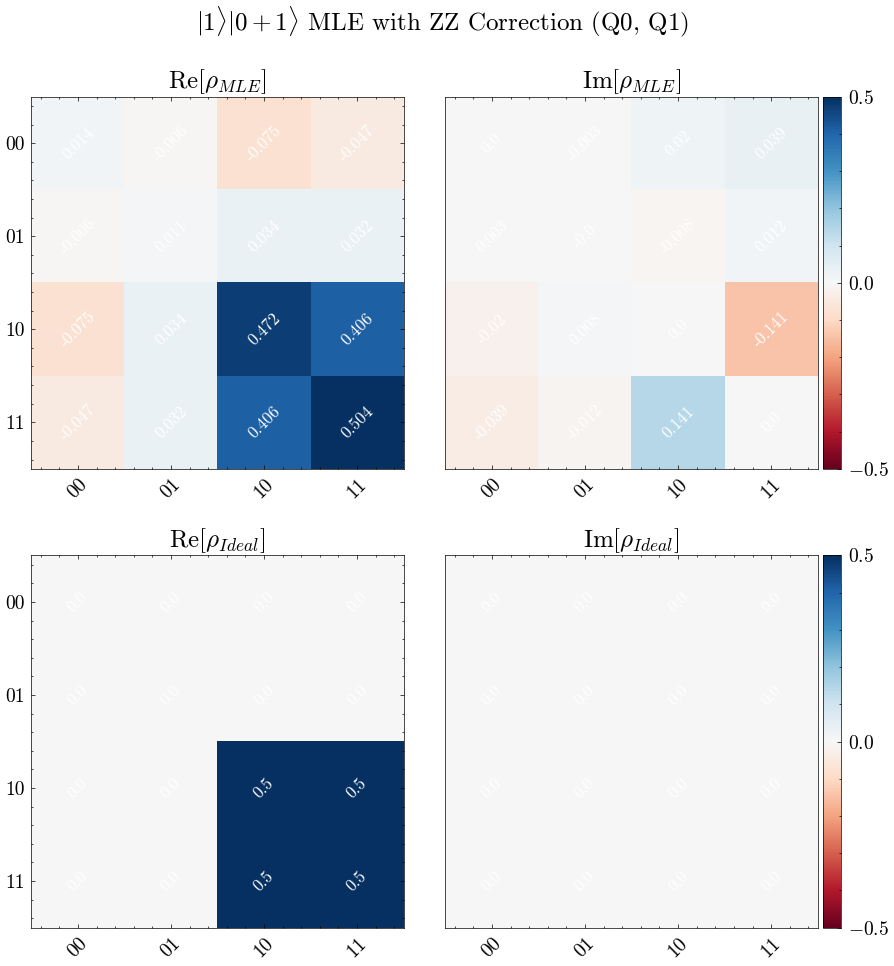


init state (Q0 (switch) Q1 (input)): |1>|0+i>
Fidelity (with ZZ correction): 0.9062992431134974
Purity (with ZZ correction): 0.9373707424769805
Target purity: 0.9999999999999996
[[ 1.97524150e-02-1.14796771e-18j -2.16558159e-03+4.60792840e-03j
   6.92527415e-03+6.36120570e-02j  5.97503882e-02-5.06613199e-02j]
 [-2.16558159e-03-4.60792840e-03j  1.41717833e-02-8.36096514e-19j
   6.13482400e-02+2.62122914e-02j -1.50101491e-04-5.29380979e-02j]
 [ 6.92527415e-03-6.36120570e-02j  6.13482400e-02-2.62122914e-02j
   4.75219407e-01-1.22921858e-17j -1.95813111e-01-4.23261321e-01j]
 [ 5.97503882e-02+5.06613199e-02j -1.50101491e-04+5.29380979e-02j
  -1.95813111e-01+4.23261321e-01j  4.90856394e-01-1.26471815e-17j]]


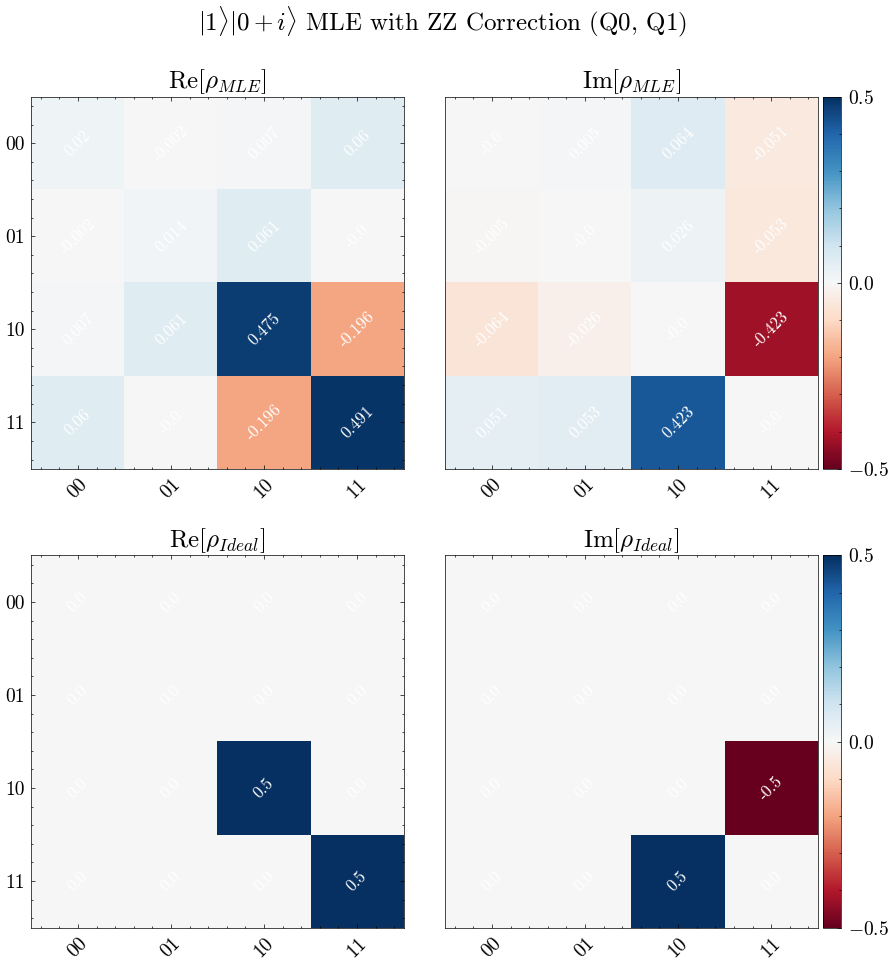


init state (Q0 (switch) Q1 (input)): |0+1>|0>
Fidelity (with ZZ correction): 0.9683325549499283
Purity (with ZZ correction): 0.9460336228588488
Target purity: 0.9999999999999996
[[0.49883957-5.51310928e-19j 0.00622725-4.99056452e-03j
  0.47537062+5.16466562e-02j 0.01273507+1.45923919e-02j]
 [0.00622725+4.99056452e-03j 0.00499334-1.96653538e-18j
  0.00526321+1.72230863e-02j 0.00543396+3.64845454e-03j]
 [0.47537062-5.16466562e-02j 0.00526321-1.72230863e-02j
  0.48708429-5.27161762e-19j 0.02158753-6.90397301e-04j]
 [0.01273507-1.45923919e-02j 0.00543396-3.64845454e-03j
  0.02158753+6.90397301e-04j 0.00908279-3.51461966e-18j]]


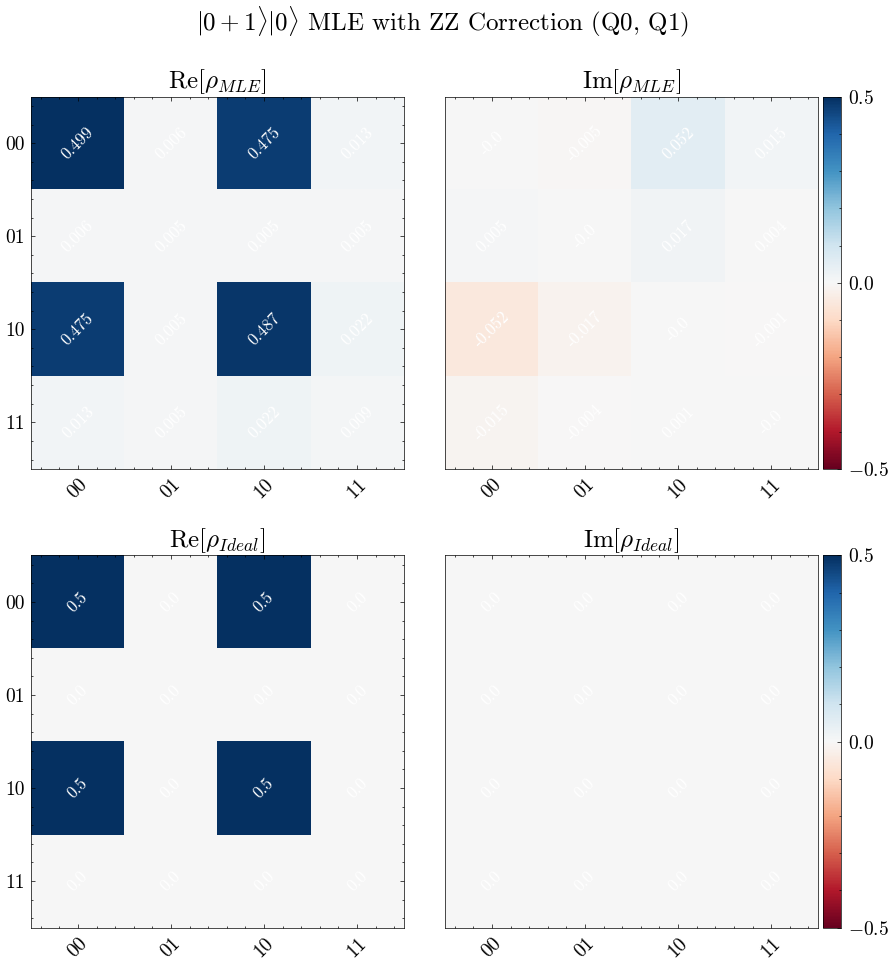


init state (Q0 (switch) Q1 (input)): |0+1>|1>
Fidelity (with ZZ correction): 0.959905480062003
Purity (with ZZ correction): 0.9357960847401837
Target purity: 0.9999999999999996
[[ 0.00379987+1.28255631e-18j -0.01169892-3.64159944e-03j
   0.00557822-4.06281291e-03j -0.02205243+1.12350908e-04j]
 [-0.01169892+3.64159944e-03j  0.48570102-6.86581121e-18j
  -0.01974454-2.27354558e-02j  0.46996484-6.20617728e-02j]
 [ 0.00557822+4.06281291e-03j -0.01974454+2.27354558e-02j
   0.01631885+5.68723864e-18j -0.03462787+1.37602594e-02j]
 [-0.02205243-1.12350908e-04j  0.46996484+6.20617728e-02j
  -0.03462787-1.37602594e-02j  0.49418026-7.47488881e-18j]]


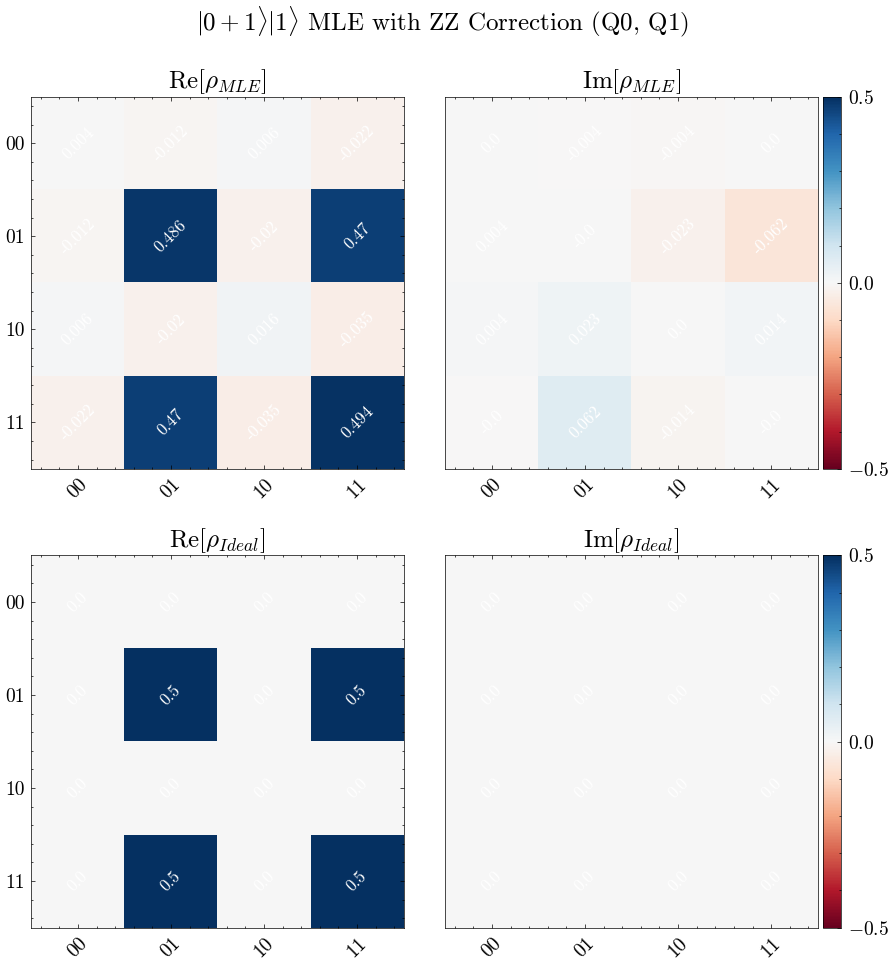


init state (Q0 (switch) Q1 (input)): |0+1>|0+1>
Fidelity (with ZZ correction): 0.9244145038813952
Purity (with ZZ correction): 0.9765652559412892
Target purity: 0.9999999999999991
[[0.26350152-4.05159368e-18j 0.24934234+2.15773532e-02j
  0.2399811 +3.98560960e-02j 0.22879086-1.23561029e-01j]
 [0.24934234-2.15773532e-02j 0.24543313-1.17305780e-18j
  0.23352319+9.95096723e-03j 0.20700255-1.35897504e-01j]
 [0.2399811 -3.98560960e-02j 0.23352319-9.95096723e-03j
  0.23441467+7.93778087e-19j 0.19018895-1.46581557e-01j]
 [0.22879086+1.23561029e-01j 0.20700255+1.35897504e-01j
  0.19018895+1.46581557e-01j 0.25665068-4.31730356e-18j]]


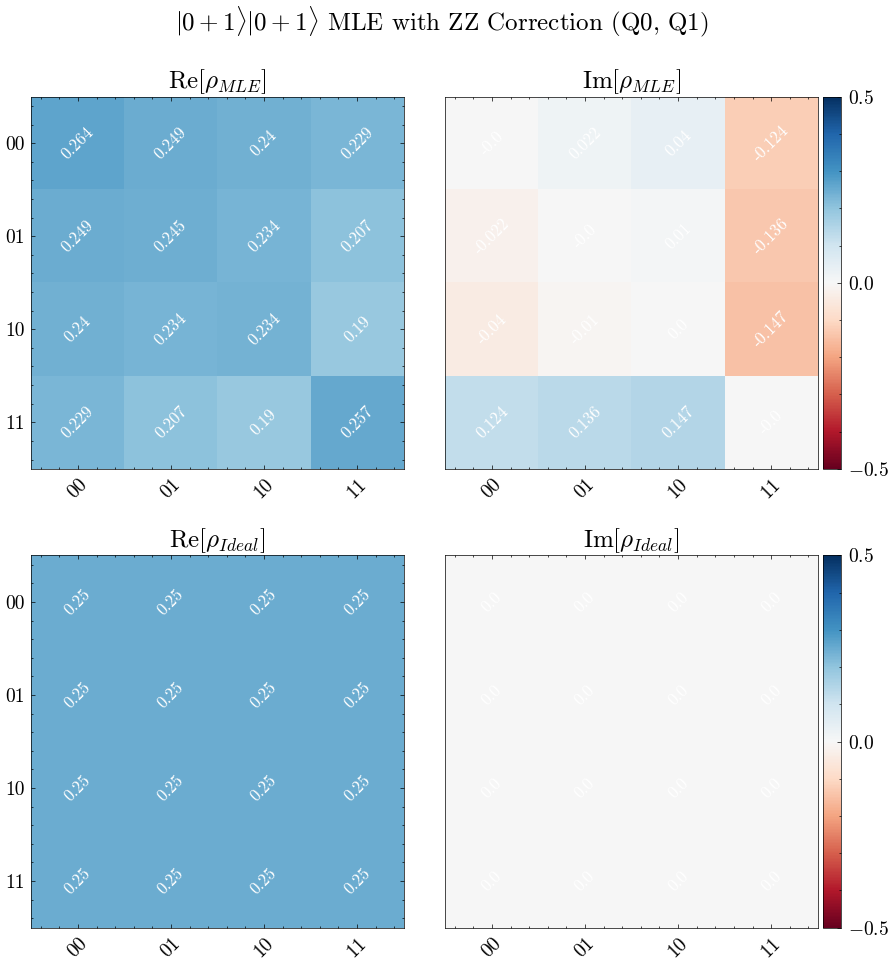


init state (Q0 (switch) Q1 (input)): |0+1>|0+i>
Fidelity (with ZZ correction): 0.9079002738353303
Purity (with ZZ correction): 0.9475113128996255
Target purity: 0.9999999999999991
[[ 0.23107707+5.90103506e-19j  0.01470186-2.38863141e-01j
   0.22780145+3.99479576e-02j -0.1124685 -2.12278464e-01j]
 [ 0.01470186+2.38863141e-01j  0.25682889-4.40967306e-18j
  -0.01265811+2.41285439e-01j  0.20452958-1.32325628e-01j]
 [ 0.22780145-3.99479576e-02j -0.01265811-2.41285439e-01j
   0.25493423-4.37274642e-18j -0.16070027-1.91042433e-01j]
 [-0.1124685 +2.12278464e-01j  0.20452958+1.32325628e-01j
  -0.16070027+1.91042433e-01j  0.25715982-6.05698793e-19j]]


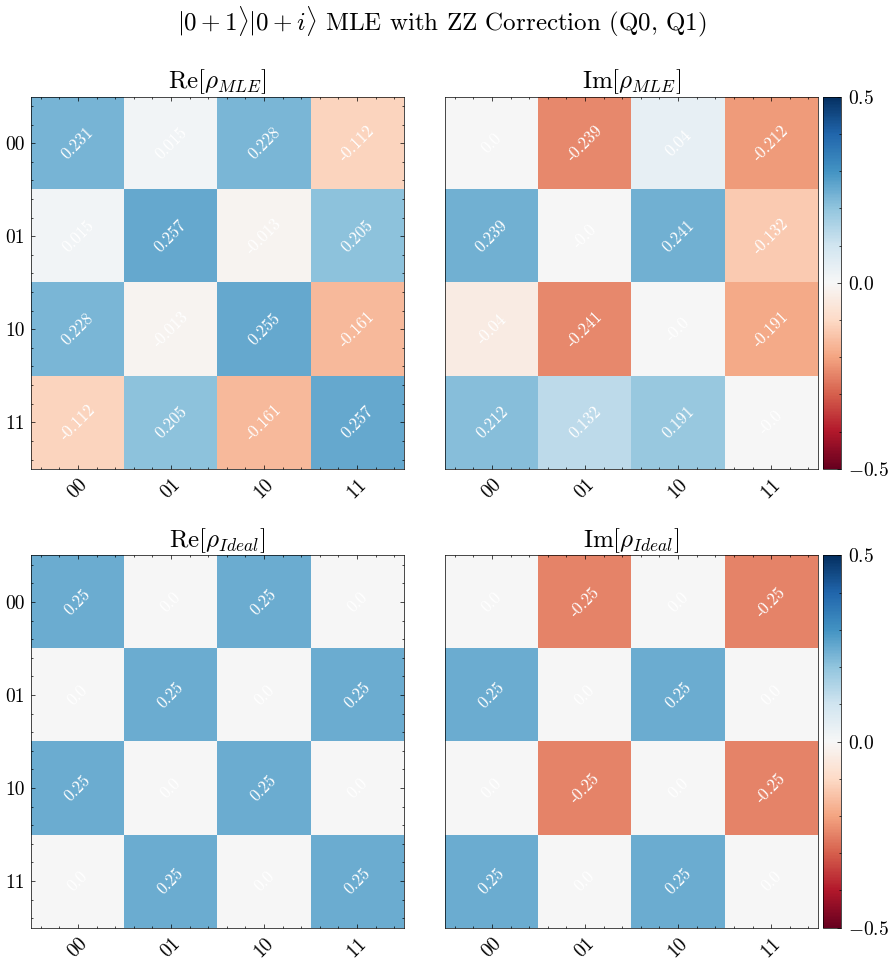


init state (Q0 (switch) Q1 (input)): |0+i>|0>
Fidelity (with ZZ correction): 0.9809716508055167
Purity (with ZZ correction): 0.9735423690475706
Target purity: 0.9999999999999996
[[ 4.93940659e-01-1.93411404e-18j -9.03395846e-03+1.03372716e-02j
   7.02605130e-02-4.85142389e-01j -7.95018640e-03-2.54914248e-03j]
 [-9.03395846e-03-1.03372716e-02j  1.51899943e-03-3.00680936e-19j
  -1.10660988e-02+3.84920299e-03j -1.69646712e-04-2.53128174e-03j]
 [ 7.02605130e-02+4.85142389e-01j -1.10660988e-02-3.84920299e-03j
   4.97717858e-01-1.91970363e-18j  9.86059494e-03-9.88646294e-03j]
 [-7.95018640e-03+2.54914248e-03j -1.69646712e-04+2.53128174e-03j
   9.86059494e-03+9.88646294e-03j  6.82248382e-03-1.65264186e-18j]]


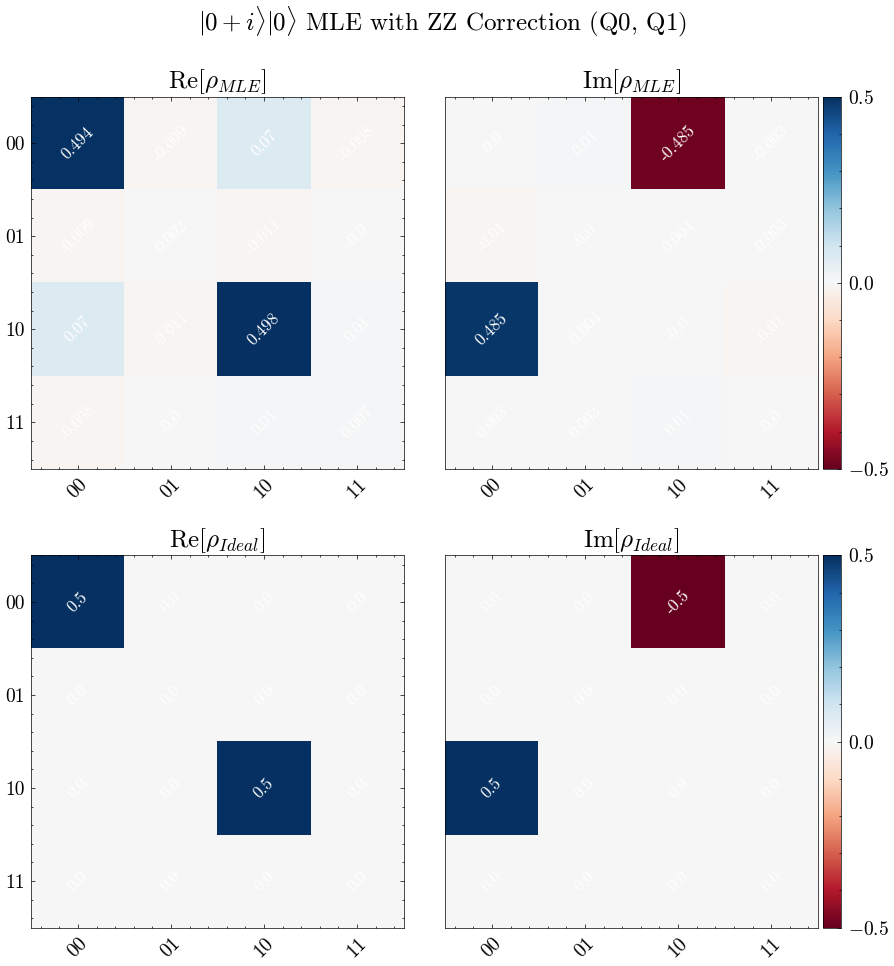


init state (Q0 (switch) Q1 (input)): |0+i>|1>
Fidelity (with ZZ correction): 0.9523580398133804
Purity (with ZZ correction): 0.9248287004885323
Target purity: 0.9999999999999996
[[ 0.01412874-3.53908489e-17j -0.00698489+1.33919051e-02j
  -0.0083901 -7.93938376e-03j  0.0353122 +3.12118695e-03j]
 [-0.00698489-1.33919051e-02j  0.48901291-2.77621460e-17j
   0.02394437+2.64528996e-02j -0.06388715-4.65158188e-01j]
 [-0.0083901 +7.93938376e-03j  0.02394437-2.64528996e-02j
   0.0114716 -2.39278219e-17j -0.03883552-5.34154037e-03j]
 [ 0.0353122 -3.12118695e-03j -0.06388715+4.65158188e-01j
  -0.03883552+5.34154037e-03j  0.48538675-2.40145434e-17j]]


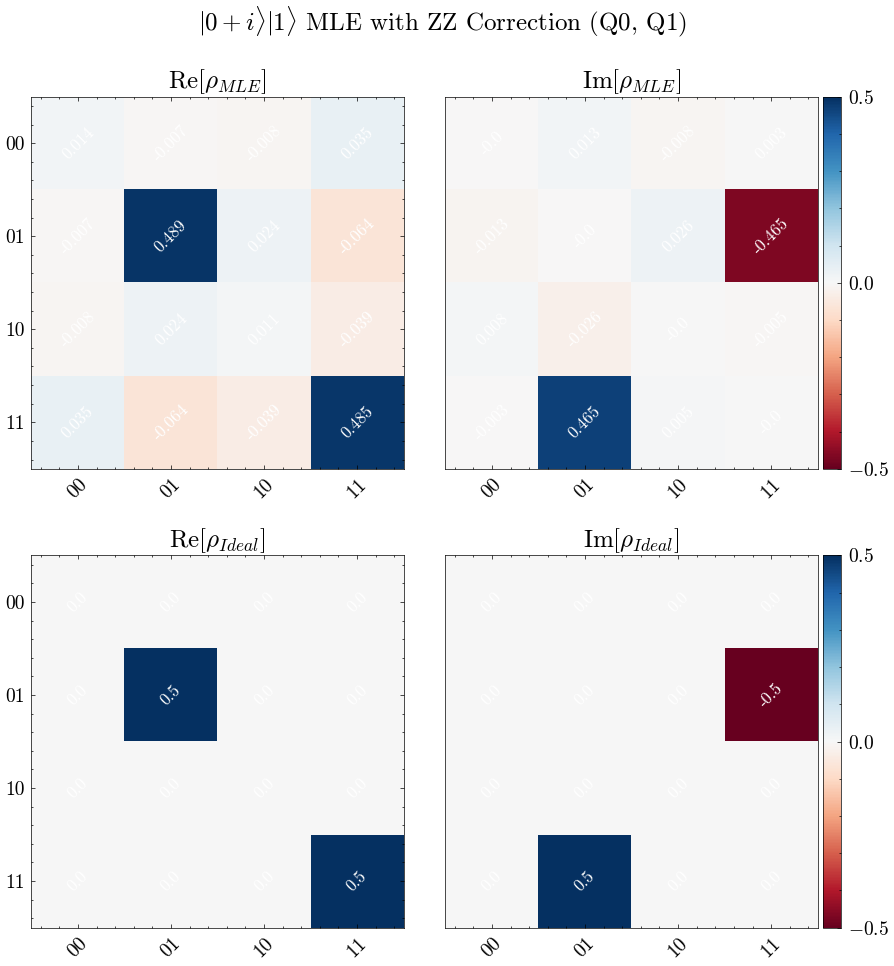


init state (Q0 (switch) Q1 (input)): |0+i>|0+1>
Fidelity (with ZZ correction): 0.9203530234524993
Purity (with ZZ correction): 0.9430278144958102
Target purity: 0.9999999999999991
[[ 0.24561357-2.84384812e-19j  0.24481842+7.20152097e-03j
   0.03818771-2.37768287e-01j -0.08854194-2.08373733e-01j]
 [ 0.24481842-7.20152097e-03j  0.25704835+8.83653354e-19j
   0.03933621-2.49025278e-01j -0.1135749 -2.15920301e-01j]
 [ 0.03818771+2.37768287e-01j  0.03933621+2.49025278e-01j
   0.25070125+2.72563857e-19j  0.18480003-1.41426542e-01j]
 [-0.08854194+2.08373733e-01j -0.1135749 +2.15920301e-01j
   0.18480003+1.41426542e-01j  0.24663683-9.17932426e-19j]]


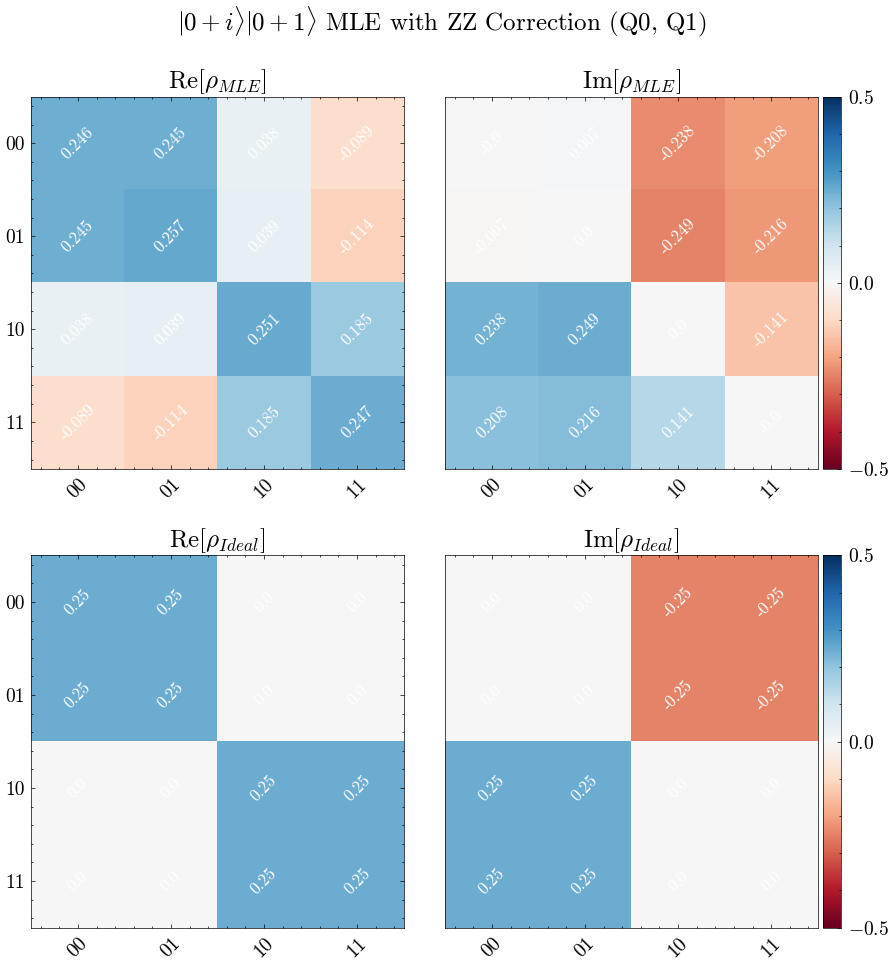


init state (Q0 (switch) Q1 (input)): |0+i>|0+i>
Fidelity (with ZZ correction): 0.9209953724362491
Purity (with ZZ correction): 0.9528004925520285
Target purity: 0.9999999999999991
[[ 0.2416237 -3.00331477e-17j  0.00726852-2.48428651e-01j
   0.04278834-2.28233643e-01j -0.2033073 +9.18369445e-02j]
 [ 0.00726852+2.48428651e-01j  0.2667541 -2.00559173e-17j
   0.25239612+4.34595602e-02j -0.11401459-2.20484665e-01j]
 [ 0.04278834+2.28233643e-01j  0.25239612-4.34595602e-02j
   0.25112025-2.27035423e-17j -0.1508003 -1.89140311e-01j]
 [-0.2033073 -9.18369445e-02j -0.11401459+2.20484665e-01j
  -0.1508003 +1.89140311e-01j  0.24050195-2.49246798e-17j]]


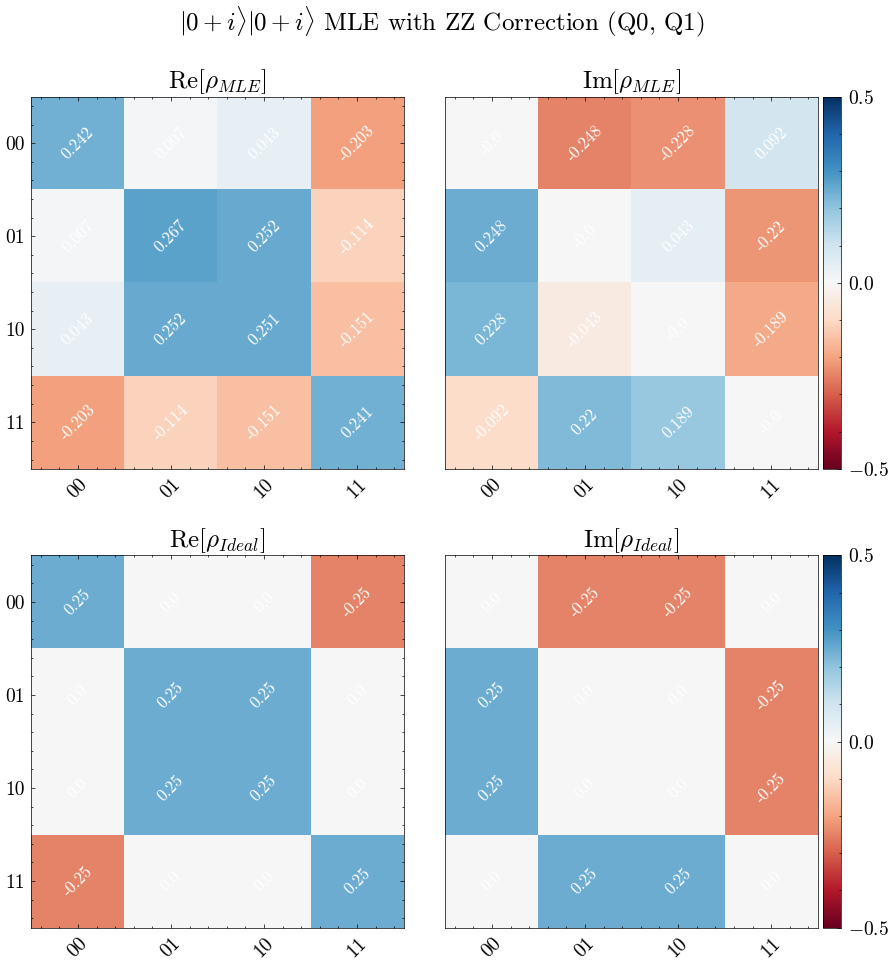

In [50]:
fidelities_ZZ = []
purities_ZZ = []
rho_MLE_ZZ_dict = dict()
init_states = []
for init_state in n_tomo_corrected_dict.keys():
    print('init state (Q0 (switch) Q1 (input)):', init_state)
    n_tomo_corrected = n_tomo_corrected_dict[init_state]
    init_states.append(init_state)
    
    rho_id = qt.ket2dm(name_to_state_2q(init_state))
    
    rho_MLE_ZZ = tomo_analysis.get_rho_from_counts(
        n_tomo_raw=n_tomo_corrected,
        n_calib=None,
        correct_readout=False,
        correct_neg_counts=True,
        method='analytical',
        ZZ_correction=use_ZZ_mat,
        evol_mats=None if not use_ZZ_mat else evol_mats
    )

    
    fid_ZZ = qt.fidelity(qt.Qobj(rho_MLE_ZZ, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
    purity_ZZ = np.real(np.trace(rho_MLE_ZZ @ rho_MLE_ZZ))
    purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
    print(f'Fidelity (with{"out" if not use_ZZ_mat else ""} ZZ correction): {fid_ZZ}')
    print(f'Purity (with{"out" if not use_ZZ_mat else ""} ZZ correction): {purity_ZZ}')
    print(f'Target purity: {purity_id}')
    
    # savetitle=saved_file[:-3]+'_ZZcorrect.svg'
    savetitle=None
    
    init_state_title = ''
    for c in init_state:
        if c != '>': init_state_title += c
        else: init_state_title += '\\rangle'
    print(rho_MLE_ZZ)
    tomo_analysis.show_plot_rho_2d(rho_MLE_ZZ, rho_id, title=f'${init_state_title}$ MLE {"with ZZ Correction" if use_ZZ_mat else ""} (Q{tomo_qubits[0]}, Q{tomo_qubits[1]})', savetitle=savetitle, cmax=0.5)
    
    fidelities_ZZ.append(fid_ZZ)
    purities_ZZ.append(purity_ZZ)
    rho_MLE_ZZ_dict.update({init_state:rho_MLE_ZZ})
    print()
    # print('\n\n\n')

In [51]:
print('init_states to be saved', rho_MLE_ZZ_dict.keys())
print('ZZ correction fidelities\n', fidelities_ZZ)
print('purities (ZZ correction)\n', purities_ZZ)

init_states to be saved dict_keys(['|0>|0>', '|0>|1>', '|0>|0+1>', '|0>|0+i>', '|1>|0>', '|1>|1>', '|1>|0+1>', '|1>|0+i>', '|0+1>|0>', '|0+1>|1>', '|0+1>|0+1>', '|0+1>|0+i>', '|0+i>|0>', '|0+i>|1>', '|0+i>|0+1>', '|0+i>|0+i>'])
ZZ correction fidelities
 [0.984621962599281, 0.9457312337197409, 0.975269919553897, 0.969478053852359, 0.970468251568702, 0.9226376730675417, 0.8939595955343851, 0.9062992431134974, 0.9683325549499283, 0.959905480062003, 0.9244145038813952, 0.9079002738353303, 0.9809716508055167, 0.9523580398133804, 0.9203530234524993, 0.9209953724362491]
purities (ZZ correction)
 [0.9721833169734174, 0.9014153755528203, 0.9552555179107355, 0.9476090406229472, 0.9888575364320118, 0.8884635410598415, 0.8705798971905113, 0.9373707424769805, 0.9460336228588488, 0.9357960847401837, 0.9765652559412892, 0.9475113128996255, 0.9735423690475706, 0.9248287004885323, 0.9430278144958102, 0.9528004925520285]


In [52]:
# SAVING MEASURED DENSITY MATRICES
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d%H%M")
q0, q1 = tomo_qubits
rho_MLE_ZZ_2Q_filepath = os.path.join(expt_path, f'{timestamp}_init_rhoMLE_ZZ_2Q_{q0}{q1}.npz')
np.savez(rho_MLE_ZZ_2Q_filepath, **rho_MLE_ZZ_dict)
print(f'Saved rho_MLE_ZZ for Q{q0} Q{q1} to file {rho_MLE_ZZ_2Q_filepath}')

Saved rho_MLE_ZZ for Q0 Q1 to file S:\QRAM\qram_4QR2\data\data_250119\202502111059_init_rhoMLE_ZZ_2Q_01.npz


In [99]:
print()

In [277]:
# RETREIVE SAVED MEASURED DENSITY MATRICES AND CHECK WHAT EXPECTED QRAM STATE IS
q0, q1 = tomo_qubits
rho_MLE_ZZ_2Q_filepath = 'S:\QRAM\qram_4QR2\data\data_241025\\202411051014_init_rhoMLE_ZZ_2Q_01.npz'
print(f'Using rho_MLE_ZZ for Q{q0} Q{q1} from file {rho_MLE_ZZ_2Q_filepath}')

test_rho_MLE_ZZ_dict = dict()
with np.load(rho_MLE_ZZ_2Q_filepath) as npzfile:
    for key in npzfile.keys():
        test_rho_MLE_ZZ_dict.update({key:npzfile[key]})
print(f'rho_MLE_ZZ retrieved with init_states {test_rho_MLE_ZZ_dict.keys()}')

init_state = '|1>|1>'
init_rho = test_rho_MLE_ZZ_dict[init_state]
get_qram_qSLR_state_from_rho(init_rho, output_qubits=[2, 3])

Using rho_MLE_ZZ for Q0 Q1 from file S:\Connie\experiments\qramLL_4QR2\data\data_240218\202402281619_init_rhoMLE_ZZ_2Q_01.npz


FileNotFoundError: [Errno 2] No such file or directory: 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240218\\202402281619_init_rhoMLE_ZZ_2Q_01.npz'

## Run analysis

### Reopen old data

In [19]:
apply_ps = False
ps_adjust = [-0.3, -1.0, -0.3, -0.3]
# ps_adjust = [np.inf]*4
ps_qubits = [0, 1, 2, 3]

In [53]:
filename = 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00010_qram_protocol.h5'
data, attrs = prev_data(filename, None)
pulse_dict = attrs['pulse_dict']
saved_files = [filename]

print(data.keys())
# # data = None
# # style.use('default')
# # qramExpt.analyze(data=data)
# # qramExpt.display(data=data, err=False, saveplot=True)
# # print(data)

cfg = AttrDict(attrs['config'])
# print(cfg.device.readout)
init_state = cfg.expt.init_state
tomo_qubits = cfg.expt.tomo_qubits
play_pulses = cfg.expt.play_pulses
print('init_state', init_state)
print('tomo_qubits', tomo_qubits)
print('play_pulses', play_pulses)

n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(data, cfg, ps_adjust=ps_adjust, ps_qubits=ps_qubits, apply_ps=apply_ps, verbose=True)

print('calib_order', attrs['calib_order'])
print('meas_order', attrs['meas_order'])
print('counts_calib')
n_calib = n_calib.astype(np.float64)
for r in range(n_calib.shape[0]):
    n_calib[r,:]/=np.sum(n_calib[r,:])
print(n_calib)

print('n_tomo_raw')
n_tomo_raw = n_tomo_raw.astype(np.float64)
for r in range(n_tomo_raw.shape[0]):
    n_tomo_raw[r,:]/=np.sum(n_tomo_raw[r,:])
print(n_tomo_raw)

print('n tomo corrected')
print(np.around(tomo_analysis.correct_readout_err(n_tomo_raw, n_calib), decimals=10))

S:\QRAM\qram_4QR2\data\data_250119\00010_qram_protocol.h5


 C:\Users\slab\AppData\Local\Temp\ipykernel_30876\2316176076.py: 13

Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
dict_keys(['amps', 'angles', 'avgi', 'avgi_err', 'avgq', 'avgq_err', 'calib_ishots_raw', 'calib_qshots_raw', 'counts_calib', 'counts_tomo', 'ge_avgs', 'ishots_raw', 'phases', 'qshots_raw', 'thresholds', 'xpts'])
init_state |0+1>|0+1>
tomo_qubits [0, 1]
play_pulses [0]
calib_order ['gg', 'ge', 'eg', 'ee']
meas_order ['ZZ', 'ZX', 'ZY', 'XZ', 'XX', 'XY', 'YZ', 'YX', 'YY']
counts_calib
[[0.5452 0.0414 0.3814 0.032 ]
 [0.1487 0.4301 0.0792 0.342 ]
 [0.3172 0.0207 0.6082 0.0539]
 [0.1072 0.2085 0.1228 0.5615]]
n_tomo_raw
[[0.29352 0.17084 0.30034 0.2353 ]
 [0.3942  0.05658 0.42978 0.11944]
 [0.3098  0.14454 0.40098 0.14468]
 [0.33204 0.23036 0.23798 0.19962]
 [0.49178 0.06906 0.35398 0.08518]
 [0.39754 0.17354 0.27462 0.1543 ]
 [0.26518 0.2099  0.30874 0.21618]
 [0.40422 0.06956 0.4103  0.11592]
 [0.3351  0.1291  0.39644 0.13936]]
n tomo corrected
[[ 0.29015491  0.24658748  0.23332747  0.22993014]
 [ 0.47172799 -0

### Set ideal rho

Get final qram state from an arbitrary 2Q input density matrix

In [54]:
print('init state Q0 (switch) Q1 (input):', init_state)

init_rho = qt.ket2dm(name_to_state_2q(init_state))
rho_id = init_rho

# print('play_pulses', play_pulses)
# assert (np.all([q in [0, 2, 3] for q in tomo_qubits]) and play_pulses==[2, 1, 4, 3]), 'Automatic ideal rho calculation not available'
# init_rho = init_rho.full()
# rho_id = get_qram_qSLR_state_from_rho(init_rho, output_qubits=tomo_qubits)
rho_id

init state Q0 (switch) Q1 (input): |0+1>|0+1>


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]

In [85]:
# rho_id = (qt.ket2dm(psi01) + qt.ket2dm(psi10)).unit()
# rho_id = qt.ket2dm((psi10 + psi11).unit())
# rho_id = qt.ket2dm((psi01 + psi11).unit())
# rho_id = qt.ket2dm((psi00 + psi10).unit())
# rho_id = qt.ket2dm((psi00 + psi01 + psi10 + psi11).unit())
# rho_id = qt.ket2dm((psi00+psi01).unit())
rho_id = qt.ket2dm((psi10).unit())

### Generate test data

In [246]:
rho_id = qt.ket2dm(psi00 + psi01).unit()

n_tomo_raw = tomo_analysis.generate_counts(rho_id=rho_id, n_tot=20000, evol_mats=evol_mats, noise=None)
n_calib = qt.qeye(4).full()

Generating with evol mats


### Run MLE without ZZ correction

Fidelity (no ZZ correction): 0.8205262773722378
Purity (no ZZ correction): 0.8913074274349201
[[0.288+0.j    0.236+0.041j 0.2  +0.097j 0.248-0.143j]
 [0.236-0.041j 0.22 +0.j    0.157+0.033j 0.182-0.146j]
 [0.2  -0.097j 0.157-0.033j 0.206+0.j    0.119-0.188j]
 [0.248+0.143j 0.182+0.146j 0.119+0.188j 0.285+0.j   ]]


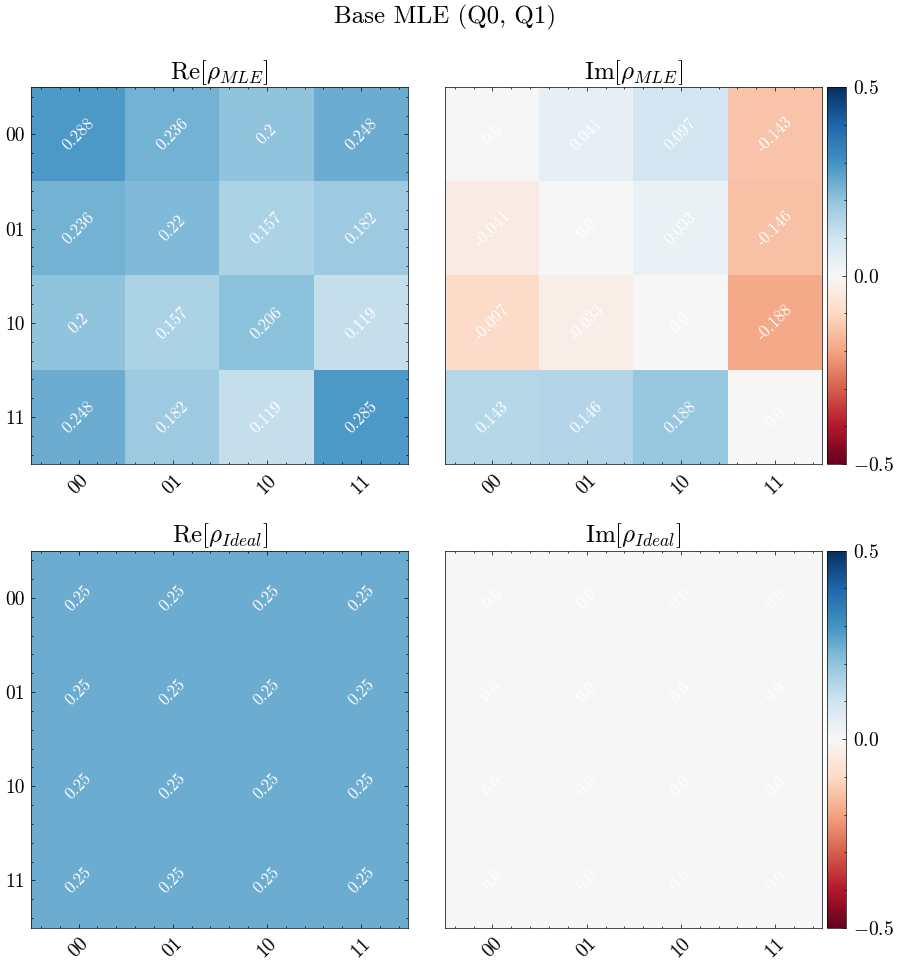

In [55]:
rho_MLE_base = tomo_analysis.get_rho_from_counts(
    n_tomo_raw=n_tomo_raw,
    n_calib=n_calib,
    correct_readout=True,
    correct_neg_counts=True,
    method='analytical',
    ZZ_correction=False,
    evol_mats=None
)

fid_base = qt.fidelity(qt.Qobj(rho_MLE_base, dims=id2q.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
purity_base = np.real(np.trace(rho_MLE_base @ rho_MLE_base))
print(f'Fidelity (no ZZ correction): {fid_base}')
print(f'Purity (no ZZ correction): {purity_base}')
print(np.around(rho_MLE_base, decimals=3))
tomo_analysis.show_plot_rho_2d(rho_MLE_base, rho_id, title=f'Base MLE (Q{tomo_qubits[0]}, Q{tomo_qubits[1]})', cmax=0.5)

### Run MLE with ZZ

#### Get evol mats for ZZ

In [ ]:
# Recover old config
# yaml_cfg = AttrDict(attrs['config'])

In [42]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [43]:
# evol_mats_path = os.path.join(os.getcwd(), 'evol_mats')
evol_mats_path = "S:\\QRAM\\qram_4QR2\\evol_mats"
print('Will save evol mats to path', evol_mats_path)

q0, q1 = tomo_qubits
evol_mats_filename = f'evol_mats_{q0}{q1}_old.npz'
# evol_mats_filename = f'evol_mats_{q0}{q1}.npz'

# evol_mats_filename += '_test'
print('Will save to filename', evol_mats_filename)

Will save evol mats to path S:\QRAM\qram_4QR2\evol_mats
Will save to filename evol_mats_01_old.npz


In [45]:
evol_mats = tomo_analysis.get_evol_mats_from_yaml(
    tomo_qubits=tomo_qubits,
    yaml_cfg=yaml_cfg,
    pulse_dict=pulse_dict,
    cutoffs=[4]*(len(tomo_qubits)),
    soccfg=soc,
    debug=False,
    evol_mats_path=evol_mats_path,
    evol_mats_filename=evol_mats_filename,
)

TOMO QUBITS [0, 1]
HAMILTONIAN QUBITS [0 1]
qubit freqs [4108.77329807 3447.98291844]
alphas [-226.09720167 -100.47148453]
ZZs (MHz) [[ 0.         -5.38964365]
 [-5.40435151  0.        ]]
Will save to filename evol_mats_01_old.npz


  0%|          | 0/9 [00:00<?, ?it/s]

Y_robust_half_q1
X_robust_half_q1
Y_robust_half_q0
Y_robust_half_q1
Y_robust_half_q0
Y_robust_half_q1
Y_robust_half_q0
X_robust_half_q1
Y_robust_half_q0
X_robust_half_q1
Y_robust_half_q0
X_robust_half_q0
X_robust_half_q0
Y_robust_half_q1
X_robust_half_q0
Y_robust_half_q1
X_robust_half_q0
X_robust_half_q1
X_robust_half_q0
X_robust_half_q1
Saved evol mats to file S:\QRAM\qram_4QR2\evol_mats\evol_mats_01_old.npz


Reload evol mats

In [27]:
q0, q1 = tomo_qubits
evol_mats_file_path = os.path.join(evol_mats_path, evol_mats_filename)
print(f'Using evol mats from file {evol_mats_file_path}')

evol_mats = dict()
with np.load(evol_mats_file_path) as npzfile:
    for key in npzfile.keys():
        evol_mats.update({key:npzfile[key]})
# print(evol_mats)

Using evol mats from file S:\QRAM\qram_4QR2\evol_mats\evol_mats_01_old.npz


#### (Actually) run MLE with ZZ correction

init state |0+1>|0+1>
[[0.275-0.j    0.242+0.044j 0.219+0.067j 0.249-0.099j]
 [0.242-0.044j 0.235+0.j    0.201+0.03j  0.209-0.128j]
 [0.219-0.067j 0.201-0.03j  0.222+0.j    0.181-0.15j ]
 [0.249+0.099j 0.209+0.128j 0.181+0.15j  0.269+0.j   ]]
list format [[(0.275-0j), (0.242+0.044j), (0.219+0.067j), (0.249-0.099j)], [(0.242-0.044j), (0.235+0j), (0.201+0.03j), (0.209-0.128j)], [(0.219-0.067j), (0.201-0.03j), (0.222+0j), (0.181-0.15j)], [(0.249+0.099j), (0.209+0.128j), (0.181+0.15j), (0.269+0j)]]
Fidelity (with ZZ correction): 0.9001374903981183
Purity (with ZZ correction): 0.9339600426382734
Target purity: 0.9999999999999991


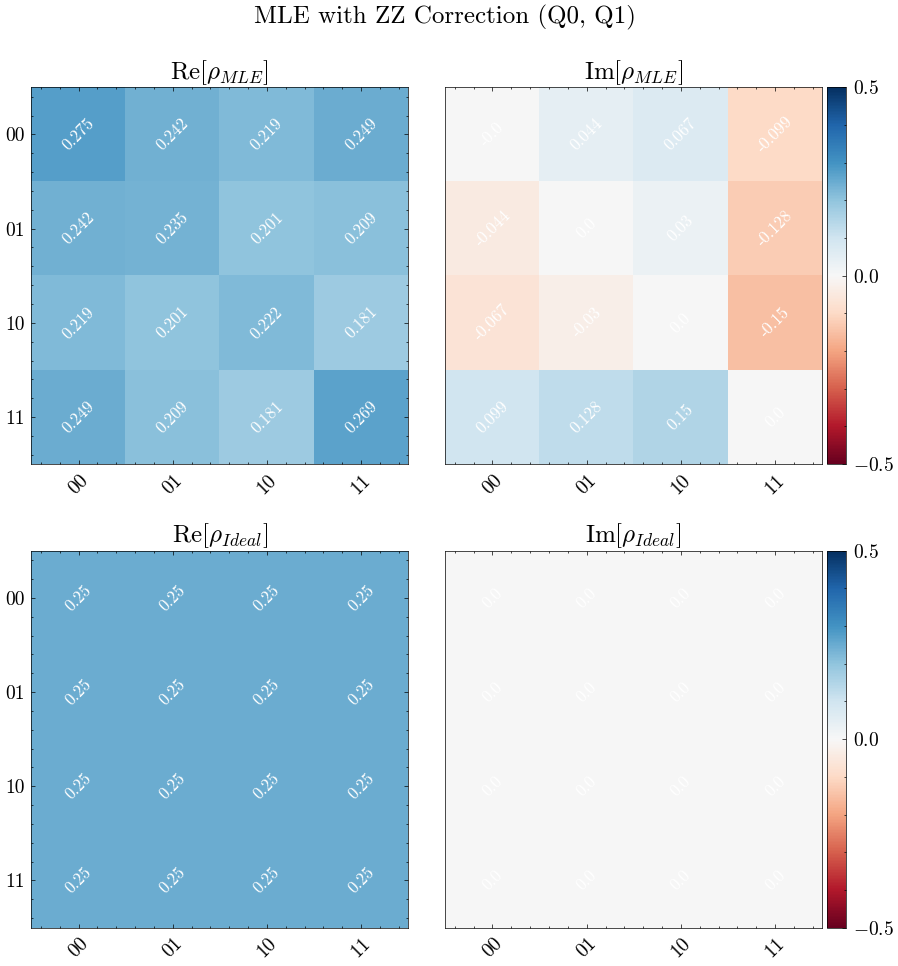

Saved svg: None
Saved data:
S:\QRAM\qram_4QR2\data\data_250119\00010_qram_protocol.h5


In [56]:
print('init state', init_state)
# print('post selection', postselect)
# if postselect: print('post select state', postselect_state)

rho_MLE_ZZ = tomo_analysis.get_rho_from_counts(
    n_tomo_raw=n_tomo_raw,
    n_calib=n_calib,
    correct_readout=n_calib is not None,
    correct_neg_counts=True,
    method='analytical',
    ZZ_correction=True,
    evol_mats=evol_mats
)

print(np.around(rho_MLE_ZZ, decimals=3))
print('list format', np.around(rho_MLE_ZZ, decimals=3).tolist())
fid_ZZ = qt.fidelity(qt.Qobj(rho_MLE_ZZ, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
purity_ZZ = np.real(np.trace(rho_MLE_ZZ @ rho_MLE_ZZ))
purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
print(f'Fidelity (with ZZ correction): {fid_ZZ}')
print(f'Purity (with ZZ correction): {purity_ZZ}')
print(f'Target purity: {purity_id}')
# savetitle = '1_0+1_ideal.png'
# savetitle = 'test.png'
savetitle=None
# plt.style.use('default')
# show_plot_rho_2d(rho_id, rho_id, title='MLE with ZZ Correction', savetitle=savetitle) #, cmax=1.0)
# savetitle=saved_files[-1][:-3]+'_ZZcorrect.svg'
tomo_analysis.show_plot_rho_2d(rho_MLE_ZZ, rho_id, title=f'MLE with ZZ Correction (Q{tomo_qubits[0]}, Q{tomo_qubits[1]})', savetitle=savetitle, cmax=0.5)
print('Saved svg:', savetitle)

print('Saved data:')
print(*saved_files)

Save measured density matrices

In [ ]:
rho_MLE_ZZ_dict = dict()
rho_MLE_ZZ_dict.update({init_state:rho_MLE_ZZ})
q0, q1 = tomo_qubits

# SAVING MEASURED DENSITY MATRICES
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d%H%M")
q0, q1 = tomo_qubits
rho_MLE_ZZ_2Q_filepath = os.path.join(expt_path, f'{timestamp}_init_rhoMLE_ZZ_2Q_{q0}{q1}.npz')
np.savez(rho_MLE_ZZ_2Q_filepath, **rho_MLE_ZZ_dict)
print(f'Saved rho_MLE_ZZ for Q{q0} Q{q1} to file {rho_MLE_ZZ_2Q_filepath}')

### Optimize over virtual Z gate on rho_id

In [ ]:
phis = [None, None]
phis[0] = np.linspace(0, 360, 40)
phis[1] = np.linspace(0, 360, 40)
rho_MLE = rho_MLE_ZZ
rho_MLE_rot, best_phis, best_fid = opt_virtualZ_MLE(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id, phis=phis)

z_phi12 = z_gate_2q(*best_phis)
rho_MLE_rot = (z_phi12*qt.Qobj(rho_MLE, dims=rho_id.dims)*z_phi12.dag()).unit()
fid_rot = qt.fidelity(rho_MLE_rot, rho_id)**2

purity_MLE = np.real(np.trace(rho_MLE @ rho_MLE))
purity_MLE_rot = np.real(np.trace(rho_MLE_rot.full() @ rho_MLE_rot.full()))
purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
print(f'Fidelity (after rotation): {fid_rot}')
print(f'Purity (after rotation): {purity_MLE_rot}')
print(f'Target purity: {purity_id}')
print(f'Best rotation: {best_phis}')

# print(np.around(rho_MLE_rot, decimals=3))
savetitle=None
show_plot_rho_2d(rho_MLE_rot, rho_id, title=f'MLE, Phase Optimized (Q{tomo_qubits[0]}, Q{tomo_qubits[1]})', savetitle=savetitle, cmax=0.5)

In [ ]:
# tomo.save_data()